# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

## Imports and wandb login

Most of the necessaries imports to run the code, weights and biases installation and login

In [1]:
# Using weights and biases
!pip install wandb -qU

In [2]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb
import os
import random

In [3]:
# Login to weights and biases account
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marco-chisci (marcouni). Use `wandb login --relogin` to force relogin


True

## Training, evaluation and testing code

This section contains the code that implements the training, evaluation and testing pipeline that every model will use.


In [4]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sn

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dataloader, optimizer, epoch, device='cpu'):
    model.train()
    # Accumulate the losses of this epoch
    losses = []
    for (images, targets) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        images, targets = images.to(device), targets.to(device)
        # Training step for the current batch of images
        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model during training over all samples in the data loader.
def evaluate_model(model, dataloader, device='cpu'):
    # Accumulate the validation losses and the number of total and correct predictions
    losses = []
    correct = 0
    total = 0
    # Since we're not training, no need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, targets = data
            images, targets = images.to(device), targets.to(device)
            # Calculate outputs and losses of this batch of images
            logits = model(images)
            loss = F.cross_entropy(logits, targets)
            losses.append(loss.item())
            # Select the class with the highest energy as the prediction
            _, predicted = torch.max(logits.data, 1)
            # Update the number of all the targets and correct predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f'Accuracy of the network: {100 * correct / total} %')
    return np.mean(losses),  correct / total

# Function to evaluate the best model on the test dataset, like the previous function with more in-depth informations
def test_evaluation(model, dataloader,classes, device='cpu'):
    # Accumulate the number of total and correct predictions, ground truths and predictions for the confusion matrix
    correct = 0
    total = 0
    predictions_conf = []
    ground_truths_conf = []
    with torch.no_grad():
        for data in dataloader:
            images, targets = data
            # Collect the ground truths
            ground_truths_conf.extend(targets.detach().cpu().numpy())
            images, targets = images.to(device), targets.to(device)
            # Calculate outputs by running images through the network
            logits = model(images)
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(logits.data, 1)
            # Collect the predictions
            predictions_conf.extend(predicted.detach().cpu().numpy())
            # Update the number of all the targets and correct predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Test accuracy of the network: {100 * correct / total} %')

    # Build and print confusion matrix
    cf_matrix = confusion_matrix(ground_truths_conf, predictions_conf)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    return  correct / total


### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Data preparation MNIST



In [9]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
MNIST_train = MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(MNIST_train)) # Order MNIST_train randomly.
MNIST_val = Subset(MNIST_train, I[:val_size])  # Use torch Subset to sample a validation set.
MNIST_train = Subset(MNIST_train, I[val_size:])  # The rest of original training set is train set.

#MNIST classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
len(MNIST_val), len(MNIST_test)

(5000, 10000)

In [11]:
len(MNIST_train)

55000

#### Parameterized MLP

Simple implementation of a parametrized Multilayer Perceptron. Given the number of input channels (input image dimension) and a list that cointains the hidden layers and last layer channel sizes it creates the correspondent MLP.

In [8]:
class MLP(nn.Module):
  def __init__(self, in_channels , hidden_channels):
      super().__init__()
      self.layers = nn.ModuleList()
      in_dim = in_channels
      for hidden_dim in hidden_channels:
          self.layers.append(nn.Linear(in_dim, hidden_dim))
          in_dim = hidden_dim

  def forward(self, x):
      x= x.flatten(1)
      for layer in self.layers:
        x = layer(x)
        x = F.relu(x)
      return x

#### Training MLP, depth = 1

Training and evaluating a MPL with depth = 1. The other hyperpameters (regarding training and the architecture of the MLP model) are always the same for every run to analyze what happens when the depth of a MLP is increased.

Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 56.69it/s]


Accuracy of the network: 81.58 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 57.70it/s]


Accuracy of the network: 83.06 %


Training epoch 2: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Accuracy of the network: 83.84 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 56.53it/s]


Accuracy of the network: 84.4 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 61.39it/s]


Accuracy of the network: 84.66 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 84.94 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 85.2 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 59.91it/s]


Accuracy of the network: 85.48 %


Training epoch 8: 100%|██████████| 430/430 [00:06<00:00, 61.45it/s]


Accuracy of the network: 85.96 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 61.10it/s]


Accuracy of the network: 86.02 %


Training epoch 10: 100%|██████████| 430/430 [00:06<00:00, 61.51it/s]


Accuracy of the network: 86.34 %


Training epoch 11: 100%|██████████| 430/430 [00:06<00:00, 61.80it/s]


Accuracy of the network: 86.4 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 59.07it/s]


Accuracy of the network: 86.6 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 58.67it/s]


Accuracy of the network: 86.72 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 56.58it/s]


Accuracy of the network: 86.78 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 59.20it/s]


Accuracy of the network: 87.02 %


Training epoch 16: 100%|██████████| 430/430 [00:06<00:00, 61.91it/s]


Accuracy of the network: 86.9 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 55.67it/s]


Accuracy of the network: 87.02 %


Training epoch 18: 100%|██████████| 430/430 [00:06<00:00, 61.85it/s]


Accuracy of the network: 87.14 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 58.18it/s]


Accuracy of the network: 87.22 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 59.93it/s]


Accuracy of the network: 87.28 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 59.81it/s]


Accuracy of the network: 87.36 %


Training epoch 22: 100%|██████████| 430/430 [00:06<00:00, 62.14it/s]


Accuracy of the network: 87.36 %


Training epoch 23: 100%|██████████| 430/430 [00:06<00:00, 61.45it/s]


Accuracy of the network: 87.4 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 55.60it/s]


Accuracy of the network: 87.38 %


Training epoch 25: 100%|██████████| 430/430 [00:06<00:00, 61.46it/s]


Accuracy of the network: 87.44 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 59.86it/s]


Accuracy of the network: 87.48 %


Training epoch 27: 100%|██████████| 430/430 [00:06<00:00, 61.91it/s]


Accuracy of the network: 87.48 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 59.27it/s]


Accuracy of the network: 87.42 %


Training epoch 29: 100%|██████████| 430/430 [00:06<00:00, 62.11it/s]


Accuracy of the network: 87.54 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 58.43it/s]


Accuracy of the network: 87.58 %


Training epoch 31: 100%|██████████| 430/430 [00:06<00:00, 61.67it/s]


Accuracy of the network: 87.6 %


Training epoch 32: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Accuracy of the network: 87.7 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 87.64 %


Training epoch 34: 100%|██████████| 430/430 [00:06<00:00, 61.68it/s]


Accuracy of the network: 87.72 %


Training epoch 35: 100%|██████████| 430/430 [00:06<00:00, 62.12it/s]


Accuracy of the network: 87.86 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 60.73it/s]


Accuracy of the network: 87.88 %


Training epoch 37: 100%|██████████| 430/430 [00:06<00:00, 61.76it/s]


Accuracy of the network: 87.8 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 59.70it/s]


Accuracy of the network: 87.72 %


Training epoch 39: 100%|██████████| 430/430 [00:06<00:00, 61.79it/s]


Accuracy of the network: 87.98 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 54.01it/s]


Accuracy of the network: 88.1 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 59.03it/s]


Accuracy of the network: 87.88 %


Training epoch 42: 100%|██████████| 430/430 [00:06<00:00, 61.61it/s]


Accuracy of the network: 87.78 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 60.10it/s]


Accuracy of the network: 88.0 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 61.31it/s]


Accuracy of the network: 88.08 %


Training epoch 45: 100%|██████████| 430/430 [00:06<00:00, 61.63it/s]


Accuracy of the network: 88.06 %


Training epoch 46: 100%|██████████| 430/430 [00:06<00:00, 62.79it/s]


Accuracy of the network: 88.04 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 56.54it/s]


Accuracy of the network: 87.92 %


Training epoch 48: 100%|██████████| 430/430 [00:06<00:00, 61.59it/s]


Accuracy of the network: 88.16 %


Training epoch 49: 100%|██████████| 430/430 [00:06<00:00, 61.45it/s]


Accuracy of the network: 88.1 %


Training epoch 50: 100%|██████████| 430/430 [00:06<00:00, 61.44it/s]


Accuracy of the network: 88.24 %


Training epoch 51: 100%|██████████| 430/430 [00:06<00:00, 61.48it/s]


Accuracy of the network: 88.1 %


Training epoch 52: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 88.18 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 56.56it/s]


Accuracy of the network: 88.16 %


Training epoch 54: 100%|██████████| 430/430 [00:06<00:00, 61.49it/s]


Accuracy of the network: 88.22 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 61.35it/s]


Accuracy of the network: 88.2 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 58.92it/s]


Accuracy of the network: 88.12 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 61.40it/s]


Accuracy of the network: 88.34 %


Training epoch 58: 100%|██████████| 430/430 [00:06<00:00, 61.74it/s]


Accuracy of the network: 88.14 %


Training epoch 59: 100%|██████████| 430/430 [00:06<00:00, 61.81it/s]


Accuracy of the network: 88.2 %


Training epoch 60: 100%|██████████| 430/430 [00:06<00:00, 61.87it/s]


Accuracy of the network: 88.3 %


Training epoch 61: 100%|██████████| 430/430 [00:06<00:00, 61.73it/s]


Accuracy of the network: 88.22 %


Training epoch 62: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Accuracy of the network: 88.14 %


Training epoch 63: 100%|██████████| 430/430 [00:06<00:00, 61.83it/s]


Accuracy of the network: 88.2 %


Training epoch 64: 100%|██████████| 430/430 [00:06<00:00, 61.84it/s]


Accuracy of the network: 88.12 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 61.10it/s]


Accuracy of the network: 88.32 %


Training epoch 66: 100%|██████████| 430/430 [00:06<00:00, 61.56it/s]


Accuracy of the network: 88.12 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 59.55it/s]


Accuracy of the network: 88.12 %


Training epoch 68: 100%|██████████| 430/430 [00:06<00:00, 61.43it/s]


Accuracy of the network: 88.18 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 58.08it/s]


Accuracy of the network: 88.08 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 54.65it/s]


Accuracy of the network: 88.32 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 60.92it/s]


Accuracy of the network: 88.14 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 60.82it/s]


Accuracy of the network: 88.14 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 59.36it/s]


Accuracy of the network: 88.18 %


Training epoch 74: 100%|██████████| 430/430 [00:06<00:00, 61.87it/s]


Accuracy of the network: 88.08 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 59.76it/s]


Accuracy of the network: 88.18 %


Training epoch 76: 100%|██████████| 430/430 [00:06<00:00, 62.23it/s]


Accuracy of the network: 88.1 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 55.27it/s]


Accuracy of the network: 88.1 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 61.23it/s]


Accuracy of the network: 88.08 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 60.65it/s]


Accuracy of the network: 88.06 %


Training epoch 80: 100%|██████████| 430/430 [00:06<00:00, 62.29it/s]


Accuracy of the network: 88.22 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 58.62it/s]


Accuracy of the network: 88.12 %


Training epoch 82: 100%|██████████| 430/430 [00:06<00:00, 61.49it/s]


Accuracy of the network: 88.02 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 61.23it/s]


Accuracy of the network: 88.12 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 60.95it/s]


Accuracy of the network: 88.12 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 60.70it/s]


Accuracy of the network: 88.22 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 58.04it/s]


Accuracy of the network: 88.22 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 61.21it/s]


Accuracy of the network: 88.24 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 58.80it/s]


Accuracy of the network: 88.22 %


Training epoch 89: 100%|██████████| 430/430 [00:06<00:00, 61.56it/s]


Accuracy of the network: 88.22 %


Training epoch 90: 100%|██████████| 430/430 [00:06<00:00, 61.63it/s]


Accuracy of the network: 88.32 %


Training epoch 91: 100%|██████████| 430/430 [00:08<00:00, 52.81it/s]


Accuracy of the network: 88.32 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 61.17it/s]


Accuracy of the network: 88.26 %


Training epoch 93: 100%|██████████| 430/430 [00:06<00:00, 61.99it/s]


Accuracy of the network: 88.22 %


Training epoch 94: 100%|██████████| 430/430 [00:06<00:00, 61.90it/s]


Accuracy of the network: 88.16 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 88.26 %


Training epoch 96: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Accuracy of the network: 88.2 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 88.22 %


Training epoch 98: 100%|██████████| 430/430 [00:06<00:00, 61.47it/s]


Accuracy of the network: 88.36 %


Training epoch 99: 100%|██████████| 430/430 [00:06<00:00, 62.00it/s]


Accuracy of the network: 88.26 %
Test accuracy of the network: 87.91 %


test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
validation_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8791
train_loss,0.24787
validation_accuracy,0.8836
validation_loss,0.30671


Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 79.42 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 81.1 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 61.28it/s]


Accuracy of the network: 81.98 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 60.64it/s]


Accuracy of the network: 82.56 %


Training epoch 4: 100%|██████████| 430/430 [00:06<00:00, 61.54it/s]


Accuracy of the network: 83.04 %


Training epoch 5: 100%|██████████| 430/430 [00:06<00:00, 61.48it/s]


Accuracy of the network: 83.58 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 60.64it/s]


Accuracy of the network: 83.98 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 59.63it/s]


Accuracy of the network: 84.3 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 61.05it/s]


Accuracy of the network: 84.48 %


Training epoch 9: 100%|██████████| 430/430 [00:06<00:00, 61.52it/s]


Accuracy of the network: 84.62 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 58.06it/s]


Accuracy of the network: 84.82 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 61.09it/s]


Accuracy of the network: 84.92 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Accuracy of the network: 84.98 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 61.28it/s]


Accuracy of the network: 85.28 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 60.95it/s]


Accuracy of the network: 85.26 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 60.98it/s]


Accuracy of the network: 85.48 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 61.38it/s]


Accuracy of the network: 85.56 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 61.14it/s]


Accuracy of the network: 85.64 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 61.07it/s]


Accuracy of the network: 85.72 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 60.13it/s]


Accuracy of the network: 85.88 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 58.02it/s]


Accuracy of the network: 85.76 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 60.92it/s]


Accuracy of the network: 85.92 %


Training epoch 22: 100%|██████████| 430/430 [00:06<00:00, 61.65it/s]


Accuracy of the network: 86.02 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 61.37it/s]


Accuracy of the network: 85.94 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 86.06 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 59.02it/s]


Accuracy of the network: 86.0 %


Training epoch 26: 100%|██████████| 430/430 [00:06<00:00, 61.62it/s]


Accuracy of the network: 86.04 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 86.12 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 61.15it/s]


Accuracy of the network: 86.1 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 61.11it/s]


Accuracy of the network: 86.24 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 61.21it/s]


Accuracy of the network: 86.24 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 61.33it/s]


Accuracy of the network: 86.28 %


Training epoch 32: 100%|██████████| 430/430 [00:06<00:00, 61.51it/s]


Accuracy of the network: 86.32 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 60.51it/s]


Accuracy of the network: 86.3 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 60.00it/s]


Accuracy of the network: 86.3 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 60.41it/s]


Accuracy of the network: 86.56 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 60.73it/s]


Accuracy of the network: 86.34 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 60.88it/s]


Accuracy of the network: 86.52 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 60.93it/s]


Accuracy of the network: 86.58 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 61.03it/s]


Accuracy of the network: 86.7 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 60.21it/s]


Accuracy of the network: 86.6 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 61.14it/s]


Accuracy of the network: 86.58 %


Training epoch 42: 100%|██████████| 430/430 [00:06<00:00, 61.53it/s]


Accuracy of the network: 86.5 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 61.42it/s]


Accuracy of the network: 86.46 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 59.94it/s]


Accuracy of the network: 86.76 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Accuracy of the network: 86.64 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 60.96it/s]


Accuracy of the network: 86.82 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 59.64it/s]


Accuracy of the network: 86.68 %


Training epoch 48: 100%|██████████| 430/430 [00:06<00:00, 61.57it/s]


Accuracy of the network: 86.58 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 59.67it/s]


Accuracy of the network: 86.54 %


Training epoch 50: 100%|██████████| 430/430 [00:06<00:00, 61.54it/s]


Accuracy of the network: 86.62 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 60.04it/s]


Accuracy of the network: 86.76 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 60.77it/s]


Accuracy of the network: 86.72 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 61.43it/s]


Accuracy of the network: 86.96 %


Training epoch 54: 100%|██████████| 430/430 [00:06<00:00, 61.48it/s]


Accuracy of the network: 86.66 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 61.19it/s]


Accuracy of the network: 86.7 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 61.13it/s]


Accuracy of the network: 86.84 %


Training epoch 57: 100%|██████████| 430/430 [00:06<00:00, 61.44it/s]


Accuracy of the network: 86.8 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 61.39it/s]


Accuracy of the network: 86.76 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 61.04it/s]


Accuracy of the network: 86.86 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 60.72it/s]


Accuracy of the network: 86.82 %


Training epoch 61: 100%|██████████| 430/430 [00:06<00:00, 61.48it/s]


Accuracy of the network: 86.82 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 61.27it/s]


Accuracy of the network: 86.92 %


Training epoch 63: 100%|██████████| 430/430 [00:06<00:00, 61.50it/s]


Accuracy of the network: 86.9 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 61.41it/s]


Accuracy of the network: 86.84 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 61.36it/s]


Accuracy of the network: 86.96 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 61.42it/s]


Accuracy of the network: 86.92 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 58.60it/s]


Accuracy of the network: 86.8 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 55.91it/s]


Accuracy of the network: 86.84 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Accuracy of the network: 86.86 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 61.03it/s]


Accuracy of the network: 86.84 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 59.75it/s]


Accuracy of the network: 86.88 %


Training epoch 72: 100%|██████████| 430/430 [00:06<00:00, 61.53it/s]


Accuracy of the network: 86.92 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 60.68it/s]


Accuracy of the network: 86.78 %


Training epoch 74: 100%|██████████| 430/430 [00:06<00:00, 61.78it/s]


Accuracy of the network: 86.9 %


Training epoch 75: 100%|██████████| 430/430 [00:06<00:00, 61.87it/s]


Accuracy of the network: 86.8 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 59.44it/s]


Accuracy of the network: 86.96 %


Training epoch 77: 100%|██████████| 430/430 [00:06<00:00, 61.74it/s]


Accuracy of the network: 86.94 %


Training epoch 78: 100%|██████████| 430/430 [00:06<00:00, 61.62it/s]


Accuracy of the network: 86.9 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 59.78it/s]


Accuracy of the network: 86.84 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 61.09it/s]


Accuracy of the network: 86.96 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 59.30it/s]


Accuracy of the network: 86.94 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 57.75it/s]


Accuracy of the network: 86.9 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 61.19it/s]


Accuracy of the network: 86.88 %


Training epoch 84: 100%|██████████| 430/430 [00:06<00:00, 61.49it/s]


Accuracy of the network: 86.8 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 58.80it/s]


Accuracy of the network: 86.94 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 61.21it/s]


Accuracy of the network: 86.9 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 61.27it/s]


Accuracy of the network: 86.92 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 58.75it/s]


Accuracy of the network: 86.9 %


Training epoch 89: 100%|██████████| 430/430 [00:08<00:00, 52.50it/s]


Accuracy of the network: 86.88 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 61.25it/s]


Accuracy of the network: 86.84 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 86.9 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 61.26it/s]


Accuracy of the network: 86.9 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 61.33it/s]


Accuracy of the network: 86.64 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 59.13it/s]


Accuracy of the network: 86.78 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 55.43it/s]


Accuracy of the network: 86.7 %


Training epoch 96: 100%|██████████| 430/430 [00:06<00:00, 61.54it/s]


Accuracy of the network: 86.8 %


Training epoch 97: 100%|██████████| 430/430 [00:06<00:00, 61.43it/s]


Accuracy of the network: 86.84 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 86.92 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 58.71it/s]


Accuracy of the network: 86.78 %
Test accuracy of the network: 87.67 %


test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇██████████████████████████
validation_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8767
train_loss,0.25658
validation_accuracy,0.8696
validation_loss,0.34236


Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 53.06it/s]


Accuracy of the network: 82.48 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 60.62it/s]


Accuracy of the network: 84.38 %


Training epoch 2: 100%|██████████| 430/430 [00:06<00:00, 61.45it/s]


Accuracy of the network: 84.96 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 60.78it/s]


Accuracy of the network: 85.54 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 86.04 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 61.02it/s]


Accuracy of the network: 86.28 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Accuracy of the network: 86.44 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 57.07it/s]


Accuracy of the network: 86.72 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 57.74it/s]


Accuracy of the network: 87.0 %


Training epoch 9: 100%|██████████| 430/430 [00:06<00:00, 61.56it/s]


Accuracy of the network: 87.12 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 56.57it/s]


Accuracy of the network: 87.42 %


Training epoch 11: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 87.34 %


Training epoch 12: 100%|██████████| 430/430 [00:06<00:00, 61.67it/s]


Accuracy of the network: 87.62 %


Training epoch 13: 100%|██████████| 430/430 [00:06<00:00, 61.69it/s]


Accuracy of the network: 87.68 %


Training epoch 14: 100%|██████████| 430/430 [00:06<00:00, 61.52it/s]


Accuracy of the network: 87.78 %


Training epoch 15: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Accuracy of the network: 87.94 %


Training epoch 16: 100%|██████████| 430/430 [00:06<00:00, 62.13it/s]


Accuracy of the network: 88.02 %


Training epoch 17: 100%|██████████| 430/430 [00:06<00:00, 62.10it/s]


Accuracy of the network: 87.92 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 61.37it/s]


Accuracy of the network: 87.9 %


Training epoch 19: 100%|██████████| 430/430 [00:06<00:00, 61.44it/s]


Accuracy of the network: 88.16 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 61.38it/s]


Accuracy of the network: 88.18 %


Training epoch 21: 100%|██████████| 430/430 [00:06<00:00, 61.78it/s]


Accuracy of the network: 88.28 %


Training epoch 22: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 88.22 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 60.33it/s]


Accuracy of the network: 88.5 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 60.71it/s]


Accuracy of the network: 88.44 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 61.06it/s]


Accuracy of the network: 88.7 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 60.92it/s]


Accuracy of the network: 88.52 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 61.37it/s]


Accuracy of the network: 88.6 %


Training epoch 28: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 88.58 %


Training epoch 29: 100%|██████████| 430/430 [00:06<00:00, 61.55it/s]


Accuracy of the network: 88.68 %


Training epoch 30: 100%|██████████| 430/430 [00:06<00:00, 61.64it/s]


Accuracy of the network: 88.68 %


Training epoch 31: 100%|██████████| 430/430 [00:06<00:00, 61.62it/s]


Accuracy of the network: 88.72 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 56.38it/s]


Accuracy of the network: 88.66 %


Training epoch 33: 100%|██████████| 430/430 [00:06<00:00, 61.46it/s]


Accuracy of the network: 88.82 %


Training epoch 34: 100%|██████████| 430/430 [00:06<00:00, 61.67it/s]


Accuracy of the network: 88.76 %


Training epoch 35: 100%|██████████| 430/430 [00:06<00:00, 61.64it/s]


Accuracy of the network: 88.82 %


Training epoch 36: 100%|██████████| 430/430 [00:06<00:00, 61.53it/s]


Accuracy of the network: 88.84 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 59.56it/s]


Accuracy of the network: 88.88 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 61.06it/s]


Accuracy of the network: 88.94 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 56.04it/s]


Accuracy of the network: 88.84 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 61.03it/s]


Accuracy of the network: 88.96 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 57.26it/s]


Accuracy of the network: 88.98 %


Training epoch 42: 100%|██████████| 430/430 [00:06<00:00, 61.47it/s]


Accuracy of the network: 89.0 %


Training epoch 43: 100%|██████████| 430/430 [00:06<00:00, 61.48it/s]


Accuracy of the network: 88.96 %


Training epoch 44: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 89.08 %


Training epoch 45: 100%|██████████| 430/430 [00:06<00:00, 61.97it/s]


Accuracy of the network: 89.0 %


Training epoch 46: 100%|██████████| 430/430 [00:06<00:00, 61.43it/s]


Accuracy of the network: 89.0 %


Training epoch 47: 100%|██████████| 430/430 [00:06<00:00, 61.78it/s]


Accuracy of the network: 89.1 %


Training epoch 48: 100%|██████████| 430/430 [00:06<00:00, 61.73it/s]


Accuracy of the network: 89.02 %


Training epoch 49: 100%|██████████| 430/430 [00:06<00:00, 61.62it/s]


Accuracy of the network: 89.06 %


Training epoch 50: 100%|██████████| 430/430 [00:06<00:00, 61.72it/s]


Accuracy of the network: 89.1 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 59.58it/s]


Accuracy of the network: 89.06 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 60.90it/s]


Accuracy of the network: 89.02 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 61.10it/s]


Accuracy of the network: 88.94 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 60.92it/s]


Accuracy of the network: 89.06 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 59.07it/s]


Accuracy of the network: 89.12 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 60.99it/s]


Accuracy of the network: 89.14 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 61.15it/s]


Accuracy of the network: 89.1 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 61.02it/s]


Accuracy of the network: 89.14 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 60.98it/s]


Accuracy of the network: 89.16 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 61.11it/s]


Accuracy of the network: 89.2 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 60.95it/s]


Accuracy of the network: 89.18 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 60.98it/s]


Accuracy of the network: 89.18 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 60.82it/s]


Accuracy of the network: 89.1 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 89.28 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 57.12it/s]


Accuracy of the network: 89.3 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 61.05it/s]


Accuracy of the network: 89.26 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 60.94it/s]


Accuracy of the network: 89.22 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 60.73it/s]


Accuracy of the network: 89.18 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 57.28it/s]


Accuracy of the network: 89.28 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 57.78it/s]


Accuracy of the network: 89.36 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 61.32it/s]


Accuracy of the network: 89.18 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 60.19it/s]


Accuracy of the network: 89.28 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 61.06it/s]


Accuracy of the network: 89.28 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 60.96it/s]


Accuracy of the network: 89.22 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 60.85it/s]


Accuracy of the network: 89.14 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 60.90it/s]


Accuracy of the network: 89.3 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 60.77it/s]


Accuracy of the network: 89.28 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 60.79it/s]


Accuracy of the network: 89.34 %


Training epoch 79: 100%|██████████| 430/430 [00:06<00:00, 61.60it/s]


Accuracy of the network: 89.3 %


Training epoch 80: 100%|██████████| 430/430 [00:06<00:00, 61.63it/s]


Accuracy of the network: 89.26 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 61.39it/s]


Accuracy of the network: 89.28 %


Training epoch 82: 100%|██████████| 430/430 [00:06<00:00, 61.46it/s]


Accuracy of the network: 89.28 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 61.09it/s]


Accuracy of the network: 89.32 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 61.41it/s]


Accuracy of the network: 89.26 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 58.35it/s]


Accuracy of the network: 89.22 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 61.35it/s]


Accuracy of the network: 89.3 %


Training epoch 87: 100%|██████████| 430/430 [00:06<00:00, 61.90it/s]


Accuracy of the network: 89.34 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 59.37it/s]


Accuracy of the network: 89.36 %


Training epoch 89: 100%|██████████| 430/430 [00:06<00:00, 61.86it/s]


Accuracy of the network: 89.34 %


Training epoch 90: 100%|██████████| 430/430 [00:06<00:00, 61.83it/s]


Accuracy of the network: 89.3 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 61.21it/s]


Accuracy of the network: 89.3 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 61.41it/s]


Accuracy of the network: 89.2 %


Training epoch 93: 100%|██████████| 430/430 [00:06<00:00, 61.69it/s]


Accuracy of the network: 89.28 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 60.36it/s]


Accuracy of the network: 89.4 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 60.57it/s]


Accuracy of the network: 89.34 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 60.37it/s]


Accuracy of the network: 89.36 %


Training epoch 97: 100%|██████████| 430/430 [00:06<00:00, 62.67it/s]


Accuracy of the network: 89.32 %


Training epoch 98: 100%|██████████| 430/430 [00:06<00:00, 62.69it/s]


Accuracy of the network: 89.28 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 60.62it/s]


Accuracy of the network: 89.32 %
Test accuracy of the network: 88.87 %


test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
validation_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8887
train_loss,0.23053
validation_accuracy,0.894
validation_loss,0.27837


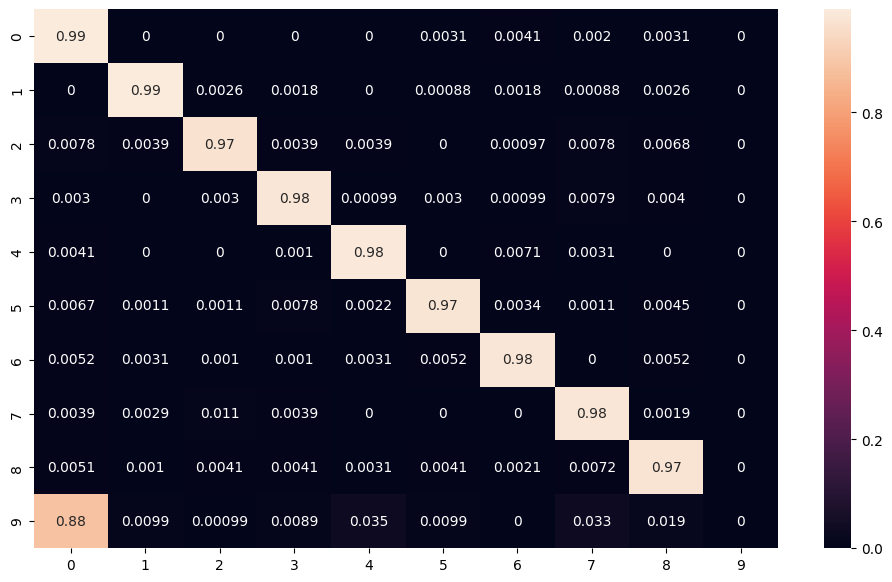

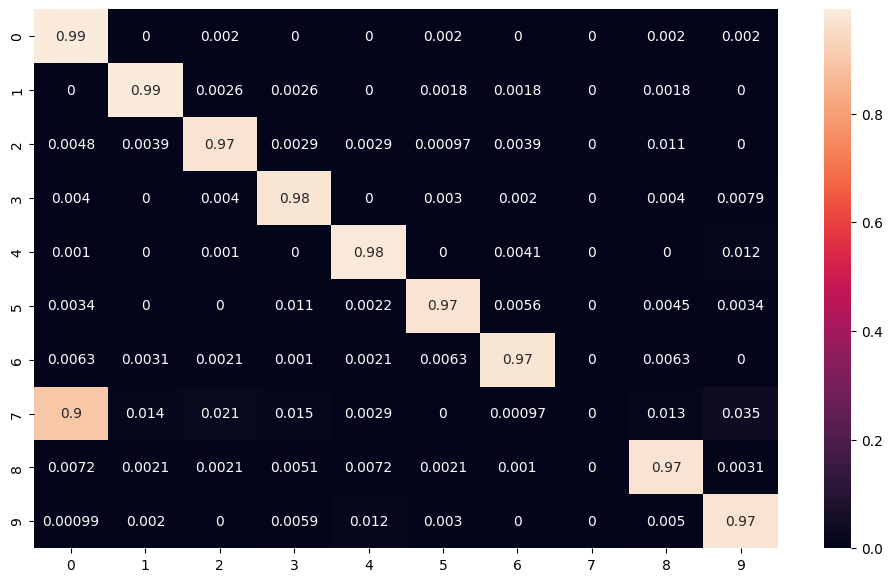

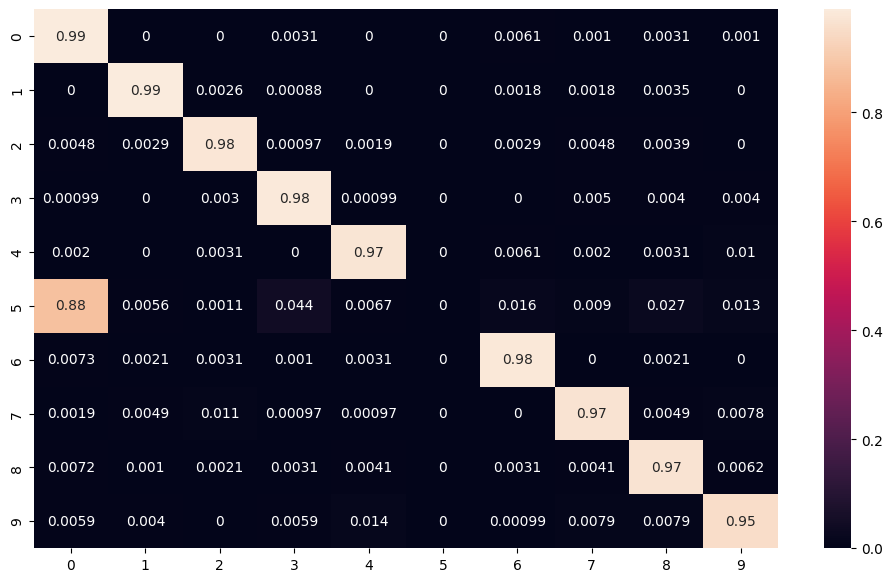

In [9]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=1",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  1
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    # Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth) +'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

#### Training MLP, depth = 3

Training and evaluating a MPL with depth = 3.

Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 53.81it/s]


Accuracy of the network: 70.82 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 77.64 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 79.5 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 59.68it/s]


Accuracy of the network: 80.54 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 59.67it/s]


Accuracy of the network: 81.06 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 58.72it/s]


Accuracy of the network: 81.82 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 59.45it/s]


Accuracy of the network: 82.04 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 59.40it/s]


Accuracy of the network: 82.34 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 56.74it/s]


Accuracy of the network: 82.84 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 59.23it/s]


Accuracy of the network: 83.04 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 59.58it/s]


Accuracy of the network: 82.74 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 59.61it/s]


Accuracy of the network: 82.92 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 59.90it/s]


Accuracy of the network: 83.2 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 59.77it/s]


Accuracy of the network: 83.02 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 59.29it/s]


Accuracy of the network: 83.5 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Accuracy of the network: 83.44 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 59.86it/s]


Accuracy of the network: 83.62 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 58.47it/s]


Accuracy of the network: 83.74 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 61.26it/s]


Accuracy of the network: 83.9 %


Training epoch 19: 100%|██████████| 430/430 [00:08<00:00, 53.61it/s]


Accuracy of the network: 83.8 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 59.55it/s]


Accuracy of the network: 84.04 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 59.50it/s]


Accuracy of the network: 84.16 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Accuracy of the network: 84.38 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 59.29it/s]


Accuracy of the network: 84.44 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 59.23it/s]


Accuracy of the network: 84.14 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 56.80it/s]


Accuracy of the network: 84.44 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 59.15it/s]


Accuracy of the network: 84.62 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 58.95it/s]


Accuracy of the network: 84.82 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 57.25it/s]


Accuracy of the network: 84.44 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 59.53it/s]


Accuracy of the network: 84.82 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 59.61it/s]


Accuracy of the network: 84.7 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 59.61it/s]


Accuracy of the network: 84.82 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 84.8 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 59.21it/s]


Accuracy of the network: 84.9 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 59.22it/s]


Accuracy of the network: 84.8 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 84.84 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 59.16it/s]


Accuracy of the network: 84.96 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 59.17it/s]


Accuracy of the network: 85.08 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 58.57it/s]


Accuracy of the network: 85.14 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 58.96it/s]


Accuracy of the network: 85.16 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 56.39it/s]


Accuracy of the network: 85.22 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 59.12it/s]


Accuracy of the network: 85.34 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 59.46it/s]


Accuracy of the network: 85.24 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 55.81it/s]


Accuracy of the network: 85.16 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 59.13it/s]


Accuracy of the network: 85.08 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.19it/s]


Accuracy of the network: 85.24 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 59.05it/s]


Accuracy of the network: 85.2 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 55.68it/s]


Accuracy of the network: 85.2 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 58.27it/s]


Accuracy of the network: 84.96 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 58.27it/s]


Accuracy of the network: 85.18 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 59.16it/s]


Accuracy of the network: 85.3 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 58.09it/s]


Accuracy of the network: 85.28 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 85.12 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 58.96it/s]


Accuracy of the network: 85.28 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 58.94it/s]


Accuracy of the network: 85.42 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 58.76it/s]


Accuracy of the network: 85.36 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 58.85it/s]


Accuracy of the network: 85.28 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 54.74it/s]


Accuracy of the network: 85.26 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 58.42it/s]


Accuracy of the network: 85.32 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 58.75it/s]


Accuracy of the network: 85.38 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 58.49it/s]


Accuracy of the network: 85.3 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 58.80it/s]


Accuracy of the network: 85.3 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 56.11it/s]


Accuracy of the network: 85.44 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 59.11it/s]


Accuracy of the network: 85.28 %


Training epoch 64: 100%|██████████| 430/430 [00:08<00:00, 53.75it/s]


Accuracy of the network: 85.42 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 59.31it/s]


Accuracy of the network: 85.22 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 59.15it/s]


Accuracy of the network: 85.54 %


Training epoch 67: 100%|██████████| 430/430 [00:08<00:00, 53.71it/s]


Accuracy of the network: 85.42 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 58.18it/s]


Accuracy of the network: 85.28 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 58.42it/s]


Accuracy of the network: 85.26 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 59.15it/s]


Accuracy of the network: 85.26 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 59.11it/s]


Accuracy of the network: 85.34 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 59.10it/s]


Accuracy of the network: 85.16 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 59.18it/s]


Accuracy of the network: 85.32 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 59.15it/s]


Accuracy of the network: 85.44 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 59.24it/s]


Accuracy of the network: 85.48 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 59.16it/s]


Accuracy of the network: 85.46 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 59.31it/s]


Accuracy of the network: 85.32 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 58.75it/s]


Accuracy of the network: 85.42 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 59.09it/s]


Accuracy of the network: 85.28 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 59.25it/s]


Accuracy of the network: 85.4 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 58.98it/s]


Accuracy of the network: 85.42 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 59.29it/s]


Accuracy of the network: 85.44 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 59.20it/s]


Accuracy of the network: 85.36 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 59.30it/s]


Accuracy of the network: 85.36 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 59.25it/s]


Accuracy of the network: 85.44 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 59.25it/s]


Accuracy of the network: 85.4 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 55.86it/s]


Accuracy of the network: 85.42 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 59.09it/s]


Accuracy of the network: 85.52 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 59.04it/s]


Accuracy of the network: 85.5 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 58.93it/s]


Accuracy of the network: 85.32 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 59.67it/s]


Accuracy of the network: 85.48 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 59.72it/s]


Accuracy of the network: 84.98 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 56.53it/s]


Accuracy of the network: 85.42 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 55.53it/s]


Accuracy of the network: 85.52 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 59.04it/s]


Accuracy of the network: 85.24 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 58.73it/s]


Accuracy of the network: 85.42 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 56.85it/s]


Accuracy of the network: 85.64 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 56.30it/s]


Accuracy of the network: 85.46 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Accuracy of the network: 85.46 %
Test accuracy of the network: 86.07 %


test_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
validation_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
test_accuracy,0.8607
train_loss,0.49327
validation_accuracy,0.8564
validation_loss,0.61522


Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 51.40it/s]


Accuracy of the network: 79.22 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 58.49it/s]


Accuracy of the network: 82.68 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 58.77it/s]


Accuracy of the network: 83.4 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 58.88it/s]


Accuracy of the network: 83.9 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 59.12it/s]


Accuracy of the network: 84.1 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 58.99it/s]


Accuracy of the network: 84.74 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 59.20it/s]


Accuracy of the network: 85.04 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 59.03it/s]


Accuracy of the network: 85.5 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 59.33it/s]


Accuracy of the network: 85.6 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 59.81it/s]


Accuracy of the network: 85.84 %


Training epoch 10: 100%|██████████| 430/430 [00:06<00:00, 62.70it/s]


Accuracy of the network: 85.94 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 60.76it/s]


Accuracy of the network: 86.14 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 56.87it/s]


Accuracy of the network: 86.36 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 60.54it/s]


Accuracy of the network: 86.12 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 60.83it/s]


Accuracy of the network: 86.32 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Accuracy of the network: 86.44 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 59.73it/s]


Accuracy of the network: 86.56 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 59.96it/s]


Accuracy of the network: 86.66 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 60.00it/s]


Accuracy of the network: 86.62 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 59.57it/s]


Accuracy of the network: 86.76 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 56.59it/s]


Accuracy of the network: 86.84 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 59.86it/s]


Accuracy of the network: 86.78 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 59.92it/s]


Accuracy of the network: 86.9 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 59.66it/s]


Accuracy of the network: 87.06 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 60.01it/s]


Accuracy of the network: 87.04 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 60.09it/s]


Accuracy of the network: 86.92 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 59.50it/s]


Accuracy of the network: 87.1 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 59.34it/s]


Accuracy of the network: 87.24 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 60.00it/s]


Accuracy of the network: 87.2 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 59.82it/s]


Accuracy of the network: 87.32 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 59.79it/s]


Accuracy of the network: 87.02 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 60.05it/s]


Accuracy of the network: 87.34 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 57.99it/s]


Accuracy of the network: 87.22 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 59.86it/s]


Accuracy of the network: 87.38 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 59.74it/s]


Accuracy of the network: 87.48 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 59.59it/s]


Accuracy of the network: 87.48 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 59.54it/s]


Accuracy of the network: 87.46 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 59.57it/s]


Accuracy of the network: 87.54 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 59.44it/s]


Accuracy of the network: 87.4 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 87.4 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 56.32it/s]


Accuracy of the network: 87.58 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 59.23it/s]


Accuracy of the network: 87.38 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 58.85it/s]


Accuracy of the network: 87.3 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.52 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 59.45it/s]


Accuracy of the network: 87.42 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.22it/s]


Accuracy of the network: 87.3 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 59.17it/s]


Accuracy of the network: 87.6 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 57.18it/s]


Accuracy of the network: 87.6 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 59.50it/s]


Accuracy of the network: 87.44 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 56.85it/s]


Accuracy of the network: 87.56 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 58.54it/s]


Accuracy of the network: 87.52 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 59.38it/s]


Accuracy of the network: 87.5 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 59.20it/s]


Accuracy of the network: 87.42 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 57.70it/s]


Accuracy of the network: 87.36 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 87.56 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 59.52it/s]


Accuracy of the network: 87.5 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Accuracy of the network: 87.34 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 59.64it/s]


Accuracy of the network: 87.48 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 59.27it/s]


Accuracy of the network: 87.3 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 59.58it/s]


Accuracy of the network: 87.18 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 55.52it/s]


Accuracy of the network: 87.46 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 59.46it/s]


Accuracy of the network: 87.34 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 87.3 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.3 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 59.18it/s]


Accuracy of the network: 87.38 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 58.73it/s]


Accuracy of the network: 87.44 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 58.74it/s]


Accuracy of the network: 87.52 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 59.24it/s]


Accuracy of the network: 87.4 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 59.43it/s]


Accuracy of the network: 87.58 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 59.59it/s]


Accuracy of the network: 87.58 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 55.16it/s]


Accuracy of the network: 87.48 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 87.38 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 59.30it/s]


Accuracy of the network: 87.36 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 87.44 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 59.35it/s]


Accuracy of the network: 87.44 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 87.5 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 59.30it/s]


Accuracy of the network: 87.32 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 59.25it/s]


Accuracy of the network: 87.3 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 59.35it/s]


Accuracy of the network: 87.44 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 58.07it/s]


Accuracy of the network: 87.32 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 59.46it/s]


Accuracy of the network: 87.32 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 58.58it/s]


Accuracy of the network: 87.42 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 59.25it/s]


Accuracy of the network: 87.4 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 59.12it/s]


Accuracy of the network: 87.32 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 59.26it/s]


Accuracy of the network: 87.36 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.26 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 57.30it/s]


Accuracy of the network: 87.38 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 59.18it/s]


Accuracy of the network: 87.34 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 59.36it/s]


Accuracy of the network: 87.38 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Accuracy of the network: 87.3 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 58.99it/s]


Accuracy of the network: 87.32 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 59.34it/s]


Accuracy of the network: 87.18 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 59.75it/s]


Accuracy of the network: 87.24 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 59.38it/s]


Accuracy of the network: 87.52 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 58.96it/s]


Accuracy of the network: 87.22 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.83it/s]


Accuracy of the network: 87.4 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 59.73it/s]


Accuracy of the network: 87.3 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Accuracy of the network: 87.24 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 59.63it/s]


Accuracy of the network: 87.22 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Accuracy of the network: 87.26 %
Test accuracy of the network: 88.06 %


test_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
validation_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8806
train_loss,0.2317
validation_accuracy,0.876
validation_loss,0.32721


Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 55.93it/s]


Accuracy of the network: 70.34 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 59.04it/s]


Accuracy of the network: 71.74 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 59.31it/s]


Accuracy of the network: 72.52 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 58.61it/s]


Accuracy of the network: 73.12 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 58.68it/s]


Accuracy of the network: 73.48 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 59.26it/s]


Accuracy of the network: 74.14 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 59.60it/s]


Accuracy of the network: 74.3 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 57.30it/s]


Accuracy of the network: 74.66 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 57.27it/s]


Accuracy of the network: 74.92 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 58.37it/s]


Accuracy of the network: 84.98 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 59.53it/s]


Accuracy of the network: 84.68 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 57.48it/s]


Accuracy of the network: 85.16 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 59.55it/s]


Accuracy of the network: 85.26 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 59.65it/s]


Accuracy of the network: 85.4 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 59.29it/s]


Accuracy of the network: 85.58 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 57.56it/s]


Accuracy of the network: 85.7 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 59.69it/s]


Accuracy of the network: 85.78 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 57.18it/s]


Accuracy of the network: 85.92 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 59.53it/s]


Accuracy of the network: 86.0 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 59.26it/s]


Accuracy of the network: 86.08 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 59.50it/s]


Accuracy of the network: 86.06 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 59.50it/s]


Accuracy of the network: 86.22 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 57.75it/s]


Accuracy of the network: 86.3 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 86.34 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 55.56it/s]


Accuracy of the network: 86.18 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 59.34it/s]


Accuracy of the network: 86.34 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 55.14it/s]


Accuracy of the network: 86.4 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 59.43it/s]


Accuracy of the network: 86.5 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 86.6 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 58.97it/s]


Accuracy of the network: 86.58 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Accuracy of the network: 86.72 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 55.31it/s]


Accuracy of the network: 86.6 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 59.47it/s]


Accuracy of the network: 86.76 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 59.54it/s]


Accuracy of the network: 86.84 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 59.35it/s]


Accuracy of the network: 86.66 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 59.47it/s]


Accuracy of the network: 86.74 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 59.57it/s]


Accuracy of the network: 86.72 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 59.99it/s]


Accuracy of the network: 86.7 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 56.02it/s]


Accuracy of the network: 86.94 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 59.93it/s]


Accuracy of the network: 86.88 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 59.87it/s]


Accuracy of the network: 87.02 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 86.94 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 59.48it/s]


Accuracy of the network: 87.04 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 56.09it/s]


Accuracy of the network: 87.16 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 59.47it/s]


Accuracy of the network: 86.96 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.43it/s]


Accuracy of the network: 87.14 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 59.59it/s]


Accuracy of the network: 87.02 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 56.96it/s]


Accuracy of the network: 87.0 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 60.09it/s]


Accuracy of the network: 86.96 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 59.57it/s]


Accuracy of the network: 87.04 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 59.49it/s]


Accuracy of the network: 86.94 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 59.58it/s]


Accuracy of the network: 87.16 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 87.02 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 54.57it/s]


Accuracy of the network: 87.1 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 56.61it/s]


Accuracy of the network: 87.14 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 59.72it/s]


Accuracy of the network: 87.12 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 58.65it/s]


Accuracy of the network: 87.12 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 59.56it/s]


Accuracy of the network: 87.14 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 59.17it/s]


Accuracy of the network: 87.26 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 58.19it/s]


Accuracy of the network: 87.28 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.04 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 56.49it/s]


Accuracy of the network: 87.4 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.2 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 59.05it/s]


Accuracy of the network: 87.24 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 59.00it/s]


Accuracy of the network: 87.1 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 57.13it/s]


Accuracy of the network: 87.22 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 59.36it/s]


Accuracy of the network: 87.28 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 57.99it/s]


Accuracy of the network: 87.28 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 58.12it/s]


Accuracy of the network: 87.12 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 57.72it/s]


Accuracy of the network: 87.14 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 59.86it/s]


Accuracy of the network: 87.06 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 59.80it/s]


Accuracy of the network: 87.28 %


Training epoch 72: 100%|██████████| 430/430 [00:08<00:00, 53.59it/s]


Accuracy of the network: 87.28 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 59.41it/s]


Accuracy of the network: 87.18 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 59.48it/s]


Accuracy of the network: 87.26 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 57.96it/s]


Accuracy of the network: 87.22 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 59.87it/s]


Accuracy of the network: 87.34 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Accuracy of the network: 87.4 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 59.29it/s]


Accuracy of the network: 87.2 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 60.02it/s]


Accuracy of the network: 87.16 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 59.98it/s]


Accuracy of the network: 87.28 %


Training epoch 81: 100%|██████████| 430/430 [00:08<00:00, 53.61it/s]


Accuracy of the network: 87.16 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Accuracy of the network: 87.18 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 58.93it/s]


Accuracy of the network: 87.28 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 59.70it/s]


Accuracy of the network: 87.16 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 60.10it/s]


Accuracy of the network: 87.22 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 59.10it/s]


Accuracy of the network: 87.34 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 55.62it/s]


Accuracy of the network: 87.36 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 59.49it/s]


Accuracy of the network: 87.24 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 59.75it/s]


Accuracy of the network: 87.3 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 59.39it/s]


Accuracy of the network: 87.42 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 59.05it/s]


Accuracy of the network: 87.34 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 57.39it/s]


Accuracy of the network: 87.26 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 58.88it/s]


Accuracy of the network: 87.24 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 59.20it/s]


Accuracy of the network: 87.22 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 87.4 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 59.83it/s]


Accuracy of the network: 87.28 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 59.60it/s]


Accuracy of the network: 87.3 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 59.67it/s]


Accuracy of the network: 87.34 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Accuracy of the network: 87.42 %
Test accuracy of the network: 87.91 %


test_accuracy,▁
train_loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▂▃▃▇▇▇▇▇███████████████████████████████
validation_loss,█▆▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8791
train_loss,0.23385
validation_accuracy,0.8742
validation_loss,0.36716


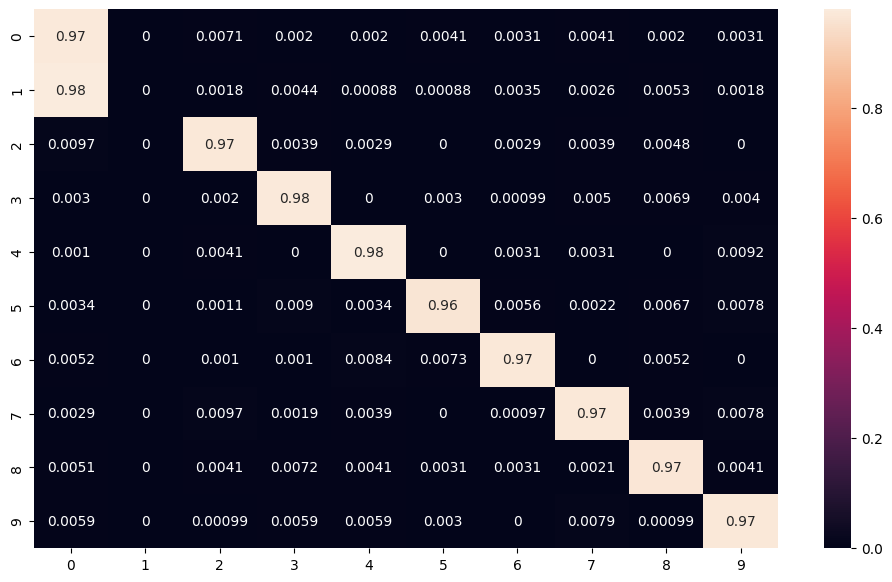

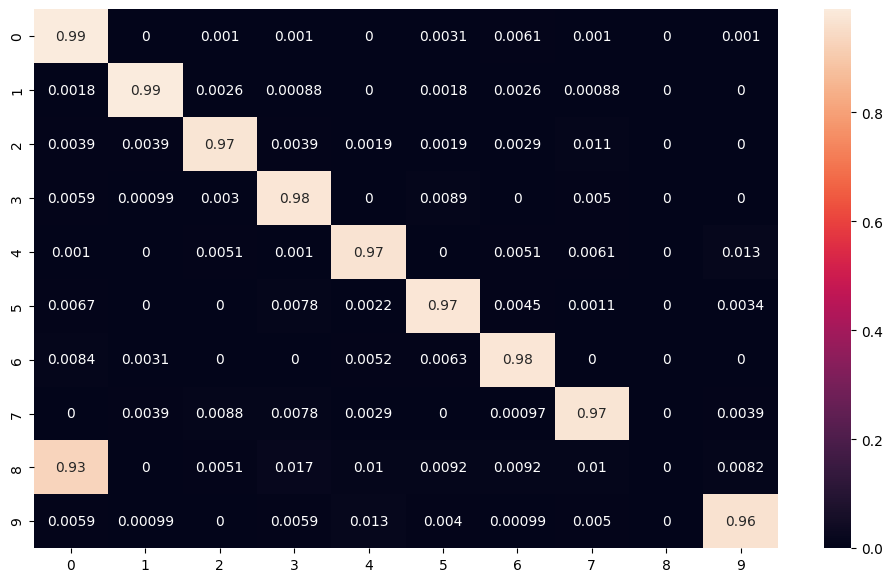

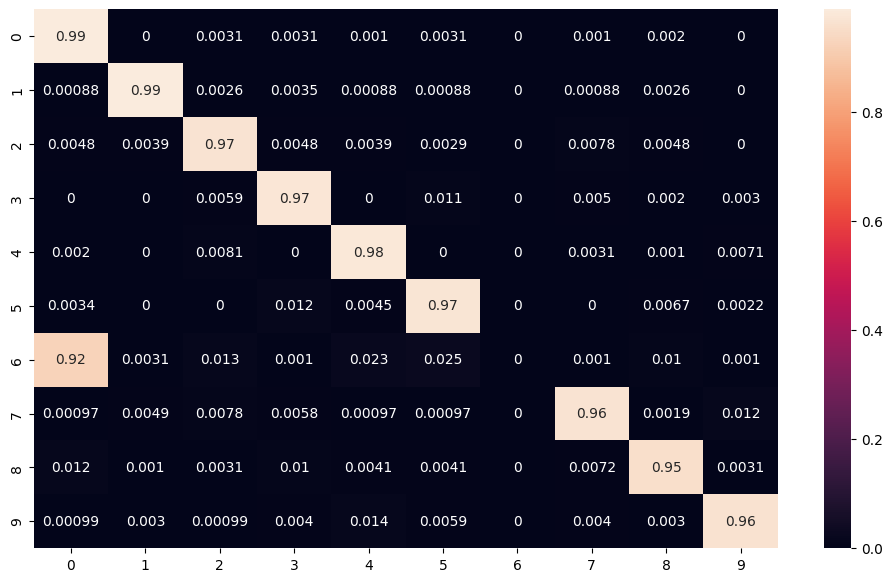

In [10]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=3",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  3
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    # Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

#### Training MLP, depth = 5

Training and evaluating a MPL with depth = 5.

Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 50.51it/s]


Accuracy of the network: 62.88 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 57.63it/s]


Accuracy of the network: 64.96 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 55.92it/s]


Accuracy of the network: 66.2 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 59.32it/s]


Accuracy of the network: 66.82 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 56.97it/s]


Accuracy of the network: 75.66 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 57.70it/s]


Accuracy of the network: 76.0 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 57.76it/s]


Accuracy of the network: 76.36 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 54.94it/s]


Accuracy of the network: 76.46 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 55.52it/s]


Accuracy of the network: 76.64 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 53.85it/s]


Accuracy of the network: 76.92 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 57.68it/s]


Accuracy of the network: 77.02 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 77.18 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 57.81it/s]


Accuracy of the network: 77.1 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 57.85it/s]


Accuracy of the network: 77.2 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 56.47it/s]


Accuracy of the network: 77.44 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 55.71it/s]


Accuracy of the network: 77.22 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 77.3 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 55.33it/s]


Accuracy of the network: 77.5 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 57.30it/s]


Accuracy of the network: 77.38 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 55.17it/s]


Accuracy of the network: 77.52 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 57.21it/s]


Accuracy of the network: 77.58 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 57.47it/s]


Accuracy of the network: 77.5 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 57.00it/s]


Accuracy of the network: 77.48 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 57.04it/s]


Accuracy of the network: 77.6 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 57.39it/s]


Accuracy of the network: 77.72 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 54.29it/s]


Accuracy of the network: 77.62 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 56.55it/s]


Accuracy of the network: 77.6 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 57.65it/s]


Accuracy of the network: 77.66 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 77.9 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 56.79it/s]


Accuracy of the network: 77.8 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 55.34it/s]


Accuracy of the network: 77.78 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 56.92it/s]


Accuracy of the network: 77.8 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 58.29it/s]


Accuracy of the network: 77.84 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 58.05it/s]


Accuracy of the network: 77.96 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 58.53it/s]


Accuracy of the network: 77.88 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 57.16it/s]


Accuracy of the network: 77.9 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 59.16it/s]


Accuracy of the network: 77.84 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 57.72it/s]


Accuracy of the network: 77.92 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 56.33it/s]


Accuracy of the network: 77.9 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 57.66it/s]


Accuracy of the network: 78.08 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 56.76it/s]


Accuracy of the network: 77.86 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 57.37it/s]


Accuracy of the network: 77.94 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 56.54it/s]


Accuracy of the network: 77.72 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 57.83it/s]


Accuracy of the network: 77.96 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 58.31it/s]


Accuracy of the network: 78.02 %


Training epoch 45: 100%|██████████| 430/430 [00:08<00:00, 52.70it/s]


Accuracy of the network: 77.88 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 55.09it/s]


Accuracy of the network: 77.86 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 57.38it/s]


Accuracy of the network: 77.92 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 57.27it/s]


Accuracy of the network: 78.04 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 56.94it/s]


Accuracy of the network: 77.92 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 57.54it/s]


Accuracy of the network: 77.8 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 56.71it/s]


Accuracy of the network: 77.96 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 57.46it/s]


Accuracy of the network: 77.98 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 57.31it/s]


Accuracy of the network: 77.92 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 57.72it/s]


Accuracy of the network: 77.78 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 57.44it/s]


Accuracy of the network: 77.96 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 55.38it/s]


Accuracy of the network: 77.82 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 57.18it/s]


Accuracy of the network: 77.88 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 55.87it/s]


Accuracy of the network: 78.02 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 54.52it/s]


Accuracy of the network: 77.72 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 55.77it/s]


Accuracy of the network: 77.76 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 55.28it/s]


Accuracy of the network: 77.78 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 57.08it/s]


Accuracy of the network: 77.86 %


Training epoch 63: 100%|██████████| 430/430 [00:08<00:00, 52.93it/s]


Accuracy of the network: 77.76 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 57.95it/s]


Accuracy of the network: 77.84 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 57.43it/s]


Accuracy of the network: 77.96 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 57.53it/s]


Accuracy of the network: 77.74 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 57.22it/s]


Accuracy of the network: 77.96 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 55.02it/s]


Accuracy of the network: 77.78 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 57.50it/s]


Accuracy of the network: 77.76 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 54.53it/s]


Accuracy of the network: 77.8 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 57.06it/s]


Accuracy of the network: 77.64 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 55.52it/s]


Accuracy of the network: 77.86 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 57.57it/s]


Accuracy of the network: 77.76 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 57.69it/s]


Accuracy of the network: 77.74 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 57.44it/s]


Accuracy of the network: 77.78 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 57.51it/s]


Accuracy of the network: 77.76 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 77.86 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 56.45it/s]


Accuracy of the network: 77.86 %


Training epoch 79: 100%|██████████| 430/430 [00:08<00:00, 53.10it/s]


Accuracy of the network: 77.88 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 57.18it/s]


Accuracy of the network: 77.74 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 56.91it/s]


Accuracy of the network: 77.66 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 56.87it/s]


Accuracy of the network: 77.72 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 56.67it/s]


Accuracy of the network: 77.7 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 57.22it/s]


Accuracy of the network: 77.78 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 57.10it/s]


Accuracy of the network: 77.54 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 57.06it/s]


Accuracy of the network: 77.8 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 56.99it/s]


Accuracy of the network: 77.76 %


Training epoch 88: 100%|██████████| 430/430 [00:08<00:00, 52.52it/s]


Accuracy of the network: 77.72 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 55.67it/s]


Accuracy of the network: 77.78 %


Training epoch 90: 100%|██████████| 430/430 [00:08<00:00, 53.54it/s]


Accuracy of the network: 77.88 %


Training epoch 91: 100%|██████████| 430/430 [00:08<00:00, 50.79it/s]


Accuracy of the network: 77.6 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 57.02it/s]


Accuracy of the network: 77.8 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 56.53it/s]


Accuracy of the network: 77.86 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 57.58it/s]


Accuracy of the network: 77.84 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 77.8 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 56.13it/s]


Accuracy of the network: 77.82 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 55.94it/s]


Accuracy of the network: 77.8 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 56.89it/s]


Accuracy of the network: 77.72 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 57.02it/s]


Accuracy of the network: 77.74 %
Test accuracy of the network: 78.17 %


test_accuracy,▁
train_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▇▇████████████████████████████████████
validation_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.7817
train_loss,0.46633
validation_accuracy,0.7808
validation_loss,0.56062


Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 48.00it/s]


Accuracy of the network: 46.92 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 57.12it/s]


Accuracy of the network: 48.1 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 57.13it/s]


Accuracy of the network: 48.3 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 56.91it/s]


Accuracy of the network: 48.52 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 54.62it/s]


Accuracy of the network: 48.44 %


Training epoch 5: 100%|██████████| 430/430 [00:07<00:00, 57.63it/s]


Accuracy of the network: 48.7 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 55.53it/s]


Accuracy of the network: 48.92 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 57.52it/s]


Accuracy of the network: 49.04 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 56.67it/s]


Accuracy of the network: 49.26 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 57.48it/s]


Accuracy of the network: 49.14 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 57.45it/s]


Accuracy of the network: 49.16 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 57.10it/s]


Accuracy of the network: 49.3 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 56.64it/s]


Accuracy of the network: 49.08 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 55.51it/s]


Accuracy of the network: 49.26 %


Training epoch 14: 100%|██████████| 430/430 [00:08<00:00, 53.26it/s]


Accuracy of the network: 49.18 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 57.92it/s]


Accuracy of the network: 49.22 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 55.91it/s]


Accuracy of the network: 49.26 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 57.61it/s]


Accuracy of the network: 49.3 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 56.24it/s]


Accuracy of the network: 49.26 %


Training epoch 19: 100%|██████████| 430/430 [00:08<00:00, 52.13it/s]


Accuracy of the network: 49.46 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 57.25it/s]


Accuracy of the network: 49.28 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 56.09it/s]


Accuracy of the network: 49.38 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 57.19it/s]


Accuracy of the network: 49.3 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 49.26 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 57.60it/s]


Accuracy of the network: 49.16 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 54.02it/s]


Accuracy of the network: 49.38 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 57.57it/s]


Accuracy of the network: 49.34 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 57.48it/s]


Accuracy of the network: 49.24 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 57.36it/s]


Accuracy of the network: 49.46 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 56.22it/s]


Accuracy of the network: 49.44 %


Training epoch 30: 100%|██████████| 430/430 [00:08<00:00, 53.57it/s]


Accuracy of the network: 49.22 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 57.70it/s]


Accuracy of the network: 49.28 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 56.91it/s]


Accuracy of the network: 49.5 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 57.58it/s]


Accuracy of the network: 49.36 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 57.78it/s]


Accuracy of the network: 49.26 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 57.63it/s]


Accuracy of the network: 49.26 %


Training epoch 36: 100%|██████████| 430/430 [00:08<00:00, 53.53it/s]


Accuracy of the network: 49.0 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 49.18 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 57.43it/s]


Accuracy of the network: 49.32 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 57.37it/s]


Accuracy of the network: 49.3 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 57.33it/s]


Accuracy of the network: 49.38 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 57.52it/s]


Accuracy of the network: 49.46 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 57.56it/s]


Accuracy of the network: 49.36 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 57.28it/s]


Accuracy of the network: 49.42 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 57.72it/s]


Accuracy of the network: 49.18 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 57.53it/s]


Accuracy of the network: 49.12 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 57.62it/s]


Accuracy of the network: 49.16 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 57.45it/s]


Accuracy of the network: 49.38 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 49.28 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 57.53it/s]


Accuracy of the network: 49.26 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 57.37it/s]


Accuracy of the network: 49.16 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 57.52it/s]


Accuracy of the network: 49.32 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 57.40it/s]


Accuracy of the network: 49.22 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 57.38it/s]


Accuracy of the network: 49.14 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 57.29it/s]


Accuracy of the network: 49.12 %


Training epoch 55: 100%|██████████| 430/430 [00:08<00:00, 52.38it/s]


Accuracy of the network: 49.32 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 54.63it/s]


Accuracy of the network: 49.26 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 57.18it/s]


Accuracy of the network: 49.06 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 57.56it/s]


Accuracy of the network: 49.32 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 57.21it/s]


Accuracy of the network: 49.48 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 57.95it/s]


Accuracy of the network: 49.3 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 57.36it/s]


Accuracy of the network: 49.1 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 57.56it/s]


Accuracy of the network: 49.08 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 57.35it/s]


Accuracy of the network: 49.22 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 57.54it/s]


Accuracy of the network: 49.2 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 57.69it/s]


Accuracy of the network: 49.28 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 49.26 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 49.22 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 57.83it/s]


Accuracy of the network: 49.04 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 57.48it/s]


Accuracy of the network: 49.06 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 57.70it/s]


Accuracy of the network: 49.06 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 57.50it/s]


Accuracy of the network: 49.28 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 49.3 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 57.42it/s]


Accuracy of the network: 49.24 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 57.40it/s]


Accuracy of the network: 49.22 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 57.80it/s]


Accuracy of the network: 49.22 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 57.63it/s]


Accuracy of the network: 49.16 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 57.11it/s]


Accuracy of the network: 49.34 %


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 57.31it/s]


Accuracy of the network: 49.24 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 57.33it/s]


Accuracy of the network: 49.14 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 56.21it/s]


Accuracy of the network: 49.12 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 49.24 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 56.99it/s]


Accuracy of the network: 49.08 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 57.11it/s]


Accuracy of the network: 49.36 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 57.37it/s]


Accuracy of the network: 49.14 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 57.53it/s]


Accuracy of the network: 48.94 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 57.84it/s]


Accuracy of the network: 49.08 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 57.69it/s]


Accuracy of the network: 49.28 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 57.60it/s]


Accuracy of the network: 48.98 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 54.61it/s]


Accuracy of the network: 49.12 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 57.52it/s]


Accuracy of the network: 49.18 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 57.06it/s]


Accuracy of the network: 48.98 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 49.2 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 56.38it/s]


Accuracy of the network: 49.26 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 55.70it/s]


Accuracy of the network: 49.2 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.68it/s]


Accuracy of the network: 49.26 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 57.68it/s]


Accuracy of the network: 49.3 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 57.06it/s]


Accuracy of the network: 49.3 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 57.93it/s]


Accuracy of the network: 49.0 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 49.1 %
Test accuracy of the network: 47.75 %


test_accuracy,▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇▇████████████████████████████████
validation_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.4775
train_loss,1.1742
validation_accuracy,0.495
validation_loss,1.21783


Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 48.98it/s]


Accuracy of the network: 60.94 %


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 57.78it/s]


Accuracy of the network: 64.4 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 56.31it/s]


Accuracy of the network: 65.34 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 57.80it/s]


Accuracy of the network: 65.74 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 57.80it/s]


Accuracy of the network: 66.24 %


Training epoch 5: 100%|██████████| 430/430 [00:08<00:00, 53.73it/s]


Accuracy of the network: 66.48 %


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 56.28it/s]


Accuracy of the network: 66.78 %


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 54.14it/s]


Accuracy of the network: 67.08 %


Training epoch 8: 100%|██████████| 430/430 [00:07<00:00, 57.54it/s]


Accuracy of the network: 67.24 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 57.19it/s]


Accuracy of the network: 67.14 %


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 56.81it/s]


Accuracy of the network: 67.56 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 57.50it/s]


Accuracy of the network: 67.6 %


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 57.31it/s]


Accuracy of the network: 67.7 %


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 56.75it/s]


Accuracy of the network: 67.78 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 57.44it/s]


Accuracy of the network: 67.84 %


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 57.47it/s]


Accuracy of the network: 67.94 %


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 67.56 %


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 57.55it/s]


Accuracy of the network: 67.86 %


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 58.08it/s]


Accuracy of the network: 68.14 %


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 58.17it/s]


Accuracy of the network: 68.12 %


Training epoch 20: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 68.04 %


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 68.04 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 57.62it/s]


Accuracy of the network: 68.14 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 56.79it/s]


Accuracy of the network: 68.08 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 57.95it/s]


Accuracy of the network: 68.26 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 55.24it/s]


Accuracy of the network: 67.9 %


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 58.09it/s]


Accuracy of the network: 68.22 %


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 55.60it/s]


Accuracy of the network: 68.16 %


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 58.06it/s]


Accuracy of the network: 68.26 %


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 58.04it/s]


Accuracy of the network: 68.04 %


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 57.77it/s]


Accuracy of the network: 68.2 %


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 57.99it/s]


Accuracy of the network: 68.2 %


Training epoch 32: 100%|██████████| 430/430 [00:07<00:00, 57.96it/s]


Accuracy of the network: 68.28 %


Training epoch 33: 100%|██████████| 430/430 [00:07<00:00, 57.93it/s]


Accuracy of the network: 68.3 %


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 54.04it/s]


Accuracy of the network: 68.22 %


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 57.03it/s]


Accuracy of the network: 68.16 %


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 57.47it/s]


Accuracy of the network: 68.22 %


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 57.68it/s]


Accuracy of the network: 68.22 %


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 55.70it/s]


Accuracy of the network: 68.32 %


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 68.36 %


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 55.96it/s]


Accuracy of the network: 68.36 %


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 53.87it/s]


Accuracy of the network: 68.38 %


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 57.85it/s]


Accuracy of the network: 68.4 %


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 55.07it/s]


Accuracy of the network: 68.22 %


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 57.13it/s]


Accuracy of the network: 68.14 %


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 56.03it/s]


Accuracy of the network: 68.28 %


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 57.80it/s]


Accuracy of the network: 68.12 %


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 56.57it/s]


Accuracy of the network: 68.3 %


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 68.46 %


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 55.39it/s]


Accuracy of the network: 68.34 %


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 57.34it/s]


Accuracy of the network: 68.28 %


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 56.91it/s]


Accuracy of the network: 68.48 %


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 57.87it/s]


Accuracy of the network: 68.16 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 57.56it/s]


Accuracy of the network: 68.22 %


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 57.97it/s]


Accuracy of the network: 68.3 %


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 58.15it/s]


Accuracy of the network: 68.28 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 57.53it/s]


Accuracy of the network: 68.44 %


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 56.85it/s]


Accuracy of the network: 68.32 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 56.63it/s]


Accuracy of the network: 68.22 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 68.36 %


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 57.47it/s]


Accuracy of the network: 68.16 %


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 56.99it/s]


Accuracy of the network: 68.32 %


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 57.85it/s]


Accuracy of the network: 68.16 %


Training epoch 63: 100%|██████████| 430/430 [00:07<00:00, 57.90it/s]


Accuracy of the network: 68.26 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 58.02it/s]


Accuracy of the network: 68.18 %


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 57.73it/s]


Accuracy of the network: 68.26 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 57.64it/s]


Accuracy of the network: 68.38 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 57.22it/s]


Accuracy of the network: 68.5 %


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 55.62it/s]


Accuracy of the network: 68.24 %


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 57.49it/s]


Accuracy of the network: 68.3 %


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 57.83it/s]


Accuracy of the network: 68.02 %


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 57.61it/s]


Accuracy of the network: 68.28 %


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 56.28it/s]


Accuracy of the network: 68.0 %


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 57.81it/s]


Accuracy of the network: 68.38 %


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 68.18 %


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 57.69it/s]


Accuracy of the network: 68.3 %


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 57.93it/s]


Accuracy of the network: 68.26 %


Training epoch 77: 100%|██████████| 430/430 [00:08<00:00, 53.42it/s]


Accuracy of the network: 68.16 %


Training epoch 78: 100%|██████████| 430/430 [00:08<00:00, 51.69it/s]


Accuracy of the network: 68.38 %


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 57.13it/s]


Accuracy of the network: 68.38 %


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 57.88it/s]


Accuracy of the network: 68.2 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 57.10it/s]


Accuracy of the network: 68.18 %


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 68.2 %


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 57.72it/s]


Accuracy of the network: 68.38 %


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 57.84it/s]


Accuracy of the network: 68.24 %


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 57.82it/s]


Accuracy of the network: 68.18 %


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 57.14it/s]


Accuracy of the network: 68.1 %


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 68.22 %


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 57.75it/s]


Accuracy of the network: 68.18 %


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 56.98it/s]


Accuracy of the network: 68.1 %


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 68.24 %


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 57.80it/s]


Accuracy of the network: 68.3 %


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 57.64it/s]


Accuracy of the network: 68.34 %


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 57.71it/s]


Accuracy of the network: 68.28 %


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 56.39it/s]


Accuracy of the network: 68.08 %


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 57.89it/s]


Accuracy of the network: 68.32 %


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 57.86it/s]


Accuracy of the network: 68.34 %


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 57.74it/s]


Accuracy of the network: 68.42 %


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 57.94it/s]


Accuracy of the network: 68.04 %


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 57.76it/s]


Accuracy of the network: 67.9 %
Test accuracy of the network: 68.78 %


test_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇▇████████████████████████████████
validation_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.6878
train_loss,0.69499
validation_accuracy,0.685
validation_loss,0.80647


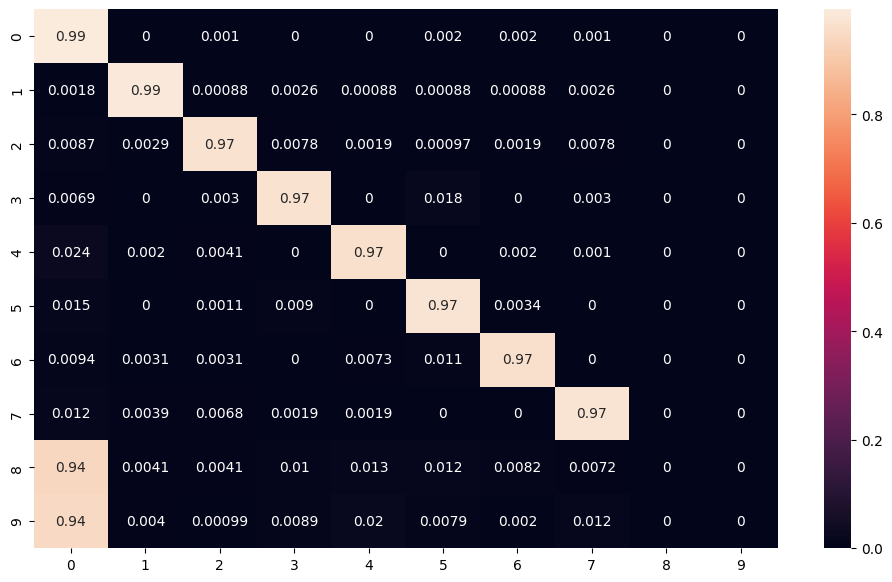

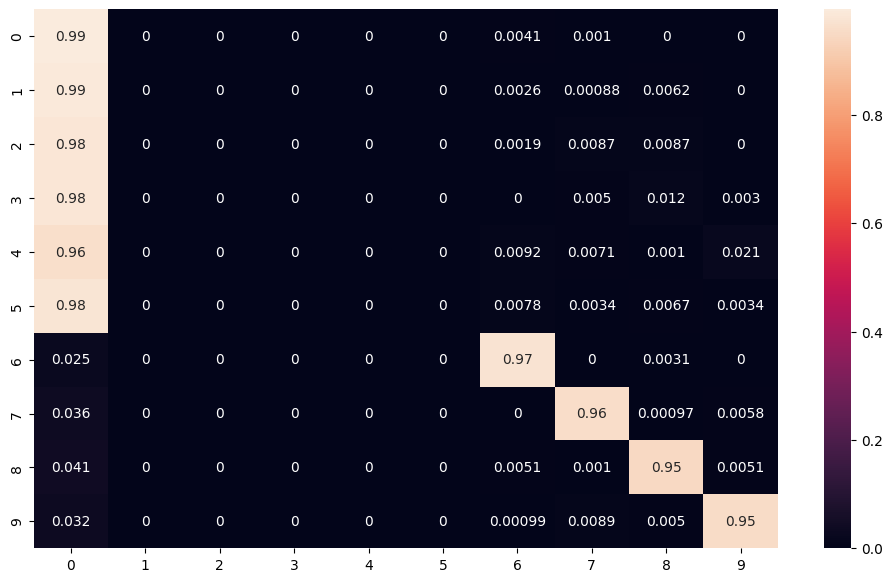

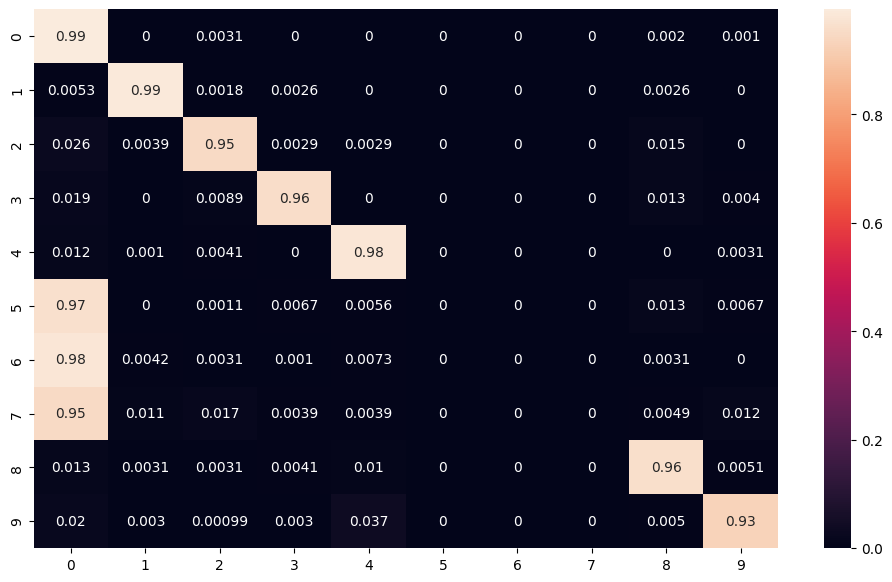

In [11]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=5",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  5
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    # Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

#### Training MLP, depth = 10

Training and evaluating a MPL with depth = 10.

Training epoch 0: 100%|██████████| 430/430 [00:09<00:00, 46.91it/s]


Accuracy of the network: 58.16 %


Training epoch 1: 100%|██████████| 430/430 [00:08<00:00, 50.40it/s]


Accuracy of the network: 69.08 %


Training epoch 2: 100%|██████████| 430/430 [00:08<00:00, 53.30it/s]


Accuracy of the network: 72.56 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 55.98it/s]


Accuracy of the network: 75.32 %


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 57.19it/s]


Accuracy of the network: 76.76 %


Training epoch 5: 100%|██████████| 430/430 [00:08<00:00, 52.49it/s]


Accuracy of the network: 78.06 %


Training epoch 6: 100%|██████████| 430/430 [00:08<00:00, 52.92it/s]


Accuracy of the network: 79.0 %


Training epoch 7: 100%|██████████| 430/430 [00:09<00:00, 44.60it/s]


Accuracy of the network: 79.48 %


Training epoch 8: 100%|██████████| 430/430 [00:08<00:00, 52.84it/s]


Accuracy of the network: 80.06 %


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 54.31it/s]


Accuracy of the network: 80.24 %


Training epoch 10: 100%|██████████| 430/430 [00:08<00:00, 49.72it/s]


Accuracy of the network: 81.08 %


Training epoch 11: 100%|██████████| 430/430 [00:08<00:00, 52.43it/s]


Accuracy of the network: 81.02 %


Training epoch 12: 100%|██████████| 430/430 [00:08<00:00, 52.09it/s]


Accuracy of the network: 81.1 %


Training epoch 13: 100%|██████████| 430/430 [00:08<00:00, 49.72it/s]


Accuracy of the network: 81.58 %


Training epoch 14: 100%|██████████| 430/430 [00:08<00:00, 52.77it/s]


Accuracy of the network: 80.56 %


Training epoch 15: 100%|██████████| 430/430 [00:08<00:00, 52.07it/s]


Accuracy of the network: 81.82 %


Training epoch 16: 100%|██████████| 430/430 [00:08<00:00, 51.64it/s]


Accuracy of the network: 82.04 %


Training epoch 17: 100%|██████████| 430/430 [00:08<00:00, 52.18it/s]


Accuracy of the network: 82.02 %


Training epoch 18: 100%|██████████| 430/430 [00:08<00:00, 51.93it/s]


Accuracy of the network: 82.46 %


Training epoch 19: 100%|██████████| 430/430 [00:08<00:00, 52.87it/s]


Accuracy of the network: 82.44 %


Training epoch 20: 100%|██████████| 430/430 [00:08<00:00, 52.06it/s]


Accuracy of the network: 82.4 %


Training epoch 21: 100%|██████████| 430/430 [00:08<00:00, 48.13it/s]


Accuracy of the network: 82.32 %


Training epoch 22: 100%|██████████| 430/430 [00:08<00:00, 51.79it/s]


Accuracy of the network: 82.96 %


Training epoch 23: 100%|██████████| 430/430 [00:08<00:00, 52.80it/s]


Accuracy of the network: 82.46 %


Training epoch 24: 100%|██████████| 430/430 [00:08<00:00, 52.25it/s]


Accuracy of the network: 83.06 %


Training epoch 25: 100%|██████████| 430/430 [00:08<00:00, 52.55it/s]


Accuracy of the network: 82.72 %


Training epoch 26: 100%|██████████| 430/430 [00:08<00:00, 52.89it/s]


Accuracy of the network: 82.64 %


Training epoch 27: 100%|██████████| 430/430 [00:08<00:00, 52.48it/s]


Accuracy of the network: 83.18 %


Training epoch 28: 100%|██████████| 430/430 [00:08<00:00, 49.66it/s]


Accuracy of the network: 83.12 %


Training epoch 29: 100%|██████████| 430/430 [00:08<00:00, 52.02it/s]


Accuracy of the network: 83.26 %


Training epoch 30: 100%|██████████| 430/430 [00:08<00:00, 51.03it/s]


Accuracy of the network: 83.0 %


Training epoch 31: 100%|██████████| 430/430 [00:08<00:00, 51.83it/s]


Accuracy of the network: 82.98 %


Training epoch 32: 100%|██████████| 430/430 [00:08<00:00, 52.47it/s]


Accuracy of the network: 83.26 %


Training epoch 33: 100%|██████████| 430/430 [00:08<00:00, 52.02it/s]


Accuracy of the network: 83.02 %


Training epoch 34: 100%|██████████| 430/430 [00:08<00:00, 52.62it/s]


Accuracy of the network: 83.34 %


Training epoch 35: 100%|██████████| 430/430 [00:08<00:00, 52.55it/s]


Accuracy of the network: 82.78 %


Training epoch 36: 100%|██████████| 430/430 [00:08<00:00, 52.76it/s]


Accuracy of the network: 83.36 %


Training epoch 37: 100%|██████████| 430/430 [00:09<00:00, 47.36it/s]


Accuracy of the network: 82.84 %


Training epoch 38: 100%|██████████| 430/430 [00:08<00:00, 51.37it/s]


Accuracy of the network: 83.38 %


Training epoch 39: 100%|██████████| 430/430 [00:08<00:00, 52.46it/s]


Accuracy of the network: 83.28 %


Training epoch 40: 100%|██████████| 430/430 [00:08<00:00, 51.08it/s]


Accuracy of the network: 83.5 %


Training epoch 41: 100%|██████████| 430/430 [00:08<00:00, 52.48it/s]


Accuracy of the network: 83.42 %


Training epoch 42: 100%|██████████| 430/430 [00:08<00:00, 52.58it/s]


Accuracy of the network: 83.42 %


Training epoch 43: 100%|██████████| 430/430 [00:08<00:00, 52.77it/s]


Accuracy of the network: 83.42 %


Training epoch 44: 100%|██████████| 430/430 [00:08<00:00, 53.59it/s]


Accuracy of the network: 83.18 %


Training epoch 45: 100%|██████████| 430/430 [00:08<00:00, 53.65it/s]


Accuracy of the network: 83.38 %


Training epoch 46: 100%|██████████| 430/430 [00:08<00:00, 53.29it/s]


Accuracy of the network: 83.5 %


Training epoch 47: 100%|██████████| 430/430 [00:08<00:00, 53.14it/s]


Accuracy of the network: 83.16 %


Training epoch 48: 100%|██████████| 430/430 [00:08<00:00, 53.00it/s]


Accuracy of the network: 83.42 %


Training epoch 49: 100%|██████████| 430/430 [00:08<00:00, 53.13it/s]


Accuracy of the network: 83.04 %


Training epoch 50: 100%|██████████| 430/430 [00:08<00:00, 51.88it/s]


Accuracy of the network: 83.24 %


Training epoch 51: 100%|██████████| 430/430 [00:08<00:00, 53.62it/s]


Accuracy of the network: 83.2 %


Training epoch 52: 100%|██████████| 430/430 [00:08<00:00, 53.59it/s]


Accuracy of the network: 83.3 %


Training epoch 53: 100%|██████████| 430/430 [00:07<00:00, 53.92it/s]


Accuracy of the network: 82.88 %


Training epoch 54: 100%|██████████| 430/430 [00:08<00:00, 49.47it/s]


Accuracy of the network: 83.46 %


Training epoch 55: 100%|██████████| 430/430 [00:08<00:00, 52.71it/s]


Accuracy of the network: 83.24 %


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 56.58it/s]


Accuracy of the network: 83.34 %


Training epoch 57: 100%|██████████| 430/430 [00:08<00:00, 53.41it/s]


Accuracy of the network: 83.3 %


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 53.85it/s]


Accuracy of the network: 83.28 %


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 53.78it/s]


Accuracy of the network: 83.22 %


Training epoch 60: 100%|██████████| 430/430 [00:08<00:00, 48.09it/s]


Accuracy of the network: 83.26 %


Training epoch 61: 100%|██████████| 430/430 [00:08<00:00, 52.96it/s]


Accuracy of the network: 83.26 %


Training epoch 62: 100%|██████████| 430/430 [00:08<00:00, 53.51it/s]


Accuracy of the network: 83.56 %


Training epoch 63: 100%|██████████| 430/430 [00:08<00:00, 53.51it/s]


Accuracy of the network: 82.9 %


Training epoch 64: 100%|██████████| 430/430 [00:08<00:00, 52.24it/s]


Accuracy of the network: 83.38 %


Training epoch 65: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 83.4 %


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 53.82it/s]


Accuracy of the network: 83.12 %


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 53.90it/s]


Accuracy of the network: 82.96 %


Training epoch 68: 100%|██████████| 430/430 [00:08<00:00, 53.17it/s]


Accuracy of the network: 82.98 %


Training epoch 69: 100%|██████████| 430/430 [00:08<00:00, 53.63it/s]


Accuracy of the network: 83.18 %


Training epoch 70: 100%|██████████| 430/430 [00:08<00:00, 52.81it/s]


Accuracy of the network: 82.94 %


Training epoch 71: 100%|██████████| 430/430 [00:08<00:00, 53.72it/s]


Accuracy of the network: 83.3 %


Training epoch 72: 100%|██████████| 430/430 [00:08<00:00, 51.86it/s]


Accuracy of the network: 82.68 %


Training epoch 73: 100%|██████████| 430/430 [00:08<00:00, 53.56it/s]


Accuracy of the network: 83.36 %


Training epoch 74: 100%|██████████| 430/430 [00:08<00:00, 53.75it/s]


Accuracy of the network: 83.02 %


Training epoch 75: 100%|██████████| 430/430 [00:08<00:00, 53.70it/s]


Accuracy of the network: 82.98 %


Training epoch 76: 100%|██████████| 430/430 [00:08<00:00, 53.61it/s]


Accuracy of the network: 83.3 %


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 53.80it/s]


Accuracy of the network: 83.3 %


Training epoch 78: 100%|██████████| 430/430 [00:08<00:00, 52.21it/s]


Accuracy of the network: 83.06 %


Training epoch 79: 100%|██████████| 430/430 [00:08<00:00, 52.18it/s]


Accuracy of the network: 83.36 %


Training epoch 80: 100%|██████████| 430/430 [00:08<00:00, 53.27it/s]


Accuracy of the network: 83.02 %


Training epoch 81: 100%|██████████| 430/430 [00:07<00:00, 54.89it/s]


Accuracy of the network: 83.16 %


Training epoch 82: 100%|██████████| 430/430 [00:08<00:00, 53.67it/s]


Accuracy of the network: 83.32 %


Training epoch 83: 100%|██████████| 430/430 [00:08<00:00, 53.52it/s]


Accuracy of the network: 83.04 %


Training epoch 84: 100%|██████████| 430/430 [00:08<00:00, 53.21it/s]


Accuracy of the network: 83.26 %


Training epoch 85: 100%|██████████| 430/430 [00:08<00:00, 53.36it/s]


Accuracy of the network: 83.24 %


Training epoch 86: 100%|██████████| 430/430 [00:08<00:00, 53.64it/s]


Accuracy of the network: 83.28 %


Training epoch 87: 100%|██████████| 430/430 [00:08<00:00, 53.38it/s]


Accuracy of the network: 83.14 %


Training epoch 88: 100%|██████████| 430/430 [00:08<00:00, 53.17it/s]


Accuracy of the network: 83.12 %


Training epoch 89: 100%|██████████| 430/430 [00:08<00:00, 53.53it/s]


Accuracy of the network: 83.38 %


Training epoch 90: 100%|██████████| 430/430 [00:08<00:00, 53.46it/s]


Accuracy of the network: 83.14 %


Training epoch 91: 100%|██████████| 430/430 [00:08<00:00, 53.47it/s]


Accuracy of the network: 83.06 %


Training epoch 92: 100%|██████████| 430/430 [00:08<00:00, 53.14it/s]


Accuracy of the network: 83.28 %


Training epoch 93: 100%|██████████| 430/430 [00:08<00:00, 53.21it/s]


Accuracy of the network: 83.16 %


Training epoch 94: 100%|██████████| 430/430 [00:08<00:00, 53.55it/s]


Accuracy of the network: 83.26 %


Training epoch 95: 100%|██████████| 430/430 [00:08<00:00, 52.74it/s]


Accuracy of the network: 82.84 %


Training epoch 96: 100%|██████████| 430/430 [00:08<00:00, 51.92it/s]


Accuracy of the network: 83.12 %


Training epoch 97: 100%|██████████| 430/430 [00:08<00:00, 51.39it/s]


Accuracy of the network: 83.08 %


Training epoch 98: 100%|██████████| 430/430 [00:08<00:00, 53.35it/s]


Accuracy of the network: 83.18 %


Training epoch 99: 100%|██████████| 430/430 [00:08<00:00, 52.22it/s]


Accuracy of the network: 83.14 %
Test accuracy of the network: 83.58 %


test_accuracy,▁
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇██████████████████████████████████
validation_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8358
train_loss,0.2972
validation_accuracy,0.8356
validation_loss,0.50937


Training epoch 0: 100%|██████████| 430/430 [00:09<00:00, 46.79it/s]


Accuracy of the network: 42.24 %


Training epoch 1: 100%|██████████| 430/430 [00:08<00:00, 52.88it/s]


Accuracy of the network: 49.52 %


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 57.59it/s]


Accuracy of the network: 58.08 %


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 55.33it/s]


Accuracy of the network: 64.74 %


Training epoch 4: 100%|██████████| 430/430 [00:08<00:00, 53.12it/s]


Accuracy of the network: 67.46 %


Training epoch 5: 100%|██████████| 430/430 [00:08<00:00, 51.44it/s]


Accuracy of the network: 69.1 %


Training epoch 6: 100%|██████████| 430/430 [00:08<00:00, 52.86it/s]


Accuracy of the network: 70.32 %


Training epoch 7: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 70.4 %


Training epoch 8: 100%|██████████| 430/430 [00:08<00:00, 53.43it/s]


Accuracy of the network: 71.26 %


Training epoch 9: 100%|██████████| 430/430 [00:08<00:00, 52.68it/s]


Accuracy of the network: 71.98 %


Training epoch 10: 100%|██████████| 430/430 [00:08<00:00, 52.07it/s]


Accuracy of the network: 72.46 %


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 53.98it/s]


Accuracy of the network: 72.46 %


Training epoch 12: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 72.6 %


Training epoch 13: 100%|██████████| 430/430 [00:08<00:00, 53.74it/s]


Accuracy of the network: 72.6 %


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 53.97it/s]


Accuracy of the network: 72.76 %


Training epoch 15: 100%|██████████| 430/430 [00:08<00:00, 53.57it/s]


Accuracy of the network: 72.82 %


Training epoch 16: 100%|██████████| 430/430 [00:08<00:00, 53.74it/s]


Accuracy of the network: 73.1 %


Training epoch 17: 100%|██████████| 430/430 [00:08<00:00, 49.92it/s]


Accuracy of the network: 73.12 %


Training epoch 18: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 73.24 %


Training epoch 19: 100%|██████████| 430/430 [00:08<00:00, 48.84it/s]


Accuracy of the network: 73.1 %


Training epoch 20: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 73.66 %


Training epoch 21: 100%|██████████| 430/430 [00:08<00:00, 52.21it/s]


Accuracy of the network: 73.18 %


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 53.96it/s]


Accuracy of the network: 73.54 %


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 54.15it/s]


Accuracy of the network: 73.36 %


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 55.41it/s]


Accuracy of the network: 73.32 %


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 55.97it/s]


Accuracy of the network: 73.38 %


Training epoch 26: 100%|██████████| 430/430 [00:08<00:00, 51.52it/s]


Accuracy of the network: 73.64 %


Training epoch 27: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 73.64 %


Training epoch 28: 100%|██████████| 430/430 [00:08<00:00, 52.24it/s]


Accuracy of the network: 73.94 %


Training epoch 29: 100%|██████████| 430/430 [00:08<00:00, 53.41it/s]


Accuracy of the network: 73.94 %


Training epoch 30: 100%|██████████| 430/430 [00:08<00:00, 53.12it/s]


Accuracy of the network: 74.88 %


Training epoch 31: 100%|██████████| 430/430 [00:08<00:00, 53.44it/s]


Accuracy of the network: 81.22 %


Training epoch 32: 100%|██████████| 430/430 [00:08<00:00, 51.26it/s]


Accuracy of the network: 81.62 %


Training epoch 33: 100%|██████████| 430/430 [00:08<00:00, 52.88it/s]


Accuracy of the network: 82.48 %


Training epoch 34: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 82.56 %


Training epoch 35: 100%|██████████| 430/430 [00:08<00:00, 51.60it/s]


Accuracy of the network: 82.36 %


Training epoch 36: 100%|██████████| 430/430 [00:08<00:00, 53.19it/s]


Accuracy of the network: 82.46 %


Training epoch 37: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 83.08 %


Training epoch 38: 100%|██████████| 430/430 [00:08<00:00, 53.37it/s]


Accuracy of the network: 83.1 %


Training epoch 39: 100%|██████████| 430/430 [00:08<00:00, 52.86it/s]


Accuracy of the network: 83.3 %


Training epoch 40: 100%|██████████| 430/430 [00:08<00:00, 53.37it/s]


Accuracy of the network: 83.26 %


Training epoch 41: 100%|██████████| 430/430 [00:08<00:00, 53.42it/s]


Accuracy of the network: 82.66 %


Training epoch 42: 100%|██████████| 430/430 [00:08<00:00, 53.27it/s]


Accuracy of the network: 83.4 %


Training epoch 43: 100%|██████████| 430/430 [00:08<00:00, 53.12it/s]


Accuracy of the network: 83.08 %


Training epoch 44: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 83.44 %


Training epoch 45: 100%|██████████| 430/430 [00:08<00:00, 53.27it/s]


Accuracy of the network: 82.84 %


Training epoch 46: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 83.56 %


Training epoch 47: 100%|██████████| 430/430 [00:08<00:00, 53.16it/s]


Accuracy of the network: 83.48 %


Training epoch 48: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 83.44 %


Training epoch 49: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 83.48 %


Training epoch 50: 100%|██████████| 430/430 [00:08<00:00, 53.22it/s]


Accuracy of the network: 83.06 %


Training epoch 51: 100%|██████████| 430/430 [00:08<00:00, 53.26it/s]


Accuracy of the network: 83.28 %


Training epoch 52: 100%|██████████| 430/430 [00:08<00:00, 53.52it/s]


Accuracy of the network: 83.4 %


Training epoch 53: 100%|██████████| 430/430 [00:08<00:00, 53.48it/s]


Accuracy of the network: 82.92 %


Training epoch 54: 100%|██████████| 430/430 [00:08<00:00, 53.28it/s]


Accuracy of the network: 83.52 %


Training epoch 55: 100%|██████████| 430/430 [00:08<00:00, 53.46it/s]


Accuracy of the network: 83.3 %


Training epoch 56: 100%|██████████| 430/430 [00:08<00:00, 53.43it/s]


Accuracy of the network: 83.44 %


Training epoch 57: 100%|██████████| 430/430 [00:08<00:00, 51.00it/s]


Accuracy of the network: 83.66 %


Training epoch 58: 100%|██████████| 430/430 [00:08<00:00, 53.11it/s]


Accuracy of the network: 83.04 %


Training epoch 59: 100%|██████████| 430/430 [00:08<00:00, 53.65it/s]


Accuracy of the network: 83.62 %


Training epoch 60: 100%|██████████| 430/430 [00:08<00:00, 53.71it/s]


Accuracy of the network: 83.48 %


Training epoch 61: 100%|██████████| 430/430 [00:08<00:00, 53.70it/s]


Accuracy of the network: 83.74 %


Training epoch 62: 100%|██████████| 430/430 [00:08<00:00, 53.43it/s]


Accuracy of the network: 83.48 %


Training epoch 63: 100%|██████████| 430/430 [00:08<00:00, 52.96it/s]


Accuracy of the network: 83.74 %


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 53.86it/s]


Accuracy of the network: 83.64 %


Training epoch 65: 100%|██████████| 430/430 [00:08<00:00, 53.52it/s]


Accuracy of the network: 83.48 %


Training epoch 66: 100%|██████████| 430/430 [00:08<00:00, 53.06it/s]


Accuracy of the network: 83.6 %


Training epoch 67: 100%|██████████| 430/430 [00:08<00:00, 53.61it/s]


Accuracy of the network: 83.46 %


Training epoch 68: 100%|██████████| 430/430 [00:08<00:00, 52.91it/s]


Accuracy of the network: 83.48 %


Training epoch 69: 100%|██████████| 430/430 [00:08<00:00, 53.50it/s]


Accuracy of the network: 83.46 %


Training epoch 70: 100%|██████████| 430/430 [00:08<00:00, 53.15it/s]


Accuracy of the network: 83.72 %


Training epoch 71: 100%|██████████| 430/430 [00:08<00:00, 53.45it/s]


Accuracy of the network: 83.7 %


Training epoch 72: 100%|██████████| 430/430 [00:08<00:00, 53.53it/s]


Accuracy of the network: 83.6 %


Training epoch 73: 100%|██████████| 430/430 [00:08<00:00, 53.16it/s]


Accuracy of the network: 83.6 %


Training epoch 74: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 83.7 %


Training epoch 75: 100%|██████████| 430/430 [00:08<00:00, 53.23it/s]


Accuracy of the network: 83.8 %


Training epoch 76: 100%|██████████| 430/430 [00:08<00:00, 53.38it/s]


Accuracy of the network: 83.82 %


Training epoch 77: 100%|██████████| 430/430 [00:08<00:00, 52.84it/s]


Accuracy of the network: 83.72 %


Training epoch 78: 100%|██████████| 430/430 [00:08<00:00, 49.72it/s]


Accuracy of the network: 83.9 %


Training epoch 79: 100%|██████████| 430/430 [00:08<00:00, 53.50it/s]


Accuracy of the network: 83.5 %


Training epoch 80: 100%|██████████| 430/430 [00:08<00:00, 53.47it/s]


Accuracy of the network: 83.48 %


Training epoch 81: 100%|██████████| 430/430 [00:08<00:00, 53.25it/s]


Accuracy of the network: 83.78 %


Training epoch 82: 100%|██████████| 430/430 [00:08<00:00, 52.62it/s]


Accuracy of the network: 83.46 %


Training epoch 83: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 83.28 %


Training epoch 84: 100%|██████████| 430/430 [00:08<00:00, 53.52it/s]


Accuracy of the network: 83.9 %


Training epoch 85: 100%|██████████| 430/430 [00:08<00:00, 53.21it/s]


Accuracy of the network: 83.48 %


Training epoch 86: 100%|██████████| 430/430 [00:08<00:00, 53.51it/s]


Accuracy of the network: 83.9 %


Training epoch 87: 100%|██████████| 430/430 [00:08<00:00, 49.80it/s]


Accuracy of the network: 83.7 %


Training epoch 88: 100%|██████████| 430/430 [00:08<00:00, 53.31it/s]


Accuracy of the network: 83.38 %


Training epoch 89: 100%|██████████| 430/430 [00:08<00:00, 53.57it/s]


Accuracy of the network: 83.44 %


Training epoch 90: 100%|██████████| 430/430 [00:08<00:00, 53.62it/s]


Accuracy of the network: 83.52 %


Training epoch 91: 100%|██████████| 430/430 [00:08<00:00, 53.59it/s]


Accuracy of the network: 83.84 %


Training epoch 92: 100%|██████████| 430/430 [00:08<00:00, 53.40it/s]


Accuracy of the network: 83.6 %


Training epoch 93: 100%|██████████| 430/430 [00:08<00:00, 53.57it/s]


Accuracy of the network: 83.76 %


Training epoch 94: 100%|██████████| 430/430 [00:08<00:00, 53.52it/s]


Accuracy of the network: 83.58 %


Training epoch 95: 100%|██████████| 430/430 [00:08<00:00, 53.45it/s]


Accuracy of the network: 83.72 %


Training epoch 96: 100%|██████████| 430/430 [00:08<00:00, 53.27it/s]


Accuracy of the network: 83.48 %


Training epoch 97: 100%|██████████| 430/430 [00:08<00:00, 53.38it/s]


Accuracy of the network: 83.94 %


Training epoch 98: 100%|██████████| 430/430 [00:08<00:00, 52.70it/s]


Accuracy of the network: 83.88 %


Training epoch 99: 100%|██████████| 430/430 [00:08<00:00, 53.69it/s]


Accuracy of the network: 83.92 %
Test accuracy of the network: 84.24 %


test_accuracy,▁
train_loss,█▅▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▆▆▆▆▆▆▆▆▆███████████████████████████
validation_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8424
train_loss,0.51913
validation_accuracy,0.8394
validation_loss,0.69951


Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 48.99it/s]


Accuracy of the network: 31.24 %


Training epoch 1: 100%|██████████| 430/430 [00:08<00:00, 53.28it/s]


Accuracy of the network: 34.56 %


Training epoch 2: 100%|██████████| 430/430 [00:08<00:00, 51.12it/s]


Accuracy of the network: 36.14 %


Training epoch 3: 100%|██████████| 430/430 [00:08<00:00, 53.26it/s]


Accuracy of the network: 36.12 %


Training epoch 4: 100%|██████████| 430/430 [00:08<00:00, 53.46it/s]


Accuracy of the network: 36.84 %


Training epoch 5: 100%|██████████| 430/430 [00:08<00:00, 53.39it/s]


Accuracy of the network: 37.04 %


Training epoch 6: 100%|██████████| 430/430 [00:08<00:00, 53.25it/s]


Accuracy of the network: 36.92 %


Training epoch 7: 100%|██████████| 430/430 [00:08<00:00, 53.17it/s]


Accuracy of the network: 37.3 %


Training epoch 8: 100%|██████████| 430/430 [00:08<00:00, 53.42it/s]


Accuracy of the network: 37.2 %


Training epoch 9: 100%|██████████| 430/430 [00:08<00:00, 51.83it/s]


Accuracy of the network: 37.6 %


Training epoch 10: 100%|██████████| 430/430 [00:08<00:00, 53.31it/s]


Accuracy of the network: 37.42 %


Training epoch 11: 100%|██████████| 430/430 [00:08<00:00, 52.98it/s]


Accuracy of the network: 37.66 %


Training epoch 12: 100%|██████████| 430/430 [00:09<00:00, 47.43it/s]


Accuracy of the network: 37.66 %


Training epoch 13: 100%|██████████| 430/430 [00:08<00:00, 53.26it/s]


Accuracy of the network: 37.34 %


Training epoch 14: 100%|██████████| 430/430 [00:08<00:00, 53.66it/s]


Accuracy of the network: 37.92 %


Training epoch 15: 100%|██████████| 430/430 [00:08<00:00, 53.54it/s]


Accuracy of the network: 37.96 %


Training epoch 16: 100%|██████████| 430/430 [00:08<00:00, 53.56it/s]


Accuracy of the network: 37.78 %


Training epoch 17: 100%|██████████| 430/430 [00:08<00:00, 53.20it/s]


Accuracy of the network: 37.96 %


Training epoch 18: 100%|██████████| 430/430 [00:08<00:00, 53.24it/s]


Accuracy of the network: 37.7 %


Training epoch 19: 100%|██████████| 430/430 [00:08<00:00, 53.59it/s]


Accuracy of the network: 37.98 %


Training epoch 20: 100%|██████████| 430/430 [00:08<00:00, 53.58it/s]


Accuracy of the network: 37.9 %


Training epoch 21: 100%|██████████| 430/430 [00:08<00:00, 53.05it/s]


Accuracy of the network: 37.8 %


Training epoch 22: 100%|██████████| 430/430 [00:08<00:00, 53.14it/s]


Accuracy of the network: 37.46 %


Training epoch 23: 100%|██████████| 430/430 [00:08<00:00, 53.44it/s]


Accuracy of the network: 37.6 %


Training epoch 24: 100%|██████████| 430/430 [00:08<00:00, 53.41it/s]


Accuracy of the network: 38.02 %


Training epoch 25: 100%|██████████| 430/430 [00:08<00:00, 52.99it/s]


Accuracy of the network: 38.04 %


Training epoch 26: 100%|██████████| 430/430 [00:08<00:00, 53.47it/s]


Accuracy of the network: 37.96 %


Training epoch 27: 100%|██████████| 430/430 [00:08<00:00, 53.44it/s]


Accuracy of the network: 37.92 %


Training epoch 28: 100%|██████████| 430/430 [00:08<00:00, 52.39it/s]


Accuracy of the network: 37.74 %


Training epoch 29: 100%|██████████| 430/430 [00:08<00:00, 53.53it/s]


Accuracy of the network: 37.76 %


Training epoch 30: 100%|██████████| 430/430 [00:08<00:00, 53.63it/s]


Accuracy of the network: 37.94 %


Training epoch 31: 100%|██████████| 430/430 [00:08<00:00, 53.56it/s]


Accuracy of the network: 37.88 %


Training epoch 32: 100%|██████████| 430/430 [00:08<00:00, 53.37it/s]


Accuracy of the network: 37.84 %


Training epoch 33: 100%|██████████| 430/430 [00:08<00:00, 53.39it/s]


Accuracy of the network: 37.9 %


Training epoch 34: 100%|██████████| 430/430 [00:08<00:00, 53.53it/s]


Accuracy of the network: 37.92 %


Training epoch 35: 100%|██████████| 430/430 [00:08<00:00, 53.44it/s]


Accuracy of the network: 37.84 %


Training epoch 36: 100%|██████████| 430/430 [00:08<00:00, 52.83it/s]


Accuracy of the network: 37.92 %


Training epoch 37: 100%|██████████| 430/430 [00:08<00:00, 53.49it/s]


Accuracy of the network: 38.02 %


Training epoch 38: 100%|██████████| 430/430 [00:08<00:00, 53.45it/s]


Accuracy of the network: 37.94 %


Training epoch 39: 100%|██████████| 430/430 [00:08<00:00, 53.17it/s]


Accuracy of the network: 37.92 %


Training epoch 40: 100%|██████████| 430/430 [00:08<00:00, 53.13it/s]


Accuracy of the network: 37.86 %


Training epoch 41: 100%|██████████| 430/430 [00:08<00:00, 53.27it/s]


Accuracy of the network: 37.98 %


Training epoch 42: 100%|██████████| 430/430 [00:08<00:00, 53.38it/s]


Accuracy of the network: 37.8 %


Training epoch 43: 100%|██████████| 430/430 [00:08<00:00, 52.10it/s]


Accuracy of the network: 38.06 %


Training epoch 44: 100%|██████████| 430/430 [00:08<00:00, 53.02it/s]


Accuracy of the network: 37.96 %


Training epoch 45: 100%|██████████| 430/430 [00:08<00:00, 53.35it/s]


Accuracy of the network: 38.12 %


Training epoch 46: 100%|██████████| 430/430 [00:08<00:00, 53.40it/s]


Accuracy of the network: 37.98 %


Training epoch 47: 100%|██████████| 430/430 [00:08<00:00, 53.14it/s]


Accuracy of the network: 38.1 %


Training epoch 48: 100%|██████████| 430/430 [00:08<00:00, 53.37it/s]


Accuracy of the network: 38.1 %


Training epoch 49: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 37.96 %


Training epoch 50: 100%|██████████| 430/430 [00:08<00:00, 53.41it/s]


Accuracy of the network: 38.12 %


Training epoch 51: 100%|██████████| 430/430 [00:08<00:00, 52.98it/s]


Accuracy of the network: 38.0 %


Training epoch 52: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 37.98 %


Training epoch 53: 100%|██████████| 430/430 [00:08<00:00, 50.92it/s]


Accuracy of the network: 38.14 %


Training epoch 54: 100%|██████████| 430/430 [00:08<00:00, 53.56it/s]


Accuracy of the network: 38.0 %


Training epoch 55: 100%|██████████| 430/430 [00:08<00:00, 52.82it/s]


Accuracy of the network: 38.14 %


Training epoch 56: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 37.94 %


Training epoch 57: 100%|██████████| 430/430 [00:08<00:00, 53.32it/s]


Accuracy of the network: 38.22 %


Training epoch 58: 100%|██████████| 430/430 [00:08<00:00, 52.52it/s]


Accuracy of the network: 38.14 %


Training epoch 59: 100%|██████████| 430/430 [00:08<00:00, 52.28it/s]


Accuracy of the network: 38.26 %


Training epoch 60: 100%|██████████| 430/430 [00:08<00:00, 51.32it/s]


Accuracy of the network: 38.1 %


Training epoch 61: 100%|██████████| 430/430 [00:08<00:00, 53.43it/s]


Accuracy of the network: 38.14 %


Training epoch 62: 100%|██████████| 430/430 [00:08<00:00, 53.14it/s]


Accuracy of the network: 38.32 %


Training epoch 63: 100%|██████████| 430/430 [00:08<00:00, 53.12it/s]


Accuracy of the network: 38.18 %


Training epoch 64: 100%|██████████| 430/430 [00:08<00:00, 53.61it/s]


Accuracy of the network: 38.32 %


Training epoch 65: 100%|██████████| 430/430 [00:08<00:00, 53.43it/s]


Accuracy of the network: 38.22 %


Training epoch 66: 100%|██████████| 430/430 [00:08<00:00, 53.12it/s]


Accuracy of the network: 38.04 %


Training epoch 67: 100%|██████████| 430/430 [00:08<00:00, 47.99it/s]


Accuracy of the network: 38.3 %


Training epoch 68: 100%|██████████| 430/430 [00:08<00:00, 47.83it/s]


Accuracy of the network: 38.04 %


Training epoch 69: 100%|██████████| 430/430 [00:08<00:00, 48.04it/s]


Accuracy of the network: 38.3 %


Training epoch 70: 100%|██████████| 430/430 [00:08<00:00, 48.14it/s]


Accuracy of the network: 38.06 %


Training epoch 71: 100%|██████████| 430/430 [00:08<00:00, 48.13it/s]


Accuracy of the network: 38.08 %


Training epoch 72: 100%|██████████| 430/430 [00:09<00:00, 47.69it/s]


Accuracy of the network: 38.02 %


Training epoch 73: 100%|██████████| 430/430 [00:09<00:00, 47.77it/s]


Accuracy of the network: 38.02 %


Training epoch 74: 100%|██████████| 430/430 [00:08<00:00, 47.87it/s]


Accuracy of the network: 38.3 %


Training epoch 75: 100%|██████████| 430/430 [00:09<00:00, 47.76it/s]


Accuracy of the network: 38.24 %


Training epoch 76: 100%|██████████| 430/430 [00:08<00:00, 47.80it/s]


Accuracy of the network: 38.3 %


Training epoch 77: 100%|██████████| 430/430 [00:08<00:00, 48.18it/s]


Accuracy of the network: 38.24 %


Training epoch 78: 100%|██████████| 430/430 [00:08<00:00, 47.98it/s]


Accuracy of the network: 38.16 %


Training epoch 79: 100%|██████████| 430/430 [00:08<00:00, 48.03it/s]


Accuracy of the network: 38.22 %


Training epoch 80: 100%|██████████| 430/430 [00:08<00:00, 47.82it/s]


Accuracy of the network: 38.2 %


Training epoch 81: 100%|██████████| 430/430 [00:08<00:00, 48.17it/s]


Accuracy of the network: 38.3 %


Training epoch 82: 100%|██████████| 430/430 [00:08<00:00, 48.10it/s]


Accuracy of the network: 38.4 %


Training epoch 83: 100%|██████████| 430/430 [00:09<00:00, 47.64it/s]


Accuracy of the network: 38.22 %


Training epoch 84: 100%|██████████| 430/430 [00:08<00:00, 48.05it/s]


Accuracy of the network: 38.38 %


Training epoch 85: 100%|██████████| 430/430 [00:09<00:00, 47.44it/s]


Accuracy of the network: 38.24 %


Training epoch 86: 100%|██████████| 430/430 [00:09<00:00, 47.69it/s]


Accuracy of the network: 38.2 %


Training epoch 87: 100%|██████████| 430/430 [00:08<00:00, 47.90it/s]


Accuracy of the network: 38.48 %


Training epoch 88: 100%|██████████| 430/430 [00:08<00:00, 47.84it/s]


Accuracy of the network: 38.18 %


Training epoch 89: 100%|██████████| 430/430 [00:08<00:00, 48.04it/s]


Accuracy of the network: 38.28 %


Training epoch 90: 100%|██████████| 430/430 [00:08<00:00, 47.85it/s]


Accuracy of the network: 38.32 %


Training epoch 91: 100%|██████████| 430/430 [00:08<00:00, 47.86it/s]


Accuracy of the network: 38.28 %


Training epoch 92: 100%|██████████| 430/430 [00:08<00:00, 48.08it/s]


Accuracy of the network: 38.34 %


Training epoch 93: 100%|██████████| 430/430 [00:08<00:00, 47.80it/s]


Accuracy of the network: 38.36 %


Training epoch 94: 100%|██████████| 430/430 [00:09<00:00, 46.92it/s]


Accuracy of the network: 38.28 %


Training epoch 95: 100%|██████████| 430/430 [00:08<00:00, 47.99it/s]


Accuracy of the network: 38.02 %


Training epoch 96: 100%|██████████| 430/430 [00:09<00:00, 47.53it/s]


Accuracy of the network: 38.46 %


Training epoch 97: 100%|██████████| 430/430 [00:08<00:00, 48.34it/s]


Accuracy of the network: 38.42 %


Training epoch 98: 100%|██████████| 430/430 [00:09<00:00, 47.64it/s]


Accuracy of the network: 38.38 %


Training epoch 99: 100%|██████████| 430/430 [00:09<00:00, 47.36it/s]


Accuracy of the network: 38.3 %
Test accuracy of the network: 38.79 %


test_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇▇████████████████████████████████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.3879
train_loss,1.39779
validation_accuracy,0.3848
validation_loss,1.50047


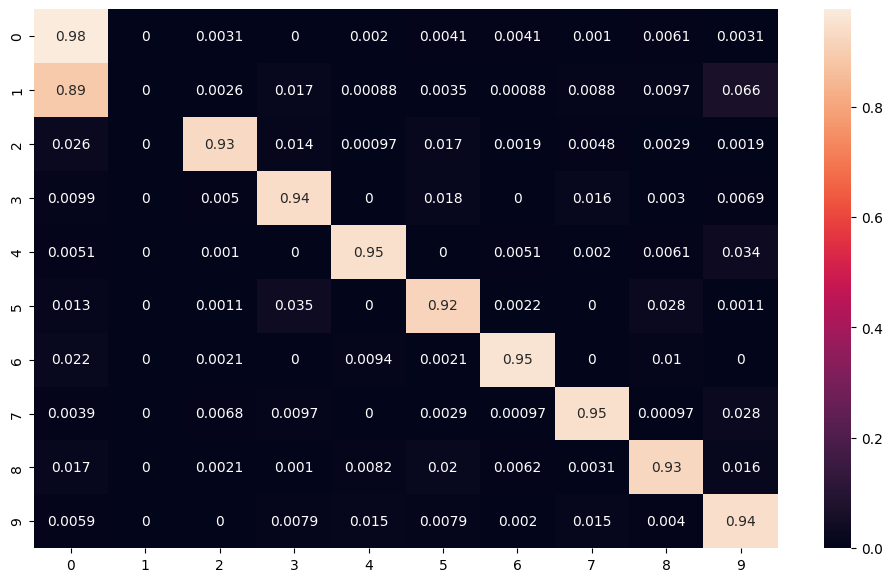

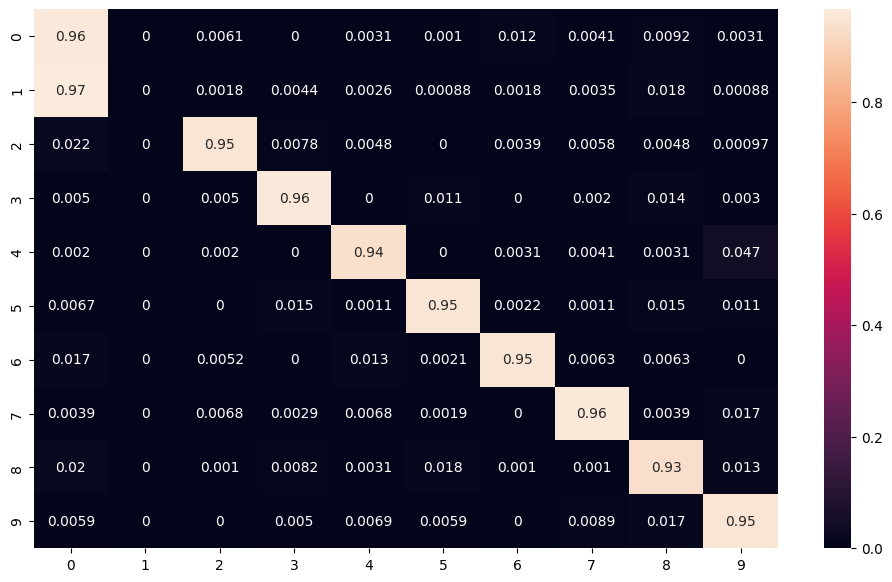

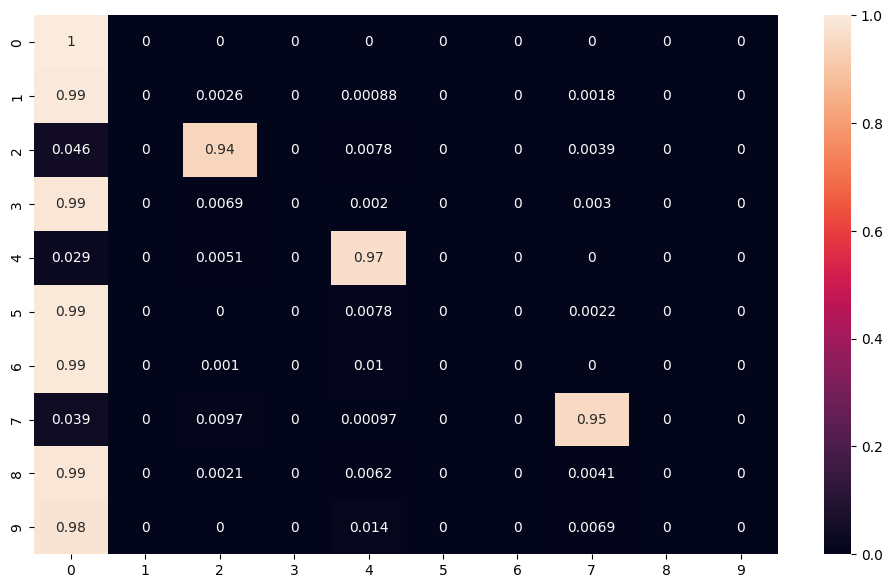

In [9]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=10",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  10
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    # Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

#### Training MLP, depth = 20

Training and evaluating a MPL with depth = 20.

Training epoch 0: 100%|██████████| 430/430 [00:10<00:00, 40.92it/s]


Accuracy of the network: 11.7 %


Training epoch 1: 100%|██████████| 430/430 [00:10<00:00, 42.43it/s]


Accuracy of the network: 21.56 %


Training epoch 2: 100%|██████████| 430/430 [00:10<00:00, 42.31it/s]


Accuracy of the network: 35.66 %


Training epoch 3: 100%|██████████| 430/430 [00:10<00:00, 42.49it/s]


Accuracy of the network: 55.28 %


Training epoch 4: 100%|██████████| 430/430 [00:10<00:00, 42.02it/s]


Accuracy of the network: 56.72 %


Training epoch 5: 100%|██████████| 430/430 [00:09<00:00, 44.63it/s]


Accuracy of the network: 56.86 %


Training epoch 6: 100%|██████████| 430/430 [00:09<00:00, 45.72it/s]


Accuracy of the network: 57.78 %


Training epoch 7: 100%|██████████| 430/430 [00:10<00:00, 42.46it/s]


Accuracy of the network: 57.58 %


Training epoch 8: 100%|██████████| 430/430 [00:10<00:00, 41.96it/s]


Accuracy of the network: 57.4 %


Training epoch 9: 100%|██████████| 430/430 [00:10<00:00, 42.74it/s]


Accuracy of the network: 58.06 %


Training epoch 10: 100%|██████████| 430/430 [00:10<00:00, 42.27it/s]


Accuracy of the network: 58.82 %


Training epoch 11: 100%|██████████| 430/430 [00:10<00:00, 42.13it/s]


Accuracy of the network: 57.7 %


Training epoch 12: 100%|██████████| 430/430 [00:10<00:00, 42.19it/s]


Accuracy of the network: 58.4 %


Training epoch 13: 100%|██████████| 430/430 [00:10<00:00, 41.83it/s]


Accuracy of the network: 58.72 %


Training epoch 14: 100%|██████████| 430/430 [00:10<00:00, 41.73it/s]


Accuracy of the network: 57.9 %


Training epoch 15: 100%|██████████| 430/430 [00:10<00:00, 42.66it/s]


Accuracy of the network: 59.06 %


Training epoch 16: 100%|██████████| 430/430 [00:10<00:00, 42.71it/s]


Accuracy of the network: 59.06 %


Training epoch 17: 100%|██████████| 430/430 [00:10<00:00, 42.44it/s]


Accuracy of the network: 58.9 %


Training epoch 18: 100%|██████████| 430/430 [00:10<00:00, 42.44it/s]


Accuracy of the network: 59.04 %


Training epoch 19: 100%|██████████| 430/430 [00:10<00:00, 42.48it/s]


Accuracy of the network: 59.44 %


Training epoch 20: 100%|██████████| 430/430 [00:10<00:00, 42.61it/s]


Accuracy of the network: 59.18 %


Training epoch 21: 100%|██████████| 430/430 [00:10<00:00, 42.77it/s]


Accuracy of the network: 59.26 %


Training epoch 22: 100%|██████████| 430/430 [00:10<00:00, 42.74it/s]


Accuracy of the network: 59.22 %


Training epoch 23: 100%|██████████| 430/430 [00:10<00:00, 42.40it/s]


Accuracy of the network: 59.26 %


Training epoch 24: 100%|██████████| 430/430 [00:10<00:00, 42.73it/s]


Accuracy of the network: 59.62 %


Training epoch 25: 100%|██████████| 430/430 [00:10<00:00, 41.82it/s]


Accuracy of the network: 58.92 %


Training epoch 26: 100%|██████████| 430/430 [00:10<00:00, 42.38it/s]


Accuracy of the network: 59.64 %


Training epoch 27: 100%|██████████| 430/430 [00:10<00:00, 41.86it/s]


Accuracy of the network: 59.36 %


Training epoch 28: 100%|██████████| 430/430 [00:10<00:00, 42.69it/s]


Accuracy of the network: 59.32 %


Training epoch 29: 100%|██████████| 430/430 [00:10<00:00, 42.31it/s]


Accuracy of the network: 59.04 %


Training epoch 30: 100%|██████████| 430/430 [00:10<00:00, 42.59it/s]


Accuracy of the network: 59.22 %


Training epoch 31: 100%|██████████| 430/430 [00:10<00:00, 42.55it/s]


Accuracy of the network: 59.2 %


Training epoch 32: 100%|██████████| 430/430 [00:10<00:00, 42.53it/s]


Accuracy of the network: 59.38 %


Training epoch 33: 100%|██████████| 430/430 [00:10<00:00, 42.76it/s]


Accuracy of the network: 59.64 %


Training epoch 34: 100%|██████████| 430/430 [00:10<00:00, 42.72it/s]


Accuracy of the network: 59.2 %


Training epoch 35: 100%|██████████| 430/430 [00:10<00:00, 41.87it/s]


Accuracy of the network: 59.46 %


Training epoch 36: 100%|██████████| 430/430 [00:10<00:00, 42.09it/s]


Accuracy of the network: 59.36 %


Training epoch 37: 100%|██████████| 430/430 [00:10<00:00, 42.33it/s]


Accuracy of the network: 59.28 %


Training epoch 38: 100%|██████████| 430/430 [00:10<00:00, 42.12it/s]


Accuracy of the network: 59.62 %


Training epoch 39: 100%|██████████| 430/430 [00:10<00:00, 42.50it/s]


Accuracy of the network: 59.42 %


Training epoch 40: 100%|██████████| 430/430 [00:10<00:00, 41.87it/s]


Accuracy of the network: 59.48 %


Training epoch 41: 100%|██████████| 430/430 [00:10<00:00, 42.34it/s]


Accuracy of the network: 59.38 %


Training epoch 42: 100%|██████████| 430/430 [00:10<00:00, 42.30it/s]


Accuracy of the network: 59.62 %


Training epoch 43: 100%|██████████| 430/430 [00:10<00:00, 41.66it/s]


Accuracy of the network: 59.68 %


Training epoch 44: 100%|██████████| 430/430 [00:10<00:00, 42.10it/s]


Accuracy of the network: 59.54 %


Training epoch 45: 100%|██████████| 430/430 [00:10<00:00, 42.70it/s]


Accuracy of the network: 59.24 %


Training epoch 46: 100%|██████████| 430/430 [00:10<00:00, 42.58it/s]


Accuracy of the network: 59.68 %


Training epoch 47: 100%|██████████| 430/430 [00:10<00:00, 42.53it/s]


Accuracy of the network: 59.48 %


Training epoch 48: 100%|██████████| 430/430 [00:10<00:00, 42.53it/s]


Accuracy of the network: 59.76 %


Training epoch 49: 100%|██████████| 430/430 [00:09<00:00, 44.98it/s]


Accuracy of the network: 59.78 %


Training epoch 50: 100%|██████████| 430/430 [00:10<00:00, 42.64it/s]


Accuracy of the network: 59.64 %


Training epoch 51: 100%|██████████| 430/430 [00:09<00:00, 46.41it/s]


Accuracy of the network: 59.58 %


Training epoch 52: 100%|██████████| 430/430 [00:09<00:00, 44.46it/s]


Accuracy of the network: 59.6 %


Training epoch 53: 100%|██████████| 430/430 [00:09<00:00, 45.02it/s]


Accuracy of the network: 59.78 %


Training epoch 54: 100%|██████████| 430/430 [00:09<00:00, 45.28it/s]


Accuracy of the network: 59.66 %


Training epoch 55: 100%|██████████| 430/430 [00:09<00:00, 45.39it/s]


Accuracy of the network: 59.7 %


Training epoch 56: 100%|██████████| 430/430 [00:09<00:00, 45.14it/s]


Accuracy of the network: 59.7 %


Training epoch 57: 100%|██████████| 430/430 [00:09<00:00, 44.38it/s]


Accuracy of the network: 59.56 %


Training epoch 58: 100%|██████████| 430/430 [00:09<00:00, 45.22it/s]


Accuracy of the network: 59.62 %


Training epoch 59: 100%|██████████| 430/430 [00:09<00:00, 45.06it/s]


Accuracy of the network: 59.56 %


Training epoch 60: 100%|██████████| 430/430 [00:09<00:00, 45.23it/s]


Accuracy of the network: 59.84 %


Training epoch 61: 100%|██████████| 430/430 [00:08<00:00, 48.98it/s]


Accuracy of the network: 59.66 %


Training epoch 62: 100%|██████████| 430/430 [00:08<00:00, 50.57it/s]


Accuracy of the network: 59.72 %


Training epoch 63: 100%|██████████| 430/430 [00:09<00:00, 45.71it/s]


Accuracy of the network: 59.66 %


Training epoch 64: 100%|██████████| 430/430 [00:09<00:00, 46.64it/s]


Accuracy of the network: 59.9 %


Training epoch 65: 100%|██████████| 430/430 [00:09<00:00, 46.46it/s]


Accuracy of the network: 59.54 %


Training epoch 66: 100%|██████████| 430/430 [00:09<00:00, 46.40it/s]


Accuracy of the network: 59.58 %


Training epoch 67: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 59.7 %


Training epoch 68: 100%|██████████| 430/430 [00:09<00:00, 44.34it/s]


Accuracy of the network: 59.88 %


Training epoch 69: 100%|██████████| 430/430 [00:10<00:00, 42.72it/s]


Accuracy of the network: 59.62 %


Training epoch 70: 100%|██████████| 430/430 [00:10<00:00, 42.42it/s]


Accuracy of the network: 59.8 %


Training epoch 71: 100%|██████████| 430/430 [00:10<00:00, 42.81it/s]


Accuracy of the network: 59.8 %


Training epoch 72: 100%|██████████| 430/430 [00:10<00:00, 42.75it/s]


Accuracy of the network: 59.92 %


Training epoch 73: 100%|██████████| 430/430 [00:10<00:00, 42.81it/s]


Accuracy of the network: 59.84 %


Training epoch 74: 100%|██████████| 430/430 [00:10<00:00, 42.88it/s]


Accuracy of the network: 59.68 %


Training epoch 75: 100%|██████████| 430/430 [00:10<00:00, 42.71it/s]


Accuracy of the network: 59.7 %


Training epoch 76: 100%|██████████| 430/430 [00:10<00:00, 42.79it/s]


Accuracy of the network: 59.76 %


Training epoch 77: 100%|██████████| 430/430 [00:10<00:00, 42.57it/s]


Accuracy of the network: 60.0 %


Training epoch 78: 100%|██████████| 430/430 [00:10<00:00, 42.69it/s]


Accuracy of the network: 59.64 %


Training epoch 79: 100%|██████████| 430/430 [00:10<00:00, 42.35it/s]


Accuracy of the network: 59.82 %


Training epoch 80: 100%|██████████| 430/430 [00:10<00:00, 42.58it/s]


Accuracy of the network: 59.82 %


Training epoch 81: 100%|██████████| 430/430 [00:10<00:00, 41.78it/s]


Accuracy of the network: 59.72 %


Training epoch 82: 100%|██████████| 430/430 [00:10<00:00, 42.67it/s]


Accuracy of the network: 59.62 %


Training epoch 83: 100%|██████████| 430/430 [00:10<00:00, 42.79it/s]


Accuracy of the network: 59.7 %


Training epoch 84: 100%|██████████| 430/430 [00:10<00:00, 42.10it/s]


Accuracy of the network: 59.76 %


Training epoch 85: 100%|██████████| 430/430 [00:10<00:00, 42.29it/s]


Accuracy of the network: 59.36 %


Training epoch 86: 100%|██████████| 430/430 [00:10<00:00, 42.53it/s]


Accuracy of the network: 59.88 %


Training epoch 87: 100%|██████████| 430/430 [00:10<00:00, 42.60it/s]


Accuracy of the network: 59.86 %


Training epoch 88: 100%|██████████| 430/430 [00:10<00:00, 42.39it/s]


Accuracy of the network: 59.76 %


Training epoch 89: 100%|██████████| 430/430 [00:10<00:00, 42.43it/s]


Accuracy of the network: 59.52 %


Training epoch 90: 100%|██████████| 430/430 [00:10<00:00, 42.33it/s]


Accuracy of the network: 59.92 %


Training epoch 91: 100%|██████████| 430/430 [00:11<00:00, 38.20it/s]


Accuracy of the network: 59.96 %


Training epoch 92: 100%|██████████| 430/430 [00:10<00:00, 42.38it/s]


Accuracy of the network: 59.76 %


Training epoch 93: 100%|██████████| 430/430 [00:10<00:00, 42.22it/s]


Accuracy of the network: 60.12 %


Training epoch 94: 100%|██████████| 430/430 [00:10<00:00, 42.42it/s]


Accuracy of the network: 59.64 %


Training epoch 95: 100%|██████████| 430/430 [00:10<00:00, 42.53it/s]


Accuracy of the network: 59.92 %


Training epoch 96: 100%|██████████| 430/430 [00:10<00:00, 42.11it/s]


Accuracy of the network: 59.84 %


Training epoch 97: 100%|██████████| 430/430 [00:10<00:00, 42.30it/s]


Accuracy of the network: 59.54 %


Training epoch 98: 100%|██████████| 430/430 [00:10<00:00, 42.28it/s]


Accuracy of the network: 59.8 %


Training epoch 99: 100%|██████████| 430/430 [00:10<00:00, 42.24it/s]


Accuracy of the network: 60.04 %
Test accuracy of the network: 59.15 %


test_accuracy,▁
train_loss,█▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄██████████████████████████████████████
validation_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.5915
train_loss,0.92811
validation_accuracy,0.6012
validation_loss,1.00396


Training epoch 0: 100%|██████████| 430/430 [00:10<00:00, 39.48it/s]


Accuracy of the network: 10.12 %


Training epoch 1: 100%|██████████| 430/430 [00:10<00:00, 41.77it/s]


Accuracy of the network: 41.14 %


Training epoch 2: 100%|██████████| 430/430 [00:10<00:00, 42.82it/s]


Accuracy of the network: 52.34 %


Training epoch 3: 100%|██████████| 430/430 [00:10<00:00, 42.52it/s]


Accuracy of the network: 57.76 %


Training epoch 4: 100%|██████████| 430/430 [00:10<00:00, 42.70it/s]


Accuracy of the network: 59.34 %


Training epoch 5: 100%|██████████| 430/430 [00:10<00:00, 41.29it/s]


Accuracy of the network: 60.9 %


Training epoch 6: 100%|██████████| 430/430 [00:10<00:00, 41.04it/s]


Accuracy of the network: 61.1 %


Training epoch 7: 100%|██████████| 430/430 [00:10<00:00, 42.66it/s]


Accuracy of the network: 59.58 %


Training epoch 8: 100%|██████████| 430/430 [00:10<00:00, 40.07it/s]


Accuracy of the network: 62.42 %


Training epoch 9: 100%|██████████| 430/430 [00:10<00:00, 42.15it/s]


Accuracy of the network: 61.22 %


Training epoch 10: 100%|██████████| 430/430 [00:10<00:00, 42.69it/s]


Accuracy of the network: 62.66 %


Training epoch 11: 100%|██████████| 430/430 [00:10<00:00, 42.54it/s]


Accuracy of the network: 63.1 %


Training epoch 12: 100%|██████████| 430/430 [00:10<00:00, 42.37it/s]


Accuracy of the network: 63.04 %


Training epoch 13: 100%|██████████| 430/430 [00:10<00:00, 41.72it/s]


Accuracy of the network: 63.16 %


Training epoch 14: 100%|██████████| 430/430 [00:10<00:00, 42.25it/s]


Accuracy of the network: 63.5 %


Training epoch 15: 100%|██████████| 430/430 [00:10<00:00, 42.51it/s]


Accuracy of the network: 63.74 %


Training epoch 16: 100%|██████████| 430/430 [00:10<00:00, 42.62it/s]


Accuracy of the network: 63.4 %


Training epoch 17: 100%|██████████| 430/430 [00:10<00:00, 42.73it/s]


Accuracy of the network: 63.92 %


Training epoch 18: 100%|██████████| 430/430 [00:10<00:00, 42.61it/s]


Accuracy of the network: 63.82 %


Training epoch 19: 100%|██████████| 430/430 [00:10<00:00, 42.64it/s]


Accuracy of the network: 63.82 %


Training epoch 20: 100%|██████████| 430/430 [00:10<00:00, 42.74it/s]


Accuracy of the network: 64.26 %


Training epoch 21: 100%|██████████| 430/430 [00:10<00:00, 42.25it/s]


Accuracy of the network: 64.34 %


Training epoch 22: 100%|██████████| 430/430 [00:09<00:00, 44.46it/s]


Accuracy of the network: 64.46 %


Training epoch 23: 100%|██████████| 430/430 [00:09<00:00, 46.51it/s]


Accuracy of the network: 64.74 %


Training epoch 24: 100%|██████████| 430/430 [00:09<00:00, 46.43it/s]


Accuracy of the network: 64.56 %


Training epoch 25: 100%|██████████| 430/430 [00:09<00:00, 45.24it/s]


Accuracy of the network: 64.58 %


Training epoch 26: 100%|██████████| 430/430 [00:09<00:00, 45.74it/s]


Accuracy of the network: 64.7 %


Training epoch 27: 100%|██████████| 430/430 [00:09<00:00, 44.92it/s]


Accuracy of the network: 64.98 %


Training epoch 28: 100%|██████████| 430/430 [00:09<00:00, 45.25it/s]


Accuracy of the network: 64.62 %


Training epoch 29: 100%|██████████| 430/430 [00:09<00:00, 45.44it/s]


Accuracy of the network: 64.66 %


Training epoch 30: 100%|██████████| 430/430 [00:09<00:00, 45.56it/s]


Accuracy of the network: 64.08 %


Training epoch 31: 100%|██████████| 430/430 [00:09<00:00, 45.11it/s]


Accuracy of the network: 64.96 %


Training epoch 32: 100%|██████████| 430/430 [00:09<00:00, 44.44it/s]


Accuracy of the network: 64.72 %


Training epoch 33: 100%|██████████| 430/430 [00:09<00:00, 45.37it/s]


Accuracy of the network: 64.96 %


Training epoch 34: 100%|██████████| 430/430 [00:09<00:00, 45.26it/s]


Accuracy of the network: 64.92 %


Training epoch 35: 100%|██████████| 430/430 [00:09<00:00, 46.32it/s]


Accuracy of the network: 64.6 %


Training epoch 36: 100%|██████████| 430/430 [00:09<00:00, 45.64it/s]


Accuracy of the network: 64.94 %


Training epoch 37: 100%|██████████| 430/430 [00:09<00:00, 46.04it/s]


Accuracy of the network: 65.24 %


Training epoch 38: 100%|██████████| 430/430 [00:09<00:00, 45.94it/s]


Accuracy of the network: 64.78 %


Training epoch 39: 100%|██████████| 430/430 [00:09<00:00, 46.52it/s]


Accuracy of the network: 65.0 %


Training epoch 40: 100%|██████████| 430/430 [00:09<00:00, 46.57it/s]


Accuracy of the network: 65.14 %


Training epoch 41: 100%|██████████| 430/430 [00:09<00:00, 46.03it/s]


Accuracy of the network: 64.82 %


Training epoch 42: 100%|██████████| 430/430 [00:09<00:00, 46.39it/s]


Accuracy of the network: 65.14 %


Training epoch 43: 100%|██████████| 430/430 [00:09<00:00, 44.44it/s]


Accuracy of the network: 65.1 %


Training epoch 44: 100%|██████████| 430/430 [00:09<00:00, 46.51it/s]


Accuracy of the network: 65.06 %


Training epoch 45: 100%|██████████| 430/430 [00:09<00:00, 44.91it/s]


Accuracy of the network: 65.34 %


Training epoch 46: 100%|██████████| 430/430 [00:09<00:00, 46.24it/s]


Accuracy of the network: 65.18 %


Training epoch 47: 100%|██████████| 430/430 [00:09<00:00, 45.94it/s]


Accuracy of the network: 65.18 %


Training epoch 48: 100%|██████████| 430/430 [00:09<00:00, 46.32it/s]


Accuracy of the network: 64.6 %


Training epoch 49: 100%|██████████| 430/430 [00:09<00:00, 45.32it/s]


Accuracy of the network: 65.18 %


Training epoch 50: 100%|██████████| 430/430 [00:09<00:00, 46.54it/s]


Accuracy of the network: 65.36 %


Training epoch 51: 100%|██████████| 430/430 [00:09<00:00, 46.75it/s]


Accuracy of the network: 65.34 %


Training epoch 52: 100%|██████████| 430/430 [00:09<00:00, 46.70it/s]


Accuracy of the network: 65.52 %


Training epoch 53: 100%|██████████| 430/430 [00:09<00:00, 46.67it/s]


Accuracy of the network: 74.54 %


Training epoch 54: 100%|██████████| 430/430 [00:09<00:00, 43.97it/s]


Accuracy of the network: 74.06 %


Training epoch 55: 100%|██████████| 430/430 [00:09<00:00, 43.94it/s]


Accuracy of the network: 74.56 %


Training epoch 56: 100%|██████████| 430/430 [00:09<00:00, 46.73it/s]


Accuracy of the network: 74.22 %


Training epoch 57: 100%|██████████| 430/430 [00:09<00:00, 46.29it/s]


Accuracy of the network: 73.74 %


Training epoch 58: 100%|██████████| 430/430 [00:09<00:00, 45.80it/s]


Accuracy of the network: 74.16 %


Training epoch 59: 100%|██████████| 430/430 [00:09<00:00, 46.65it/s]


Accuracy of the network: 74.04 %


Training epoch 60: 100%|██████████| 430/430 [00:09<00:00, 46.44it/s]


Accuracy of the network: 74.62 %


Training epoch 61: 100%|██████████| 430/430 [00:09<00:00, 46.43it/s]


Accuracy of the network: 74.32 %


Training epoch 62: 100%|██████████| 430/430 [00:09<00:00, 45.26it/s]


Accuracy of the network: 74.34 %


Training epoch 63: 100%|██████████| 430/430 [00:09<00:00, 46.44it/s]


Accuracy of the network: 73.58 %


Training epoch 64: 100%|██████████| 430/430 [00:09<00:00, 46.37it/s]


Accuracy of the network: 74.4 %


Training epoch 65: 100%|██████████| 430/430 [00:09<00:00, 46.55it/s]


Accuracy of the network: 74.6 %


Training epoch 66: 100%|██████████| 430/430 [00:09<00:00, 46.61it/s]


Accuracy of the network: 74.34 %


Training epoch 67: 100%|██████████| 430/430 [00:09<00:00, 46.42it/s]


Accuracy of the network: 74.62 %


Training epoch 68: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 74.84 %


Training epoch 69: 100%|██████████| 430/430 [00:09<00:00, 46.46it/s]


Accuracy of the network: 74.8 %


Training epoch 70: 100%|██████████| 430/430 [00:09<00:00, 46.23it/s]


Accuracy of the network: 74.68 %


Training epoch 71: 100%|██████████| 430/430 [00:09<00:00, 46.61it/s]


Accuracy of the network: 74.66 %


Training epoch 72: 100%|██████████| 430/430 [00:09<00:00, 46.58it/s]


Accuracy of the network: 74.86 %


Training epoch 73: 100%|██████████| 430/430 [00:09<00:00, 46.63it/s]


Accuracy of the network: 74.6 %


Training epoch 74: 100%|██████████| 430/430 [00:09<00:00, 46.37it/s]


Accuracy of the network: 74.86 %


Training epoch 75: 100%|██████████| 430/430 [00:09<00:00, 46.64it/s]


Accuracy of the network: 75.0 %


Training epoch 76: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 75.0 %


Training epoch 77: 100%|██████████| 430/430 [00:09<00:00, 44.32it/s]


Accuracy of the network: 74.9 %


Training epoch 78: 100%|██████████| 430/430 [00:09<00:00, 46.62it/s]


Accuracy of the network: 74.72 %


Training epoch 79: 100%|██████████| 430/430 [00:09<00:00, 46.17it/s]


Accuracy of the network: 74.98 %


Training epoch 80: 100%|██████████| 430/430 [00:09<00:00, 46.18it/s]


Accuracy of the network: 74.76 %


Training epoch 81: 100%|██████████| 430/430 [00:09<00:00, 46.68it/s]


Accuracy of the network: 74.96 %


Training epoch 82: 100%|██████████| 430/430 [00:09<00:00, 45.65it/s]


Accuracy of the network: 74.82 %


Training epoch 83: 100%|██████████| 430/430 [00:09<00:00, 46.56it/s]


Accuracy of the network: 74.94 %


Training epoch 84: 100%|██████████| 430/430 [00:09<00:00, 46.40it/s]


Accuracy of the network: 75.12 %


Training epoch 85: 100%|██████████| 430/430 [00:09<00:00, 45.23it/s]


Accuracy of the network: 75.16 %


Training epoch 86: 100%|██████████| 430/430 [00:09<00:00, 46.65it/s]


Accuracy of the network: 74.92 %


Training epoch 87: 100%|██████████| 430/430 [00:09<00:00, 45.05it/s]


Accuracy of the network: 74.98 %


Training epoch 88: 100%|██████████| 430/430 [00:09<00:00, 45.84it/s]


Accuracy of the network: 74.82 %


Training epoch 89: 100%|██████████| 430/430 [00:09<00:00, 46.60it/s]


Accuracy of the network: 75.06 %


Training epoch 90: 100%|██████████| 430/430 [00:09<00:00, 43.86it/s]


Accuracy of the network: 74.28 %


Training epoch 91: 100%|██████████| 430/430 [00:09<00:00, 46.58it/s]


Accuracy of the network: 75.34 %


Training epoch 92: 100%|██████████| 430/430 [00:09<00:00, 46.33it/s]


Accuracy of the network: 75.12 %


Training epoch 93: 100%|██████████| 430/430 [00:09<00:00, 46.23it/s]


Accuracy of the network: 75.1 %


Training epoch 94: 100%|██████████| 430/430 [00:09<00:00, 46.53it/s]


Accuracy of the network: 74.98 %


Training epoch 95: 100%|██████████| 430/430 [00:09<00:00, 46.17it/s]


Accuracy of the network: 74.92 %


Training epoch 96: 100%|██████████| 430/430 [00:09<00:00, 46.61it/s]


Accuracy of the network: 74.82 %


Training epoch 97: 100%|██████████| 430/430 [00:09<00:00, 46.46it/s]


Accuracy of the network: 75.42 %


Training epoch 98: 100%|██████████| 430/430 [00:09<00:00, 46.55it/s]


Accuracy of the network: 75.24 %


Training epoch 99: 100%|██████████| 430/430 [00:09<00:00, 46.54it/s]


Accuracy of the network: 75.34 %
Test accuracy of the network: 75.34 %


test_accuracy,▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
validation_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.7534
train_loss,0.53765
validation_accuracy,0.7542
validation_loss,0.66055


Training epoch 0: 100%|██████████| 430/430 [00:09<00:00, 45.14it/s]


Accuracy of the network: 11.04 %


Training epoch 1: 100%|██████████| 430/430 [00:09<00:00, 46.69it/s]


Accuracy of the network: 11.04 %


Training epoch 2: 100%|██████████| 430/430 [00:09<00:00, 46.37it/s]


Accuracy of the network: 31.78 %


Training epoch 3: 100%|██████████| 430/430 [00:09<00:00, 46.54it/s]


Accuracy of the network: 34.34 %


Training epoch 4: 100%|██████████| 430/430 [00:09<00:00, 45.39it/s]


Accuracy of the network: 38.36 %


Training epoch 5: 100%|██████████| 430/430 [00:09<00:00, 45.76it/s]


Accuracy of the network: 45.1 %


Training epoch 6: 100%|██████████| 430/430 [00:09<00:00, 46.20it/s]


Accuracy of the network: 57.56 %


Training epoch 7: 100%|██████████| 430/430 [00:09<00:00, 46.49it/s]


Accuracy of the network: 59.04 %


Training epoch 8: 100%|██████████| 430/430 [00:09<00:00, 43.94it/s]


Accuracy of the network: 59.76 %


Training epoch 9: 100%|██████████| 430/430 [00:09<00:00, 45.59it/s]


Accuracy of the network: 60.48 %


Training epoch 10: 100%|██████████| 430/430 [00:09<00:00, 44.29it/s]


Accuracy of the network: 61.28 %


Training epoch 11: 100%|██████████| 430/430 [00:09<00:00, 45.81it/s]


Accuracy of the network: 60.5 %


Training epoch 12: 100%|██████████| 430/430 [00:09<00:00, 44.13it/s]


Accuracy of the network: 61.58 %


Training epoch 13: 100%|██████████| 430/430 [00:09<00:00, 46.15it/s]


Accuracy of the network: 62.12 %


Training epoch 14: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 61.96 %


Training epoch 15: 100%|██████████| 430/430 [00:09<00:00, 45.20it/s]


Accuracy of the network: 62.5 %


Training epoch 16: 100%|██████████| 430/430 [00:09<00:00, 46.71it/s]


Accuracy of the network: 61.96 %


Training epoch 17: 100%|██████████| 430/430 [00:09<00:00, 46.69it/s]


Accuracy of the network: 63.02 %


Training epoch 18: 100%|██████████| 430/430 [00:09<00:00, 46.56it/s]


Accuracy of the network: 63.0 %


Training epoch 19: 100%|██████████| 430/430 [00:09<00:00, 46.19it/s]


Accuracy of the network: 63.34 %


Training epoch 20: 100%|██████████| 430/430 [00:09<00:00, 46.53it/s]


Accuracy of the network: 63.32 %


Training epoch 21: 100%|██████████| 430/430 [00:09<00:00, 46.68it/s]


Accuracy of the network: 63.46 %


Training epoch 22: 100%|██████████| 430/430 [00:09<00:00, 46.37it/s]


Accuracy of the network: 63.12 %


Training epoch 23: 100%|██████████| 430/430 [00:09<00:00, 46.48it/s]


Accuracy of the network: 63.86 %


Training epoch 24: 100%|██████████| 430/430 [00:09<00:00, 46.69it/s]


Accuracy of the network: 63.62 %


Training epoch 25: 100%|██████████| 430/430 [00:09<00:00, 45.81it/s]


Accuracy of the network: 63.98 %


Training epoch 26: 100%|██████████| 430/430 [00:09<00:00, 46.56it/s]


Accuracy of the network: 63.84 %


Training epoch 27: 100%|██████████| 430/430 [00:09<00:00, 46.57it/s]


Accuracy of the network: 63.74 %


Training epoch 28: 100%|██████████| 430/430 [00:09<00:00, 46.62it/s]


Accuracy of the network: 64.22 %


Training epoch 29: 100%|██████████| 430/430 [00:09<00:00, 46.73it/s]


Accuracy of the network: 64.22 %


Training epoch 30: 100%|██████████| 430/430 [00:09<00:00, 46.69it/s]


Accuracy of the network: 64.18 %


Training epoch 31: 100%|██████████| 430/430 [00:09<00:00, 46.69it/s]


Accuracy of the network: 63.56 %


Training epoch 32: 100%|██████████| 430/430 [00:09<00:00, 46.55it/s]


Accuracy of the network: 64.06 %


Training epoch 33: 100%|██████████| 430/430 [00:09<00:00, 46.66it/s]


Accuracy of the network: 64.42 %


Training epoch 34: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 64.46 %


Training epoch 35: 100%|██████████| 430/430 [00:09<00:00, 46.40it/s]


Accuracy of the network: 64.22 %


Training epoch 36: 100%|██████████| 430/430 [00:09<00:00, 46.66it/s]


Accuracy of the network: 64.54 %


Training epoch 37: 100%|██████████| 430/430 [00:09<00:00, 46.67it/s]


Accuracy of the network: 64.46 %


Training epoch 38: 100%|██████████| 430/430 [00:09<00:00, 46.59it/s]


Accuracy of the network: 64.72 %


Training epoch 39: 100%|██████████| 430/430 [00:09<00:00, 46.74it/s]


Accuracy of the network: 64.36 %


Training epoch 40: 100%|██████████| 430/430 [00:09<00:00, 46.75it/s]


Accuracy of the network: 64.98 %


Training epoch 41: 100%|██████████| 430/430 [00:09<00:00, 46.72it/s]


Accuracy of the network: 64.82 %


Training epoch 42: 100%|██████████| 430/430 [00:09<00:00, 45.10it/s]


Accuracy of the network: 64.72 %


Training epoch 43: 100%|██████████| 430/430 [00:09<00:00, 46.70it/s]


Accuracy of the network: 65.02 %


Training epoch 44: 100%|██████████| 430/430 [00:09<00:00, 46.72it/s]


Accuracy of the network: 65.24 %


Training epoch 45: 100%|██████████| 430/430 [00:09<00:00, 46.49it/s]


Accuracy of the network: 65.2 %


Training epoch 46: 100%|██████████| 430/430 [00:09<00:00, 46.65it/s]


Accuracy of the network: 65.2 %


Training epoch 47: 100%|██████████| 430/430 [00:09<00:00, 46.78it/s]


Accuracy of the network: 65.32 %


Training epoch 48: 100%|██████████| 430/430 [00:09<00:00, 46.77it/s]


Accuracy of the network: 65.22 %


Training epoch 49: 100%|██████████| 430/430 [00:09<00:00, 46.55it/s]


Accuracy of the network: 64.88 %


Training epoch 50: 100%|██████████| 430/430 [00:09<00:00, 46.54it/s]


Accuracy of the network: 64.96 %


Training epoch 51: 100%|██████████| 430/430 [00:09<00:00, 46.70it/s]


Accuracy of the network: 65.1 %


Training epoch 52: 100%|██████████| 430/430 [00:09<00:00, 46.03it/s]


Accuracy of the network: 65.16 %


Training epoch 53: 100%|██████████| 430/430 [00:09<00:00, 44.91it/s]


Accuracy of the network: 65.38 %


Training epoch 54: 100%|██████████| 430/430 [00:09<00:00, 46.37it/s]


Accuracy of the network: 65.5 %


Training epoch 55: 100%|██████████| 430/430 [00:09<00:00, 46.19it/s]


Accuracy of the network: 65.28 %


Training epoch 56: 100%|██████████| 430/430 [00:09<00:00, 46.54it/s]


Accuracy of the network: 65.28 %


Training epoch 57: 100%|██████████| 430/430 [00:09<00:00, 46.41it/s]


Accuracy of the network: 65.3 %


Training epoch 58: 100%|██████████| 430/430 [00:09<00:00, 46.06it/s]


Accuracy of the network: 65.54 %


Training epoch 59: 100%|██████████| 430/430 [00:09<00:00, 46.64it/s]


Accuracy of the network: 65.56 %


Training epoch 60: 100%|██████████| 430/430 [00:09<00:00, 46.49it/s]


Accuracy of the network: 65.34 %


Training epoch 61: 100%|██████████| 430/430 [00:09<00:00, 46.49it/s]


Accuracy of the network: 65.32 %


Training epoch 62: 100%|██████████| 430/430 [00:09<00:00, 46.43it/s]


Accuracy of the network: 65.52 %


Training epoch 63: 100%|██████████| 430/430 [00:09<00:00, 46.68it/s]


Accuracy of the network: 65.6 %


Training epoch 64: 100%|██████████| 430/430 [00:09<00:00, 46.72it/s]


Accuracy of the network: 65.64 %


Training epoch 65: 100%|██████████| 430/430 [00:09<00:00, 46.49it/s]


Accuracy of the network: 65.66 %


Training epoch 66: 100%|██████████| 430/430 [00:09<00:00, 46.68it/s]


Accuracy of the network: 65.88 %


Training epoch 67: 100%|██████████| 430/430 [00:09<00:00, 46.75it/s]


Accuracy of the network: 66.3 %


Training epoch 68: 100%|██████████| 430/430 [00:09<00:00, 46.36it/s]


Accuracy of the network: 66.14 %


Training epoch 69: 100%|██████████| 430/430 [00:09<00:00, 46.76it/s]


Accuracy of the network: 65.68 %


Training epoch 70: 100%|██████████| 430/430 [00:09<00:00, 46.51it/s]


Accuracy of the network: 65.76 %


Training epoch 71: 100%|██████████| 430/430 [00:09<00:00, 46.63it/s]


Accuracy of the network: 65.98 %


Training epoch 72: 100%|██████████| 430/430 [00:09<00:00, 46.10it/s]


Accuracy of the network: 66.22 %


Training epoch 73: 100%|██████████| 430/430 [00:09<00:00, 46.63it/s]


Accuracy of the network: 66.18 %


Training epoch 74: 100%|██████████| 430/430 [00:09<00:00, 46.63it/s]


Accuracy of the network: 66.2 %


Training epoch 75: 100%|██████████| 430/430 [00:09<00:00, 46.34it/s]


Accuracy of the network: 65.66 %


Training epoch 76: 100%|██████████| 430/430 [00:09<00:00, 46.67it/s]


Accuracy of the network: 66.08 %


Training epoch 77: 100%|██████████| 430/430 [00:09<00:00, 46.63it/s]


Accuracy of the network: 66.24 %


Training epoch 78: 100%|██████████| 430/430 [00:09<00:00, 46.38it/s]


Accuracy of the network: 66.32 %


Training epoch 79: 100%|██████████| 430/430 [00:09<00:00, 46.57it/s]


Accuracy of the network: 65.76 %


Training epoch 80: 100%|██████████| 430/430 [00:09<00:00, 44.44it/s]


Accuracy of the network: 65.76 %


Training epoch 81: 100%|██████████| 430/430 [00:09<00:00, 46.39it/s]


Accuracy of the network: 66.24 %


Training epoch 82: 100%|██████████| 430/430 [00:09<00:00, 46.41it/s]


Accuracy of the network: 66.04 %


Training epoch 83: 100%|██████████| 430/430 [00:09<00:00, 46.46it/s]


Accuracy of the network: 66.26 %


Training epoch 84: 100%|██████████| 430/430 [00:09<00:00, 46.66it/s]


Accuracy of the network: 66.3 %


Training epoch 85: 100%|██████████| 430/430 [00:09<00:00, 46.22it/s]


Accuracy of the network: 66.24 %


Training epoch 86: 100%|██████████| 430/430 [00:09<00:00, 46.52it/s]


Accuracy of the network: 66.54 %


Training epoch 87: 100%|██████████| 430/430 [00:09<00:00, 46.34it/s]


Accuracy of the network: 66.24 %


Training epoch 88: 100%|██████████| 430/430 [00:09<00:00, 43.59it/s]


Accuracy of the network: 66.38 %


Training epoch 89: 100%|██████████| 430/430 [00:09<00:00, 45.96it/s]


Accuracy of the network: 66.3 %


Training epoch 90: 100%|██████████| 430/430 [00:09<00:00, 46.62it/s]


Accuracy of the network: 66.16 %


Training epoch 91: 100%|██████████| 430/430 [00:09<00:00, 46.53it/s]


Accuracy of the network: 66.38 %


Training epoch 92: 100%|██████████| 430/430 [00:09<00:00, 46.27it/s]


Accuracy of the network: 66.06 %


Training epoch 93: 100%|██████████| 430/430 [00:09<00:00, 46.48it/s]


Accuracy of the network: 66.22 %


Training epoch 94: 100%|██████████| 430/430 [00:09<00:00, 46.58it/s]


Accuracy of the network: 66.36 %


Training epoch 95: 100%|██████████| 430/430 [00:09<00:00, 46.28it/s]


Accuracy of the network: 66.14 %


Training epoch 96: 100%|██████████| 430/430 [00:09<00:00, 45.94it/s]


Accuracy of the network: 65.94 %


Training epoch 97: 100%|██████████| 430/430 [00:09<00:00, 45.40it/s]


Accuracy of the network: 65.72 %


Training epoch 98: 100%|██████████| 430/430 [00:10<00:00, 42.09it/s]


Accuracy of the network: 66.38 %


Training epoch 99: 100%|██████████| 430/430 [00:09<00:00, 46.26it/s]


Accuracy of the network: 66.42 %
Test accuracy of the network: 65.61 %


test_accuracy,▁
train_loss,█▆▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▇▇▇▇█████████████████████████████████
validation_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.6561
train_loss,0.97511
validation_accuracy,0.6654
validation_loss,1.04789


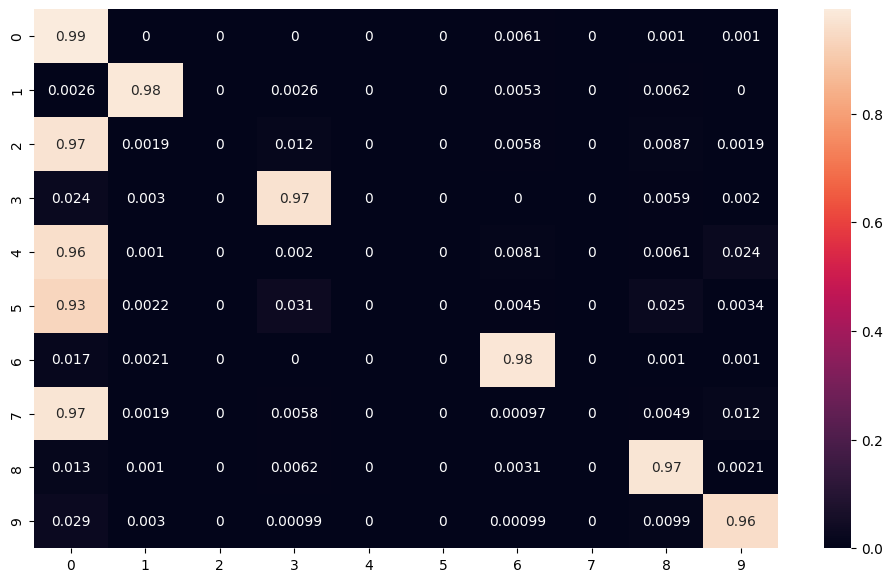

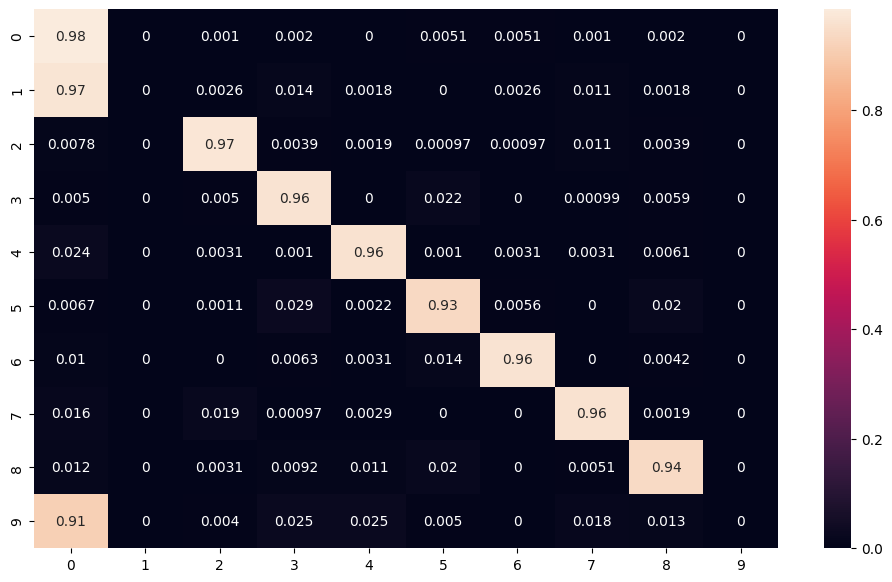

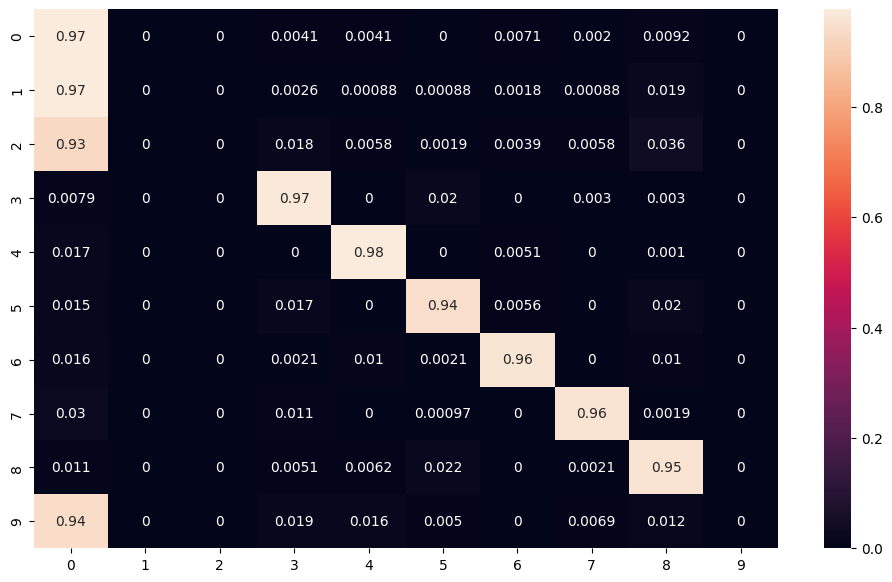

In [10]:
#random seeds, to reproduce the same results
seeds = [2, 32, 3000]
for i in range(len(seeds)):

    torch.manual_seed(seeds[i])

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
        project="Lab1-MLP-lower-lr",
        name = "depth=20",
        config={
            "epochs": 100,
            "batch_size": 128,
            "lr": 0.0001,
            "input_size": 28*28,
            "width":  64,
            "depth":  20
            })

    # Copy the configuration
    config = wandb.config

    # choose the device
    device = 'cuda'

    # Dataloaders.
    dl_train_MNIST = torch.utils.data.DataLoader(MNIST_train, config.batch_size, shuffle=True )
    dl_val_MNIST   = torch.utils.data.DataLoader(MNIST_val, config.batch_size)
    dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, config.batch_size, shuffle=True)

    # Instantiate model and optimizer.
    model_mlp = MLP(config.input_size, [config.width]*config.depth + [len(MNIST_train.dataset.classes)]).to(device)
    optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)

    # Save the model with the greatest validation accuracy as the best model overall
    model_state_dict = None
    best_acc=0
    # Training loop.
    for epoch in range(config.epochs):
        train_loss = train_epoch(model_mlp, dl_train_MNIST, optimizer, epoch, device=device)
        train_metrics = {"train_loss": train_loss}
        val_loss, val_acc = evaluate_model(model_mlp, dl_val_MNIST, device=device)
        # Select the best model
        if val_acc> best_acc:
            best_acc=val_acc
            # Save all the parameters of the model
            model_state_dict = model_mlp.state_dict()
            val_metrics = {"validation_loss": val_loss,
                            "validation_accuracy": val_acc}
        # Log the metrics on weights and biases
        wandb.log({**train_metrics, **val_metrics})

    # Load saved weights of the best model
    model_mlp.load_state_dict(model_state_dict)

    # Save the best model on weights and biases as an artifact
    model_artifact = wandb.Artifact(
                "MLP_depth_" + str(config.depth)+'_seed_'+ str(seeds[i]), type="model",
                description="best model for Lab1-MLP depth "+ str(config.depth),
                metadata=dict(config))

    torch.save(model_mlp.state_dict(), "best_model.pth")
    model_artifact.add_file("best_model.pth")
    wandb.save("best_model.pth")
    run.log_artifact(model_artifact)

    #test evaluation on the best model
    test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)
    test_metric= {"test_accuracy": test_accuracy}
    wandb.log({**test_metric})
    # Close wandb run
    wandb.finish()

## Retrieving model weights and biases

In [ ]:
device = 'cuda'
dl_test_MNIST   = torch.utils.data.DataLoader(MNIST_test, 128, shuffle=True)
model_mlp = MLP(28*28, [64]*1 + [len(MNIST_train.dataset.classes)]).to(device)


classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
run = wandb.init()


artifact = run.use_artifact('Lab1-MLP/MLP_depth_1:v6', type='model')
artifact_dir = artifact.download()


run.finish()

wandb: Currently logged in as: marco-chisci (marcouni). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [ ]:
artifact_dir+'/best_model.pth'

'/content/artifacts/MLP_depth_1:v6best_model.pth'

In [ ]:
model_mlp.load_state_dict(torch.load(artifact_dir+'/best_model.pth'))

<All keys matched successfully>

Test accuracy of the network: 87.92 %
Accuracy report:
               precision    recall  f1-score   support

           0      0.501     0.994     0.666       980
           1      0.982     0.992     0.987      1135
           2      0.972     0.976     0.974      1032
           3      0.959     0.981     0.970      1010
           4      0.969     0.981     0.975       982
           5      0.968     0.970     0.969       892
           6      0.985     0.975     0.980       958
           7      0.968     0.966     0.967      1028
           8      0.961     0.964     0.963       974
           9      0.000     0.000     0.000      1009

    accuracy                          0.879     10000
   macro avg      0.826     0.880     0.845     10000
weighted avg      0.827     0.879     0.845     10000



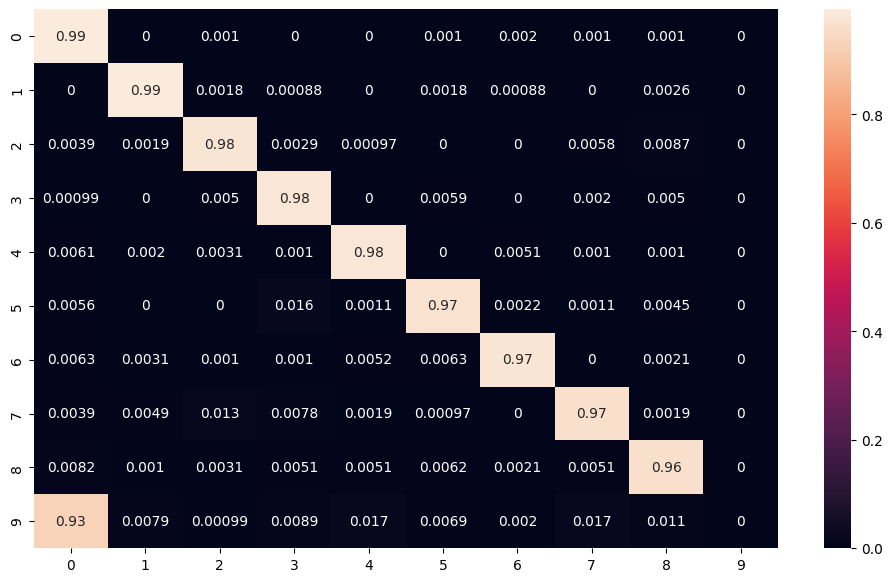

In [ ]:
test_accuracy = test_evaluation(model_mlp, dl_test_MNIST, classes= classes, device = device)


## Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

### Data preparation Cifar10



In [5]:
from torchvision.datasets import CIFAR10

#data augmentation to improve training
transform_training=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomAffine(degrees= 10, scale=(0.8,1.2)),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        transforms.RandomCrop(size=28),
                        transforms.Resize((32,32)),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                        ])

# Standard CIFAR10 transform for test images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

# Load CIFAR10 train and test.
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_training)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(cifar10_train))
cifar10_val = Subset(cifar10_train, I[:val_size])
cifar10_train = Subset(cifar10_train, I[val_size:])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
len(cifar10_val), len(cifar10_test)

(5000, 10000)

In [13]:
len(cifar10_train)

45000

#### Parameterized CNN

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample= None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        x = self.relu(x)

        return x

class Block_res(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample = None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,  bias=False)

        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.conv1(x))
        x = self.conv2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class CNN(nn.Module):
    def __init__(self, Block, layer_list, num_classes, num_channels=3, kernel_size=3):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.layer1 = self._make_layer(Block, layer_list[0], planes=64)
        self.layer2 = self._make_layer(Block, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(Block, layer_list[2], planes=256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output= nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)

    def _make_layer(self, Block, blocks, planes, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != planes:
            downsample = nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride, bias=False)
        
        layers = []

        layers.append(Block(self.in_channels, planes, stride=stride, downsample= downsample))
        self.in_channels = planes

        for i in range(blocks - 1):
            layers.append(Block(self.in_channels, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.output(x)

        return x

def CNN_net(layer_list, num_classes, channels=3):
    return CNN(Block, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

def CNN_res(layer_list, num_classes, channels=3):
    return CNN(Block_res, layer_list=layer_list, num_classes=num_classes, num_channels=channels)

In [56]:
x = torch.randn(size=(1, 3, 28, 28))
x= x.to(device)
model_cnn = CNN_res(layer_list= [1,3,2], num_classes=10, channels=3).to(device)

print(model_cnn.conv1(x).size())

print(model_cnn.max_pool(model_cnn.conv1(x)).size())

print(model_cnn.layer1(model_cnn.max_pool(model_cnn.conv1(x))).size())

print(model_cnn.layer2(model_cnn.layer1(model_cnn.max_pool(model_cnn.conv1(x)))).size())

print(model_cnn.layer3(model_cnn.layer2(model_cnn.layer1(model_cnn.max_pool(model_cnn.conv1(x))))).size())

print(model_cnn.avgpool(model_cnn.layer3(model_cnn.layer2(model_cnn.layer1(model_cnn.max_pool(model_cnn.conv1(x)))))).size())

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 1, 1])


#### Training CNN, [1,1,1]

In [7]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,1,1]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,1,1],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'


Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 30.0 %


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 37.58 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 42.44 %


Training epoch 3: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 45.88 %


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 48.0 %


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 52.04 %


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 51.7 %


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 55.5 %


Training epoch 8: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]


Accuracy of the network: 56.16 %


Training epoch 9: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 58.96 %


Training epoch 10: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 59.14 %


Training epoch 11: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s]


Accuracy of the network: 60.16 %


Training epoch 12: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s]


Accuracy of the network: 63.58 %


Training epoch 13: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]


Accuracy of the network: 63.56 %


Training epoch 14: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]


Accuracy of the network: 65.06 %


Training epoch 15: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]


Accuracy of the network: 65.94 %


Training epoch 16: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]


Accuracy of the network: 66.34 %


Training epoch 17: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]


Accuracy of the network: 66.76 %


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 68.54 %


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 68.68 %


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 67.96 %


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 69.76 %


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 69.14 %


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 69.22 %


Training epoch 24: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 70.6 %


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 71.64 %


Training epoch 26: 100%|██████████| 176/176 [00:44<00:00,  3.97it/s]


Accuracy of the network: 71.2 %


Training epoch 27: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s]


Accuracy of the network: 71.68 %


Training epoch 28: 100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Accuracy of the network: 71.56 %


Training epoch 29: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 71.28 %


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 71.56 %


Training epoch 31: 100%|██████████| 176/176 [00:45<00:00,  3.88it/s]


Accuracy of the network: 72.28 %


Training epoch 32: 100%|██████████| 176/176 [00:53<00:00,  3.27it/s]


Accuracy of the network: 72.48 %


Training epoch 33: 100%|██████████| 176/176 [00:52<00:00,  3.38it/s]


Accuracy of the network: 71.94 %


Training epoch 34: 100%|██████████| 176/176 [00:50<00:00,  3.51it/s]


Accuracy of the network: 72.28 %


Training epoch 35: 100%|██████████| 176/176 [00:51<00:00,  3.44it/s]


Accuracy of the network: 73.32 %


Training epoch 36: 100%|██████████| 176/176 [00:50<00:00,  3.48it/s]


Accuracy of the network: 72.44 %


Training epoch 37: 100%|██████████| 176/176 [00:51<00:00,  3.41it/s]


Accuracy of the network: 72.6 %


Training epoch 38: 100%|██████████| 176/176 [00:51<00:00,  3.42it/s]


Accuracy of the network: 71.88 %


Training epoch 39: 100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Accuracy of the network: 74.12 %


Training epoch 40: 100%|██████████| 176/176 [00:50<00:00,  3.46it/s]


Accuracy of the network: 73.54 %


Training epoch 41: 100%|██████████| 176/176 [00:50<00:00,  3.51it/s]


Accuracy of the network: 73.9 %


Training epoch 42: 100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Accuracy of the network: 74.12 %


Training epoch 43: 100%|██████████| 176/176 [00:51<00:00,  3.41it/s]


Accuracy of the network: 73.6 %


Training epoch 44: 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


Accuracy of the network: 75.26 %


Training epoch 45: 100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Accuracy of the network: 73.1 %


Training epoch 46: 100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Accuracy of the network: 72.78 %


Training epoch 47: 100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Accuracy of the network: 72.64 %


Training epoch 48: 100%|██████████| 176/176 [00:44<00:00,  4.00it/s]


Accuracy of the network: 74.56 %


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 73.78 %


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.0 %


Training epoch 51: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.34 %


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.16 %


Training epoch 53: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 75.74 %


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 75.24 %


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.36 %


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 74.68 %


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.34 %


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.44 %


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.22 %


Training epoch 60: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.92 %


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 74.38 %


Training epoch 62: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 75.16 %


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 75.12 %


Training epoch 64: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 73.92 %


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 74.0 %


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 73.9 %


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.62 %


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 75.08 %


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 76.08 %


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.62 %


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 75.16 %


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.54 %


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.48 %


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.3 %


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 74.7 %


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.1 %


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.42 %


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.08 %


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 75.38 %


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.58 %


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.18 %


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.6 %


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.94 %


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.5 %


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.4 %


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 78.3 %


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.78 %


Training epoch 88: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.94 %


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.14 %


Training epoch 90: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.88 %


Training epoch 91: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.76 %


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.94 %


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.04 %


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.68 %


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.84 %


Training epoch 96: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.64 %


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.26 %


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.64 %


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.62 %


Training epoch 100: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.08 %


Training epoch 101: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.74 %


Training epoch 102: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.78 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.6 %


Training epoch 104: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.2 %


Training epoch 105: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.6 %


Training epoch 106: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.8 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.46 %


Training epoch 108: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.24 %


Training epoch 109: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.16 %


Training epoch 110: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.66 %


Training epoch 111: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.94 %


Training epoch 112: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.46 %


Training epoch 113: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.98 %


Training epoch 114: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.02 %


Training epoch 115: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.28 %


Training epoch 116: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 78.36 %


Training epoch 117: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 78.42 %


Training epoch 118: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 78.0 %


Training epoch 119: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.18 %


Training epoch 120: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.02 %


Training epoch 121: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.06 %


Training epoch 122: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.24 %


Training epoch 123: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.82 %


Training epoch 124: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.52 %


Training epoch 125: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.6 %


Training epoch 126: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.54 %


Training epoch 127: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.68 %


Training epoch 128: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.08 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.48 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.4 %


Training epoch 131: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.46 %


Training epoch 132: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.98 %


Training epoch 133: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.8 %


Training epoch 134: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 78.44 %


Training epoch 135: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.98 %


Training epoch 136: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.58 %


Training epoch 137: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.24 %


Training epoch 138: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.44 %


Training epoch 139: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.82 %


Training epoch 140: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 78.04 %


Training epoch 141: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 76.96 %


Training epoch 142: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.6 %


Training epoch 143: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.7 %


Training epoch 144: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.26 %


Training epoch 145: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.6 %


Training epoch 146: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 76.98 %


Training epoch 147: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.26 %


Training epoch 148: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 78.12 %


Training epoch 149: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.0 %


Training epoch 150: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 78.12 %


Training epoch 151: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.38 %


Training epoch 152: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.52 %


Training epoch 153: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.04 %


Training epoch 154: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.76 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 78.02 %


Training epoch 156: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.56 %


Training epoch 157: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.64 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.78 %


Training epoch 159: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 78.34 %


Training epoch 160: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.8 %


Training epoch 161: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.0 %


Training epoch 162: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.1 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.14 %


Training epoch 164: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.76 %


Training epoch 165: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 78.44 %


Training epoch 166: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.62 %


Training epoch 167: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.22 %


Training epoch 168: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.84 %


Training epoch 169: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.5 %


Training epoch 170: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 78.1 %


Training epoch 171: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 78.38 %


Training epoch 172: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 78.24 %


Training epoch 173: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 78.12 %


Training epoch 174: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.42 %


Training epoch 175: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.32 %


Training epoch 176: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.92 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 78.14 %


Training epoch 178: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 78.04 %


Training epoch 179: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.84 %


Training epoch 180: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 78.48 %


Training epoch 181: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 78.32 %


Training epoch 182: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.72 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 78.04 %


Training epoch 184: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 78.04 %


Training epoch 185: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.54 %


Training epoch 186: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 78.16 %


Training epoch 187: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.9 %


Training epoch 188: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.4 %


Training epoch 189: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.26 %


Training epoch 190: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 78.22 %


Training epoch 191: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 78.58 %


Training epoch 192: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 78.24 %


Training epoch 193: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 78.16 %


Training epoch 194: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.84 %


Training epoch 195: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.94 %


Training epoch 196: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 78.28 %


Training epoch 197: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.7 %


Training epoch 198: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.02 %


Training epoch 199: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.84 %
Test accuracy of the network: 79.5 %


test_accuracy,▁
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
validation_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂
test_accuracy,0.795
train_loss,0.20221
validation_accuracy,0.7784
validation_loss,0.88389


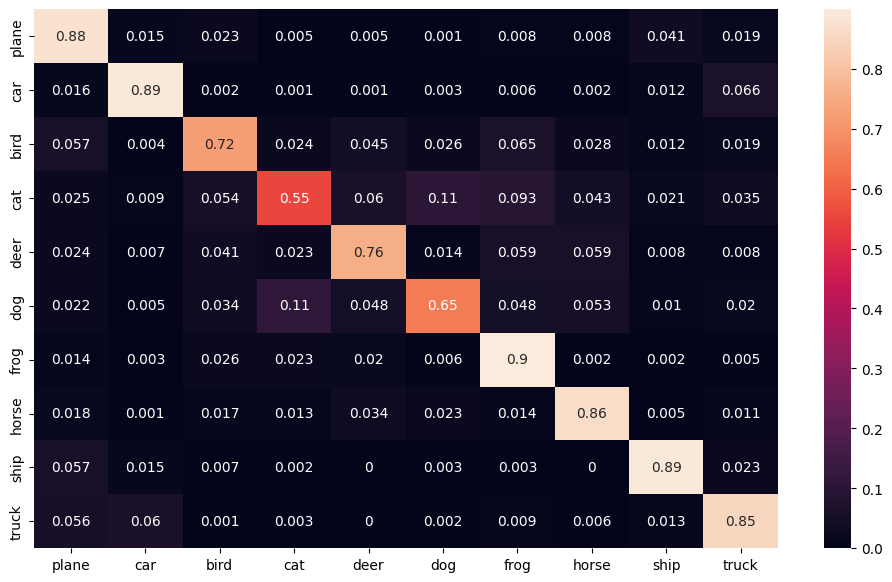

In [8]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,2,2]

In [9]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,2,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,2,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0:   0%|          | 0/176 [00:00<?, ?it/s]

Training epoch 0: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 17.06 %


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 23.72 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 30.58 %


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 33.58 %


Training epoch 4: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 37.88 %


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 38.82 %


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 43.42 %


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 44.18 %


Training epoch 8: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 48.6 %


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 47.88 %


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 51.38 %


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 52.24 %


Training epoch 12: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 52.34 %


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 54.24 %


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 54.72 %


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 55.6 %


Training epoch 16: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 54.5 %


Training epoch 17: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 56.74 %


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 57.48 %


Training epoch 19: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 58.66 %


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 58.74 %


Training epoch 21: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 58.98 %


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 58.52 %


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 60.16 %


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 62.14 %


Training epoch 25: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 61.8 %


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 61.86 %


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 61.4 %


Training epoch 28: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 63.18 %


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 63.56 %


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 63.48 %


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 64.5 %


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 63.98 %


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 64.62 %


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 65.08 %


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 63.78 %


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 65.8 %


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 65.72 %


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 66.36 %


Training epoch 39: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 66.28 %


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 66.14 %


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 66.2 %


Training epoch 42: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 65.9 %


Training epoch 43: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 66.88 %


Training epoch 44: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 67.72 %


Training epoch 45: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 67.74 %


Training epoch 46: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 67.8 %


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 67.24 %


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 66.62 %


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 64.68 %


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 68.62 %


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 66.26 %


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 67.76 %


Training epoch 53: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 68.34 %


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 68.78 %


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 68.36 %


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 68.5 %


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 68.04 %


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 70.5 %


Training epoch 59: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 69.26 %


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 68.88 %


Training epoch 61: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 69.1 %


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 69.62 %


Training epoch 63: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 69.2 %


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 69.68 %


Training epoch 65: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 68.96 %


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 70.4 %


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 69.06 %


Training epoch 68: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 70.3 %


Training epoch 69: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 70.44 %


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 69.4 %


Training epoch 71: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 69.7 %


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 70.3 %


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 70.82 %


Training epoch 74: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 69.88 %


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 70.5 %


Training epoch 76: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 69.9 %


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 69.86 %


Training epoch 78: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 71.36 %


Training epoch 79: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 71.32 %


Training epoch 80: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 72.84 %


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 73.76 %


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.38 %


Training epoch 83: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.1 %


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 72.72 %


Training epoch 85: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.52 %


Training epoch 86: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 73.28 %


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 73.52 %


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.06 %


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 73.7 %


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.02 %


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.96 %


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.44 %


Training epoch 93: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.66 %


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 73.62 %


Training epoch 95: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 74.34 %


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.64 %


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.04 %


Training epoch 98: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.28 %


Training epoch 99: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.18 %


Training epoch 100: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 73.34 %


Training epoch 101: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.4 %


Training epoch 102: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.76 %


Training epoch 103: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 72.94 %


Training epoch 104: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 73.94 %


Training epoch 105: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.16 %


Training epoch 106: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 73.42 %


Training epoch 107: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.5 %


Training epoch 108: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.12 %


Training epoch 109: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.34 %


Training epoch 110: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.72 %


Training epoch 111: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]


Accuracy of the network: 74.16 %


Training epoch 112: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 73.76 %


Training epoch 113: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 73.4 %


Training epoch 114: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.64 %


Training epoch 115: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.66 %


Training epoch 116: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 72.82 %


Training epoch 117: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.0 %


Training epoch 118: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.46 %


Training epoch 119: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 74.66 %


Training epoch 120: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 73.82 %


Training epoch 121: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.96 %


Training epoch 122: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 74.34 %


Training epoch 123: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.64 %


Training epoch 124: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.76 %


Training epoch 125: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.68 %


Training epoch 126: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.1 %


Training epoch 127: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.24 %


Training epoch 128: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 74.02 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 73.64 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 74.2 %


Training epoch 131: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 73.14 %


Training epoch 132: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 74.16 %


Training epoch 133: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 73.56 %


Training epoch 134: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 73.42 %


Training epoch 135: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 73.66 %


Training epoch 136: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.0 %


Training epoch 137: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.14 %


Training epoch 138: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.2 %


Training epoch 139: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.92 %


Training epoch 140: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 73.96 %


Training epoch 141: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.1 %


Training epoch 142: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.8 %


Training epoch 143: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.44 %


Training epoch 144: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.4 %


Training epoch 145: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.06 %


Training epoch 146: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.92 %


Training epoch 147: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 75.26 %


Training epoch 148: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 73.92 %


Training epoch 149: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.34 %


Training epoch 150: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 72.86 %


Training epoch 151: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.6 %


Training epoch 152: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 73.76 %


Training epoch 153: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.68 %


Training epoch 154: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.64 %


Training epoch 155: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 75.16 %


Training epoch 156: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 73.84 %


Training epoch 157: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 73.88 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.0 %


Training epoch 159: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 74.34 %


Training epoch 160: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 74.66 %


Training epoch 161: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 74.1 %


Training epoch 162: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 74.44 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 74.26 %


Training epoch 164: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.16 %


Training epoch 165: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.02 %


Training epoch 166: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.8 %


Training epoch 167: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.32 %


Training epoch 168: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.56 %


Training epoch 169: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.66 %


Training epoch 170: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.42 %


Training epoch 171: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.96 %


Training epoch 172: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 73.94 %


Training epoch 173: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 73.96 %


Training epoch 174: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 75.1 %


Training epoch 175: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 74.56 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 74.46 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.26 %


Training epoch 178: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.68 %


Training epoch 179: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.92 %


Training epoch 180: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.32 %


Training epoch 181: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.3 %


Training epoch 182: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.08 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 74.44 %


Training epoch 184: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.36 %


Training epoch 185: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 74.1 %


Training epoch 186: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.14 %


Training epoch 187: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.24 %


Training epoch 188: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.22 %


Training epoch 189: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.54 %


Training epoch 190: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.42 %


Training epoch 191: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 74.32 %


Training epoch 192: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.36 %


Training epoch 193: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.12 %


Training epoch 194: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.92 %


Training epoch 195: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.84 %


Training epoch 196: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.38 %


Training epoch 197: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.74 %


Training epoch 198: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 73.7 %


Training epoch 199: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.24 %
Test accuracy of the network: 75.63 %


test_accuracy,▁
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▅▆▆▇▆▇▇▇▇▇▇▇▇████████████████████████
validation_loss,█▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.7563
train_loss,0.50972
validation_accuracy,0.7424
validation_loss,0.77313


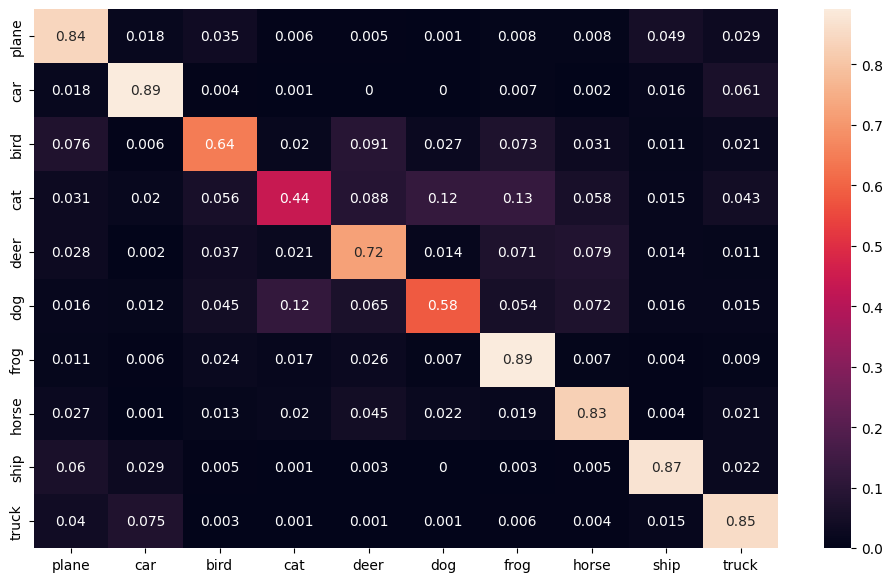

In [10]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,3,2]

In [7]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,3,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,3,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.11it/s]


Accuracy of the network: 9.34 %


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.8 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.34 %


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.34 %


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.34 %


Training epoch 8: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 10: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 11: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 12: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 13: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.34 %


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 15: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 16: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.34 %


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.34 %


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 21: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 24: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 26: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 27: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 28: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.34 %


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 30: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.34 %


Training epoch 31: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.34 %


Training epoch 32: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 33: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 35: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.34 %


Training epoch 36: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 38: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 39: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 40: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 41: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 42: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 43: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 44: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.34 %


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 48: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 49: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 51: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 52: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.34 %


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.34 %


Training epoch 57: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.34 %


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 60: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 62: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 66: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.34 %


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.34 %


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.34 %


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 82: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 85: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 88: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 90: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 91: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 9.1 %


Training epoch 96: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 97: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 100: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 101: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 102: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 104: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 105: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 106: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 108: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 109: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 110: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 111: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 112: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 113: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 114: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 115: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 116: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 117: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 118: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 119: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 120: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 121: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 122: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 123: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 124: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 125: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 126: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 127: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 128: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 131: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 132: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 133: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 134: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 135: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 136: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 137: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 138: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 139: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 140: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 141: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 142: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 143: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 144: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 145: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 146: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 147: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 148: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 149: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 150: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 151: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 152: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 153: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 154: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 9.1 %


Training epoch 156: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 157: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 159: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 160: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 161: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 162: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 9.1 %


Training epoch 164: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 165: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 166: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 167: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 168: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 9.1 %


Training epoch 169: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 170: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 171: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 172: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 173: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 174: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 175: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 178: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 179: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 180: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 181: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 182: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 184: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 185: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 9.1 %


Training epoch 186: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 9.1 %


Training epoch 187: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 9.1 %


Training epoch 188: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 189: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 190: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 191: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 192: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 193: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 194: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 195: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 196: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 9.1 %


Training epoch 197: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 9.1 %


Training epoch 198: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %


Training epoch 199: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 9.1 %
Test accuracy of the network: 10.0 %


test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▂▅▆▆▅█▁▃▆▂▄▃█▄▃▄▄▅▅▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
test_accuracy,0.1
train_loss,2.30258
validation_accuracy,0.091
validation_loss,2.30282


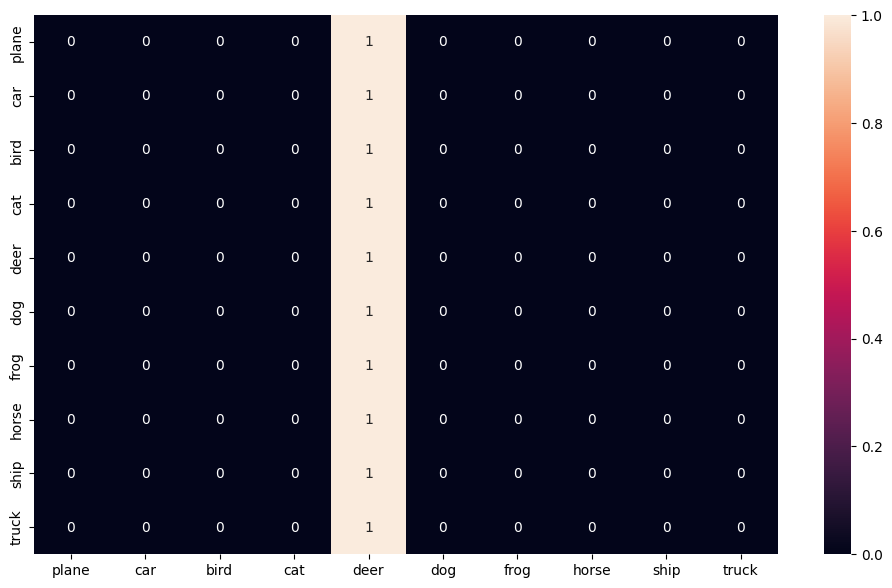

In [8]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,5,2]

In [9]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,5,2]",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,5,2],
          "residual": 'no'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]


Accuracy of the network: 9.1 %


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.8 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.34 %


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 12: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.34 %


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.34 %


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.34 %


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 16: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 19: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.34 %


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.34 %


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 28: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 31: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.34 %


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 39: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.34 %


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 42: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 44: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 45: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 46: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.34 %


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.34 %


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.94 %


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 9.1 %


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 59: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 61: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 9.1 %


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 63: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 65: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 9.1 %


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 9.1 %


Training epoch 68: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 69: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.34 %


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.34 %


Training epoch 74: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.34 %


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 76: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.34 %


Training epoch 79: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 80: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 86: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 9.1 %


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 93: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 95: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 9.1 %


Training epoch 96: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 9.1 %


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 98: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 99: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 100: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 101: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 102: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 104: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 105: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 106: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 108: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 109: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 110: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 9.1 %


Training epoch 111: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 112: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 113: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 114: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 115: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 116: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 117: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 118: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 119: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 120: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 121: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 9.1 %


Training epoch 122: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 123: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 9.1 %


Training epoch 124: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 125: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 126: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 127: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 128: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 9.1 %


Training epoch 129: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 130: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 131: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 132: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 133: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 134: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 9.1 %


Training epoch 135: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 136: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 137: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 138: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 139: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 140: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 141: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 142: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 143: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 144: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 145: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 146: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 147: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 148: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 149: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 150: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 151: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 152: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 153: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 154: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 156: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 157: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 159: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 160: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 161: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 162: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 164: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 165: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 166: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 167: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 168: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 169: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 170: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 171: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 9.1 %


Training epoch 172: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 173: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 174: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 175: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 178: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 179: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 180: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 181: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 182: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 183: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 184: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 9.1 %


Training epoch 185: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 186: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 9.1 %


Training epoch 187: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 9.1 %


Training epoch 188: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 189: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 190: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 191: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 192: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 9.1 %


Training epoch 193: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 194: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %


Training epoch 195: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 9.1 %


Training epoch 196: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 9.1 %


Training epoch 197: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 9.1 %


Training epoch 198: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 9.1 %


Training epoch 199: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 9.1 %
Test accuracy of the network: 10.0 %


test_accuracy,▁
train_loss,█▅▆▆▅▆▆▅▆▆▆▆▆▆▅▅▂▁▂▁▂▁▂▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▅▅█▅▄▃▄▁▂▇▆▂▆▆▂▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
test_accuracy,0.1
train_loss,2.30257
validation_accuracy,0.091
validation_loss,2.30281


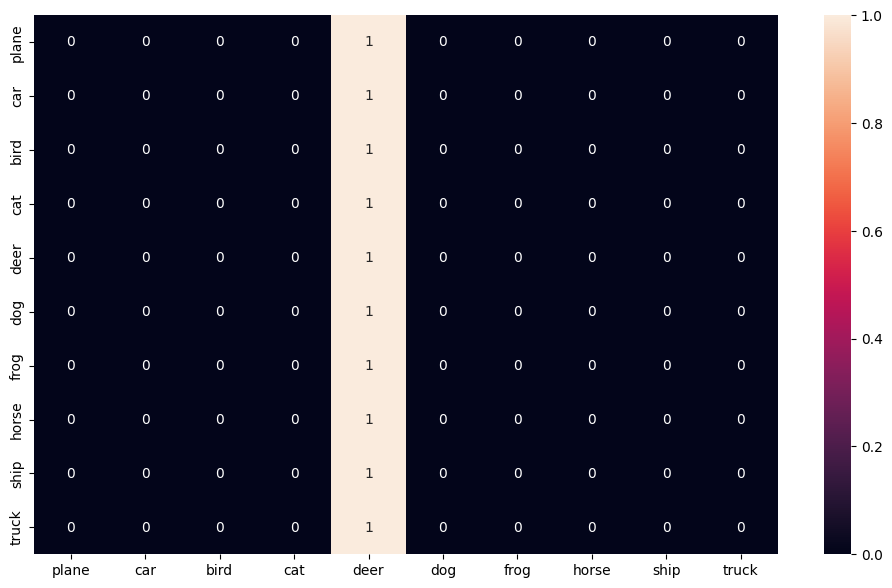

In [10]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_net(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,1,1] residual

In [9]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,1,1] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,1,1],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 37.88 %


Training epoch 1: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 42.22 %


Training epoch 2: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 49.46 %


Training epoch 3: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 52.48 %


Training epoch 4: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 55.74 %


Training epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 58.74 %


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 60.56 %


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 62.4 %


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 62.58 %


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 64.62 %


Training epoch 10: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 66.24 %


Training epoch 11: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 66.62 %


Training epoch 12: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 67.56 %


Training epoch 13: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 67.98 %


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 68.42 %


Training epoch 15: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 69.52 %


Training epoch 16: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 70.24 %


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 71.1 %


Training epoch 18: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 69.08 %


Training epoch 19: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 72.18 %


Training epoch 20: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 71.82 %


Training epoch 21: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 72.08 %


Training epoch 22: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 71.4 %


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 72.32 %


Training epoch 24: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 72.02 %


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 72.24 %


Training epoch 26: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 72.88 %


Training epoch 27: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 72.1 %


Training epoch 28: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 72.48 %


Training epoch 29: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 72.78 %


Training epoch 30: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 72.78 %


Training epoch 31: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 73.48 %


Training epoch 32: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 74.68 %


Training epoch 33: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 73.64 %


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 74.06 %


Training epoch 35: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 73.22 %


Training epoch 36: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 72.7 %


Training epoch 37: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 74.58 %


Training epoch 38: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 73.94 %


Training epoch 39: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 73.54 %


Training epoch 40: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.1 %


Training epoch 41: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.72 %


Training epoch 42: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.06 %


Training epoch 43: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.54 %


Training epoch 44: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.4 %


Training epoch 45: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.34 %


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 74.34 %


Training epoch 47: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 73.92 %


Training epoch 48: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.24 %


Training epoch 49: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 73.42 %


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 75.08 %


Training epoch 51: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 73.8 %


Training epoch 52: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 74.2 %


Training epoch 53: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 74.74 %


Training epoch 54: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.72 %


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 74.7 %


Training epoch 56: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.32 %


Training epoch 57: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.94 %


Training epoch 58: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 75.44 %


Training epoch 59: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 74.14 %


Training epoch 60: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 75.36 %


Training epoch 61: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.7 %


Training epoch 62: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 76.16 %


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 74.3 %


Training epoch 64: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]


Accuracy of the network: 74.38 %


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 75.14 %


Training epoch 66: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 73.88 %


Training epoch 67: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 74.6 %


Training epoch 68: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 75.44 %


Training epoch 69: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 74.94 %


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 75.32 %


Training epoch 71: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 74.68 %


Training epoch 72: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 74.28 %


Training epoch 73: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 75.34 %


Training epoch 74: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 75.46 %


Training epoch 75: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 75.36 %


Training epoch 76: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 75.28 %


Training epoch 77: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.76 %


Training epoch 78: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 74.92 %


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 76.8 %


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.4 %


Training epoch 81: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 76.98 %


Training epoch 82: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.08 %


Training epoch 83: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.52 %


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 76.92 %


Training epoch 85: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 76.78 %


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 76.84 %


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.62 %


Training epoch 88: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.24 %


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.58 %


Training epoch 90: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 76.66 %


Training epoch 91: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.4 %


Training epoch 92: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.22 %


Training epoch 93: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 76.7 %


Training epoch 94: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]


Accuracy of the network: 77.2 %


Training epoch 95: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 76.98 %


Training epoch 96: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 76.86 %


Training epoch 97: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.2 %


Training epoch 98: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.38 %


Training epoch 99: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.54 %


Training epoch 100: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 77.02 %


Training epoch 101: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.64 %


Training epoch 102: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.42 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.78 %


Training epoch 104: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.5 %


Training epoch 105: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 76.68 %


Training epoch 106: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 76.78 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 76.58 %


Training epoch 108: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.18 %


Training epoch 109: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.74 %


Training epoch 110: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.56 %


Training epoch 111: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.72 %


Training epoch 112: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.8 %


Training epoch 113: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.46 %


Training epoch 114: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.4 %


Training epoch 115: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 78.2 %


Training epoch 116: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.82 %


Training epoch 117: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.78 %


Training epoch 118: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 76.82 %


Training epoch 119: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 78.14 %


Training epoch 120: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 78.18 %


Training epoch 121: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.38 %


Training epoch 122: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.76 %


Training epoch 123: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.3 %


Training epoch 124: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 76.74 %


Training epoch 125: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 76.92 %


Training epoch 126: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.78 %


Training epoch 127: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.62 %


Training epoch 128: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.0 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.62 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.16 %


Training epoch 131: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.52 %


Training epoch 132: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.56 %


Training epoch 133: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 78.0 %


Training epoch 134: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 78.46 %


Training epoch 135: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.7 %


Training epoch 136: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.58 %


Training epoch 137: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.06 %


Training epoch 138: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 76.88 %


Training epoch 139: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.18 %


Training epoch 140: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.54 %


Training epoch 141: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.8 %


Training epoch 142: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 78.12 %


Training epoch 143: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.64 %


Training epoch 144: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 76.32 %


Training epoch 145: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 76.8 %


Training epoch 146: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.68 %


Training epoch 147: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 76.78 %


Training epoch 148: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.12 %


Training epoch 149: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.64 %


Training epoch 150: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.44 %


Training epoch 151: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 77.46 %


Training epoch 152: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.72 %


Training epoch 153: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 77.72 %


Training epoch 154: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 76.82 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.44 %


Training epoch 156: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.54 %


Training epoch 157: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 76.78 %


Training epoch 158: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]


Accuracy of the network: 77.74 %


Training epoch 159: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.18 %


Training epoch 160: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]


Accuracy of the network: 77.72 %


Training epoch 161: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.94 %


Training epoch 162: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.1 %


Training epoch 163: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.78 %


Training epoch 164: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.56 %


Training epoch 165: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.64 %


Training epoch 166: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 77.74 %


Training epoch 167: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.74 %


Training epoch 168: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.78 %


Training epoch 169: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 76.8 %


Training epoch 170: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.48 %


Training epoch 171: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.76 %


Training epoch 172: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.26 %


Training epoch 173: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.44 %


Training epoch 174: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.14 %


Training epoch 175: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.34 %


Training epoch 176: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.44 %


Training epoch 177: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]


Accuracy of the network: 77.9 %


Training epoch 178: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.62 %


Training epoch 179: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 77.92 %


Training epoch 180: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.04 %


Training epoch 181: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.64 %


Training epoch 182: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.22 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.54 %


Training epoch 184: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.78 %


Training epoch 185: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.96 %


Training epoch 186: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 77.04 %


Training epoch 187: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.38 %


Training epoch 188: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]


Accuracy of the network: 77.56 %


Training epoch 189: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Accuracy of the network: 77.86 %


Training epoch 190: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]


Accuracy of the network: 78.1 %


Training epoch 191: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.36 %


Training epoch 192: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 77.3 %


Training epoch 193: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]


Accuracy of the network: 77.66 %


Training epoch 194: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.64 %


Training epoch 195: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 77.7 %


Training epoch 196: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.86 %


Training epoch 197: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Accuracy of the network: 77.78 %


Training epoch 198: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Accuracy of the network: 78.24 %


Training epoch 199: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]


Accuracy of the network: 76.96 %
Test accuracy of the network: 78.97 %


test_accuracy,▁
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇█▇▇▇▇▇▇▇████████████████████████
validation_loss,█▄▃▂▂▂▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▃▂▃▃▂▃▃▂▂
test_accuracy,0.7897
train_loss,0.14961
validation_accuracy,0.7696
validation_loss,0.91693


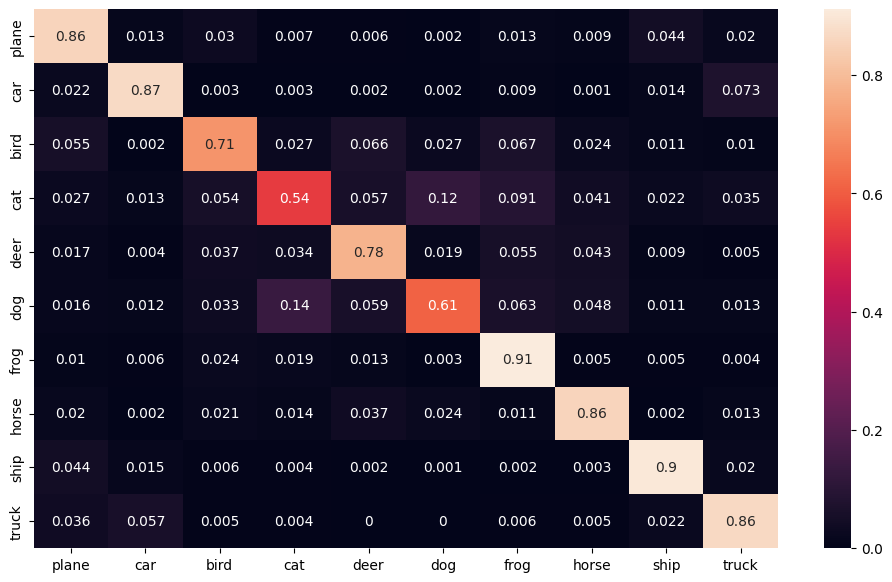

In [10]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,2,2] residual

In [11]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,2,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,2,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 35.44 %


Training epoch 1: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 43.32 %


Training epoch 2: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 46.66 %


Training epoch 3: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 51.64 %


Training epoch 4: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 55.6 %


Training epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 57.16 %


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 58.44 %


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 60.4 %


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 62.6 %


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 63.44 %


Training epoch 10: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 64.32 %


Training epoch 11: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 65.88 %


Training epoch 12: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 66.44 %


Training epoch 13: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 67.48 %


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 67.1 %


Training epoch 15: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 66.78 %


Training epoch 16: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 68.54 %


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 68.28 %


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 69.84 %


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 69.04 %


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 70.88 %


Training epoch 21: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 70.46 %


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 70.86 %


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 71.04 %


Training epoch 24: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 71.54 %


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 71.34 %


Training epoch 26: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 71.22 %


Training epoch 27: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 72.78 %


Training epoch 28: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 72.16 %


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 71.72 %


Training epoch 30: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 72.12 %


Training epoch 31: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 73.38 %


Training epoch 32: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 72.48 %


Training epoch 33: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 73.06 %


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 72.4 %


Training epoch 35: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 73.86 %


Training epoch 36: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 73.58 %


Training epoch 37: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 73.48 %


Training epoch 38: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 73.56 %


Training epoch 39: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 73.6 %


Training epoch 40: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.42 %


Training epoch 41: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 72.74 %


Training epoch 42: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.5 %


Training epoch 43: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.52 %


Training epoch 44: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.52 %


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.58 %


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.36 %


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.8 %


Training epoch 48: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 74.32 %


Training epoch 49: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 74.94 %


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.28 %


Training epoch 51: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.76 %


Training epoch 52: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 72.48 %


Training epoch 53: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.38 %


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.24 %


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.18 %


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.96 %


Training epoch 57: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.8 %


Training epoch 58: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.68 %


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.14 %


Training epoch 60: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.22 %


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 74.58 %


Training epoch 62: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]


Accuracy of the network: 74.42 %


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 74.22 %


Training epoch 64: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 74.28 %


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 75.26 %


Training epoch 66: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 75.24 %


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 75.58 %


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.78 %


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.04 %


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.94 %


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.92 %


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.92 %


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.94 %


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 74.42 %


Training epoch 75: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.5 %


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.86 %


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.52 %


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.26 %


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.14 %


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.02 %


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.9 %


Training epoch 82: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.42 %


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.0 %


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.1 %


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.98 %


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.74 %


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.94 %


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.36 %


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.54 %


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.12 %


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 76.18 %


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.72 %


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 76.76 %


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.24 %


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.38 %


Training epoch 96: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.3 %


Training epoch 97: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.34 %


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.56 %


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.66 %


Training epoch 100: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.22 %


Training epoch 101: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.2 %


Training epoch 102: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.18 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.08 %


Training epoch 104: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.0 %


Training epoch 105: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.88 %


Training epoch 106: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.54 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.58 %


Training epoch 108: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 76.78 %


Training epoch 109: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 76.88 %


Training epoch 110: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.82 %


Training epoch 111: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.18 %


Training epoch 112: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.66 %


Training epoch 113: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.54 %


Training epoch 114: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 76.92 %


Training epoch 115: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.78 %


Training epoch 116: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.58 %


Training epoch 117: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.64 %


Training epoch 118: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.9 %


Training epoch 119: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.12 %


Training epoch 120: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.72 %


Training epoch 121: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.16 %


Training epoch 122: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.76 %


Training epoch 123: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.22 %


Training epoch 124: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.36 %


Training epoch 125: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.38 %


Training epoch 126: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.16 %


Training epoch 127: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.04 %


Training epoch 128: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.08 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.04 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.1 %


Training epoch 131: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.64 %


Training epoch 132: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.0 %


Training epoch 133: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.1 %


Training epoch 134: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.92 %


Training epoch 135: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 76.5 %


Training epoch 136: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.08 %


Training epoch 137: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.34 %


Training epoch 138: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.22 %


Training epoch 139: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.3 %


Training epoch 140: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.36 %


Training epoch 141: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.82 %


Training epoch 142: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 77.3 %


Training epoch 143: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.36 %


Training epoch 144: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.18 %


Training epoch 145: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.94 %


Training epoch 146: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.34 %


Training epoch 147: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.12 %


Training epoch 148: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.06 %


Training epoch 149: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Accuracy of the network: 76.66 %


Training epoch 150: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.88 %


Training epoch 151: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.26 %


Training epoch 152: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.92 %


Training epoch 153: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.68 %


Training epoch 154: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 76.64 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.96 %


Training epoch 156: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.1 %


Training epoch 157: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 76.44 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 76.54 %


Training epoch 159: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 76.72 %


Training epoch 160: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.14 %


Training epoch 161: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 78.02 %


Training epoch 162: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.12 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.14 %


Training epoch 164: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.84 %


Training epoch 165: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.06 %


Training epoch 166: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.96 %


Training epoch 167: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.5 %


Training epoch 168: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.88 %


Training epoch 169: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.34 %


Training epoch 170: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.38 %


Training epoch 171: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.34 %


Training epoch 172: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.0 %


Training epoch 173: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.78 %


Training epoch 174: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.6 %


Training epoch 175: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.84 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 76.72 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 76.72 %


Training epoch 178: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.28 %


Training epoch 179: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.82 %


Training epoch 180: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.44 %


Training epoch 181: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.2 %


Training epoch 182: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.62 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.1 %


Training epoch 184: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.36 %


Training epoch 185: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.06 %


Training epoch 186: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.74 %


Training epoch 187: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.56 %


Training epoch 188: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.32 %


Training epoch 189: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.8 %


Training epoch 190: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 76.7 %


Training epoch 191: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.12 %


Training epoch 192: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.24 %


Training epoch 193: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.98 %


Training epoch 194: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.0 %


Training epoch 195: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.96 %


Training epoch 196: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.62 %


Training epoch 197: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 76.78 %


Training epoch 198: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.84 %


Training epoch 199: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.24 %
Test accuracy of the network: 78.02 %


test_accuracy,▁
train_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇█▇▇████████████████████████
validation_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_accuracy,0.7802
train_loss,0.16928
validation_accuracy,0.7724
validation_loss,0.89657


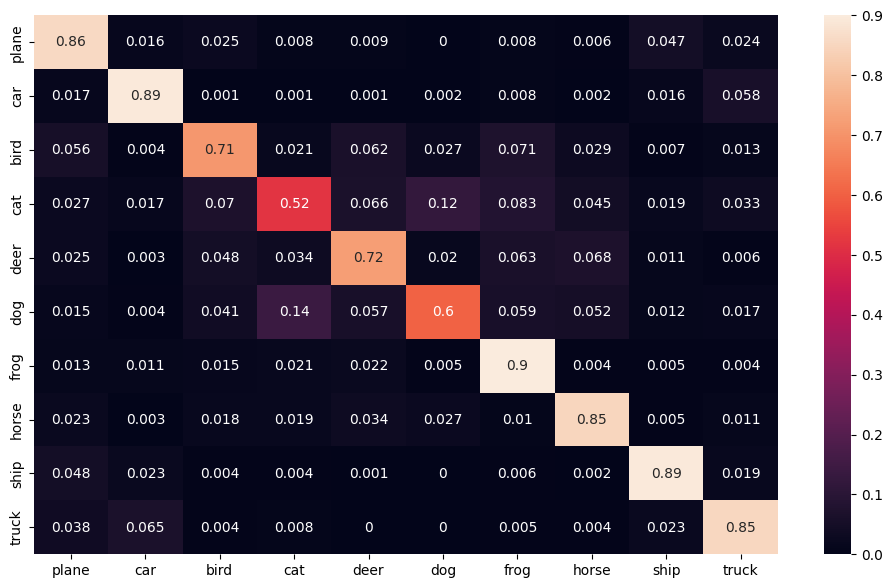

In [12]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,3,2] residual

In [7]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,3,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,3,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0:   1%|          | 1/176 [00:00<02:26,  1.19it/s]

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]


Accuracy of the network: 33.56 %


Training epoch 1: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 42.26 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 47.14 %


Training epoch 3: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 52.3 %


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 55.68 %


Training epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 57.28 %


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 58.72 %


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 61.56 %


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 63.04 %


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 63.14 %


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 65.78 %


Training epoch 11: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 65.76 %


Training epoch 12: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 66.98 %


Training epoch 13: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 67.62 %


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 67.24 %


Training epoch 15: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 68.64 %


Training epoch 16: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 69.54 %


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 68.86 %


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 69.4 %


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 70.54 %


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 69.78 %


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 70.42 %


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 71.2 %


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 71.84 %


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 71.8 %


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 71.94 %


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 71.76 %


Training epoch 27: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 72.64 %


Training epoch 28: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 72.58 %


Training epoch 29: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 71.52 %


Training epoch 30: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.58 %


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.66 %


Training epoch 32: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 73.34 %


Training epoch 33: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 73.66 %


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 73.36 %


Training epoch 35: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 74.74 %


Training epoch 36: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.76 %


Training epoch 37: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.08 %


Training epoch 38: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 73.68 %


Training epoch 39: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.58 %


Training epoch 40: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.04 %


Training epoch 41: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.32 %


Training epoch 42: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.1 %


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 73.4 %


Training epoch 44: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.16 %


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 72.86 %


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 73.7 %


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 73.92 %


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 73.7 %


Training epoch 49: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 73.54 %


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.5 %


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 74.8 %


Training epoch 52: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 75.42 %


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 74.2 %


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 73.16 %


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 75.4 %


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 74.72 %


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 75.2 %


Training epoch 58: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.08 %


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 74.28 %


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.26 %


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 75.12 %


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 74.5 %


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.88 %


Training epoch 64: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.56 %


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.82 %


Training epoch 66: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.64 %


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.9 %


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 75.42 %


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.36 %


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.16 %


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 74.62 %


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.38 %


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 74.76 %


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 75.8 %


Training epoch 75: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 73.78 %


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 75.12 %


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 75.2 %


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.08 %


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 74.9 %


Training epoch 80: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 76.48 %


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.0 %


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 76.68 %


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.56 %


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.02 %


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.84 %


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.82 %


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.46 %


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 76.22 %


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.22 %


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 76.6 %


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 78.5 %


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.24 %


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 76.68 %


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.16 %


Training epoch 95: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.36 %


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 76.68 %


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.38 %


Training epoch 98: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.38 %


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.2 %


Training epoch 100: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 76.68 %


Training epoch 101: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.16 %


Training epoch 102: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 78.1 %


Training epoch 103: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 76.8 %


Training epoch 104: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 76.96 %


Training epoch 105: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 76.76 %


Training epoch 106: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.64 %


Training epoch 107: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 78.16 %


Training epoch 108: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.3 %


Training epoch 109: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.3 %


Training epoch 110: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.28 %


Training epoch 111: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.0 %


Training epoch 112: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.04 %


Training epoch 113: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 76.7 %


Training epoch 114: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 76.86 %


Training epoch 115: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.0 %


Training epoch 116: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.42 %


Training epoch 117: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.72 %


Training epoch 118: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.7 %


Training epoch 119: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.9 %


Training epoch 120: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.32 %


Training epoch 121: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.64 %


Training epoch 122: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.98 %


Training epoch 123: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.36 %


Training epoch 124: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Accuracy of the network: 77.36 %


Training epoch 125: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.78 %


Training epoch 126: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 76.56 %


Training epoch 127: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.62 %


Training epoch 128: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.64 %


Training epoch 129: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.32 %


Training epoch 130: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.5 %


Training epoch 131: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.78 %


Training epoch 132: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.48 %


Training epoch 133: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.9 %


Training epoch 134: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.3 %


Training epoch 135: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.66 %


Training epoch 136: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.62 %


Training epoch 137: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.22 %


Training epoch 138: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.36 %


Training epoch 139: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.8 %


Training epoch 140: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.3 %


Training epoch 141: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.1 %


Training epoch 142: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.96 %


Training epoch 143: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.52 %


Training epoch 144: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.76 %


Training epoch 145: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.7 %


Training epoch 146: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.02 %


Training epoch 147: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.72 %


Training epoch 148: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.86 %


Training epoch 149: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.3 %


Training epoch 150: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.68 %


Training epoch 151: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.74 %


Training epoch 152: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.22 %


Training epoch 153: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.82 %


Training epoch 154: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.36 %


Training epoch 155: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.98 %


Training epoch 156: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 78.56 %


Training epoch 157: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.28 %


Training epoch 158: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.96 %


Training epoch 159: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.24 %


Training epoch 160: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.6 %


Training epoch 161: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.38 %


Training epoch 162: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 76.62 %


Training epoch 163: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.38 %


Training epoch 164: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 78.08 %


Training epoch 165: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.44 %


Training epoch 166: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.12 %


Training epoch 167: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.06 %


Training epoch 168: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.5 %


Training epoch 169: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.08 %


Training epoch 170: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.78 %


Training epoch 171: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.68 %


Training epoch 172: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.64 %


Training epoch 173: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 76.8 %


Training epoch 174: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Accuracy of the network: 77.72 %


Training epoch 175: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.4 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.02 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.7 %


Training epoch 178: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.18 %


Training epoch 179: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Accuracy of the network: 77.84 %


Training epoch 180: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.26 %


Training epoch 181: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 76.82 %


Training epoch 182: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Accuracy of the network: 77.74 %


Training epoch 183: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Accuracy of the network: 77.6 %


Training epoch 184: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.3 %


Training epoch 185: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 78.18 %


Training epoch 186: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 76.8 %


Training epoch 187: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.2 %


Training epoch 188: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.66 %


Training epoch 189: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 77.02 %


Training epoch 190: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.86 %


Training epoch 191: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 78.16 %


Training epoch 192: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Accuracy of the network: 78.0 %


Training epoch 193: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.46 %


Training epoch 194: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 78.26 %


Training epoch 195: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Accuracy of the network: 77.88 %


Training epoch 196: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Accuracy of the network: 77.8 %


Training epoch 197: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Accuracy of the network: 77.1 %


Training epoch 198: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Accuracy of the network: 77.92 %


Training epoch 199: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Accuracy of the network: 77.08 %
Test accuracy of the network: 78.79 %


test_accuracy,▁
train_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
validation_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_accuracy,0.7879
train_loss,0.1759
validation_accuracy,0.7708
validation_loss,0.90366


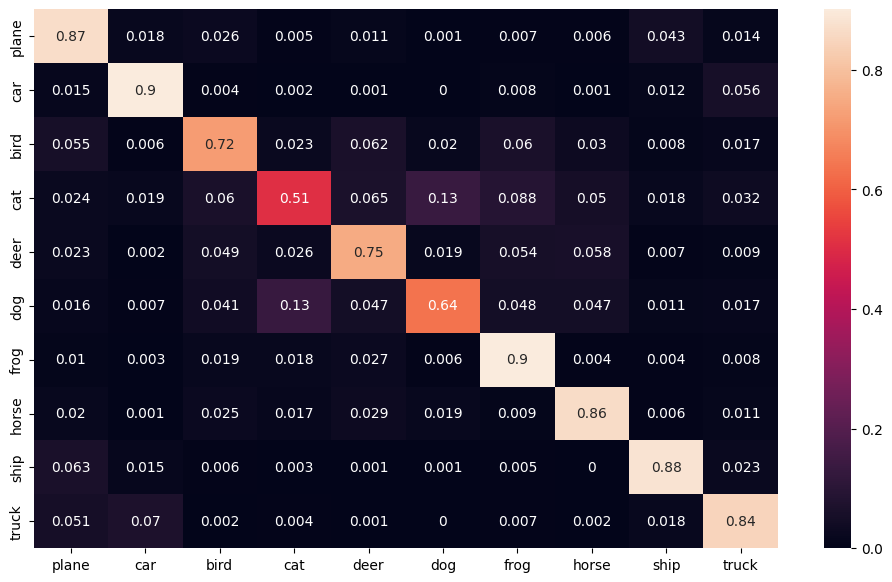

In [8]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

#### Training CNN, [1,5,2] residual

In [11]:
torch.manual_seed(12)
# Training and arhitecture hyperparameters, initialise a wandb run
run=wandb.init(
      project="Lab1-CNN",
      name = "layer_list=[1,5,2] residual",
      config={
          "epochs": 200,
          "batch_size": 256,
          "lr": 0.001,
          "layer_list": [1,5,2],
          "residual": 'yes'
          })

# Copy the configuration
config = wandb.config

# choose the device
device = 'cuda'

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.12it/s]


Accuracy of the network: 32.3 %


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 42.56 %


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 47.54 %


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 51.78 %


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 54.62 %


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 56.5 %


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 59.72 %


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 59.94 %


Training epoch 8: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 62.68 %


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 63.5 %


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 63.48 %


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 65.88 %


Training epoch 12: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 67.42 %


Training epoch 13: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 67.44 %


Training epoch 14: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 67.5 %


Training epoch 15: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 69.26 %


Training epoch 16: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 69.92 %


Training epoch 17: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 68.5 %


Training epoch 18: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 69.62 %


Training epoch 19: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 70.68 %


Training epoch 20: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 71.2 %


Training epoch 21: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 69.4 %


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 70.12 %


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 72.1 %


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 70.64 %


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 71.1 %


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 71.42 %


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 72.26 %


Training epoch 28: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 72.24 %


Training epoch 29: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]


Accuracy of the network: 72.08 %


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 72.82 %


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 72.62 %


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 73.46 %


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 73.12 %


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 73.66 %


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 72.1 %


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.1 %


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.7 %


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.1 %


Training epoch 39: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]


Accuracy of the network: 74.68 %


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.2 %


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 73.68 %


Training epoch 42: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 75.38 %


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 73.08 %


Training epoch 44: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 75.26 %


Training epoch 45: 100%|██████████| 176/176 [00:42<00:00,  4.11it/s]


Accuracy of the network: 73.62 %


Training epoch 46: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 74.74 %


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.42 %


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.54 %


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 73.72 %


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.2 %


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.22 %


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.06 %


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.76 %


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 75.04 %


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.78 %


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 75.16 %


Training epoch 57: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 75.38 %


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 75.12 %


Training epoch 59: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 75.48 %


Training epoch 60: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 73.94 %


Training epoch 61: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 74.92 %


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 74.98 %


Training epoch 63: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 74.6 %


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 74.58 %


Training epoch 65: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 75.74 %


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 75.12 %


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 74.62 %


Training epoch 68: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.7 %


Training epoch 69: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 75.08 %


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.64 %


Training epoch 71: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 74.18 %


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 74.86 %


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 73.6 %


Training epoch 74: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.64 %


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.96 %


Training epoch 76: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 75.12 %


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 74.48 %


Training epoch 78: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 75.7 %


Training epoch 79: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 75.08 %


Training epoch 80: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 76.68 %


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 76.7 %


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.26 %


Training epoch 83: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.7 %


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.66 %


Training epoch 85: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.4 %


Training epoch 86: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.2 %


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 76.34 %


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 76.76 %


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 76.62 %


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 78.2 %


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 78.04 %


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.24 %


Training epoch 93: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 76.66 %


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 76.88 %


Training epoch 95: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]


Accuracy of the network: 76.54 %


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 77.36 %


Training epoch 97: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 78.4 %


Training epoch 98: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 77.22 %


Training epoch 99: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 77.38 %


Training epoch 100: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.16 %


Training epoch 101: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.68 %


Training epoch 102: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 78.06 %


Training epoch 103: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.1 %


Training epoch 104: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.08 %


Training epoch 105: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.14 %


Training epoch 106: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.3 %


Training epoch 107: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.28 %


Training epoch 108: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.28 %


Training epoch 109: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.38 %


Training epoch 110: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.48 %


Training epoch 111: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.24 %


Training epoch 112: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.4 %


Training epoch 113: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Accuracy of the network: 76.98 %


Training epoch 114: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 77.82 %


Training epoch 115: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.3 %


Training epoch 116: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 78.24 %


Training epoch 117: 100%|██████████| 176/176 [00:42<00:00,  4.11it/s]


Accuracy of the network: 77.28 %


Training epoch 118: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.34 %


Training epoch 119: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.8 %


Training epoch 120: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 78.34 %


Training epoch 121: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 77.76 %


Training epoch 122: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.56 %


Training epoch 123: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 76.6 %


Training epoch 124: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.44 %


Training epoch 125: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.0 %


Training epoch 126: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.76 %


Training epoch 127: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.06 %


Training epoch 128: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.6 %


Training epoch 129: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.74 %


Training epoch 130: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 78.38 %


Training epoch 131: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.52 %


Training epoch 132: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.74 %


Training epoch 133: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.66 %


Training epoch 134: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 76.94 %


Training epoch 135: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.82 %


Training epoch 136: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.88 %


Training epoch 137: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.36 %


Training epoch 138: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.2 %


Training epoch 139: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]


Accuracy of the network: 78.32 %


Training epoch 140: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Accuracy of the network: 77.74 %


Training epoch 141: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.18 %


Training epoch 142: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.48 %


Training epoch 143: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.7 %


Training epoch 144: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.4 %


Training epoch 145: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.12 %


Training epoch 146: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.92 %


Training epoch 147: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.16 %


Training epoch 148: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 77.56 %


Training epoch 149: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 77.68 %


Training epoch 150: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.64 %


Training epoch 151: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.02 %


Training epoch 152: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.4 %


Training epoch 153: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.3 %


Training epoch 154: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.48 %


Training epoch 155: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.68 %


Training epoch 156: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Accuracy of the network: 77.96 %


Training epoch 157: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.04 %


Training epoch 158: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.44 %


Training epoch 159: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.14 %


Training epoch 160: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.9 %


Training epoch 161: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 76.84 %


Training epoch 162: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.32 %


Training epoch 163: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 78.0 %


Training epoch 164: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 78.58 %


Training epoch 165: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.82 %


Training epoch 166: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.52 %


Training epoch 167: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.08 %


Training epoch 168: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 78.0 %


Training epoch 169: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.36 %


Training epoch 170: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.46 %


Training epoch 171: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Accuracy of the network: 77.64 %


Training epoch 172: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Accuracy of the network: 77.72 %


Training epoch 173: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.44 %


Training epoch 174: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 78.52 %


Training epoch 175: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.7 %


Training epoch 176: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.86 %


Training epoch 177: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 78.04 %


Training epoch 178: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.54 %


Training epoch 179: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.62 %


Training epoch 180: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.78 %


Training epoch 181: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.94 %


Training epoch 182: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 78.0 %


Training epoch 183: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Accuracy of the network: 78.64 %


Training epoch 184: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Accuracy of the network: 77.14 %


Training epoch 185: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.48 %


Training epoch 186: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 78.36 %


Training epoch 187: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 78.06 %


Training epoch 188: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.1 %


Training epoch 189: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Accuracy of the network: 78.22 %


Training epoch 190: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.58 %


Training epoch 191: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Accuracy of the network: 77.84 %


Training epoch 192: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.84 %


Training epoch 193: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Accuracy of the network: 77.98 %


Training epoch 194: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Accuracy of the network: 77.52 %


Training epoch 195: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.82 %


Training epoch 196: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 77.86 %


Training epoch 197: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 78.08 %


Training epoch 198: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Accuracy of the network: 77.24 %


Training epoch 199: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Accuracy of the network: 76.78 %
Test accuracy of the network: 79.11 %


test_accuracy,▁
train_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
validation_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
test_accuracy,0.7911
train_loss,0.16562
validation_accuracy,0.7678
validation_loss,0.93406


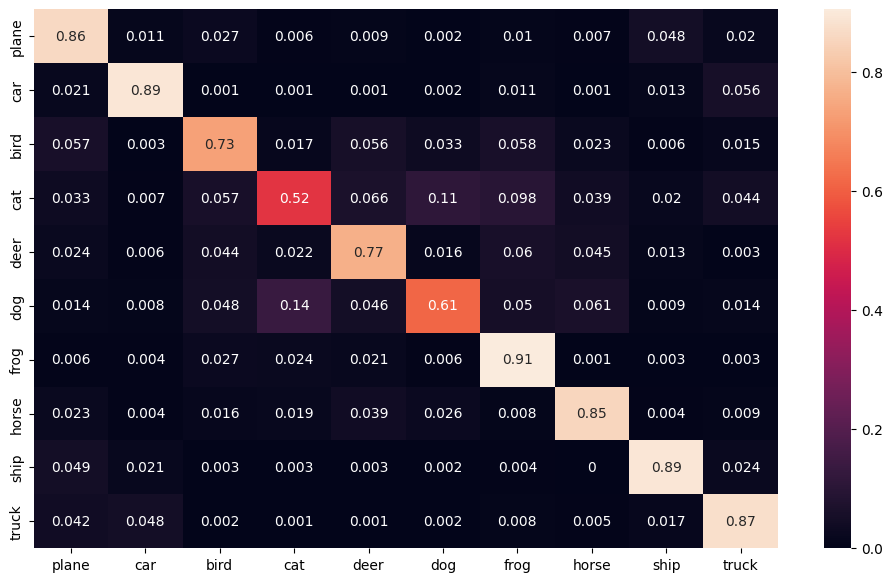

In [12]:
from torch.optim.lr_scheduler import MultiStepLR

# Dataloaders.
dl_train_cifar = torch.utils.data.DataLoader(cifar10_train, config.batch_size, shuffle=True )
dl_val_cifar   = torch.utils.data.DataLoader(cifar10_val, config.batch_size)
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, config.batch_size, shuffle=True)

# Instantiate model and optimizer.
model_cnn = CNN_res(layer_list= config.layer_list, num_classes=len(classes), channels=3).to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=config.lr)
scheduler = MultiStepLR(optimizer, milestones=[80,160], gamma=0.1)


#save the model with the greatest validation accuracy as the best model overall
model_state_dict = None
best_acc=0
# Training loop.
for epoch in range(config.epochs):
    train_loss = train_epoch(model_cnn, dl_train_cifar, optimizer, epoch, device=device)
    train_metrics = {"train_loss": train_loss}
    val_loss, val_acc = evaluate_model(model_cnn, dl_val_cifar, device=device)
    scheduler.step()
    #select the best model
    if val_acc> best_acc:
      best_acc=val_acc
      # save all the parameters of the model
      model_state_dict = model_cnn.state_dict()
    val_metrics = {"validation_loss": val_loss,
                    "validation_accuracy": val_acc}
    #log the metrics on weights and biases
    wandb.log({**train_metrics, **val_metrics})

# load saved weights of the best model
model_cnn.load_state_dict(model_state_dict)

#save the best model on weights and biases as an artifact
model_artifact = wandb.Artifact(
            "CNN_res"+str(config.layer_list[0]), type="model",
            description="best model for Lab1-CNN layer list "+str(config.layer_list[0]),
            metadata=dict(config))

torch.save(model_cnn.state_dict(), "best_model.pth")
model_artifact.add_file("best_model.pth")
wandb.save("best_model.pth")
run.log_artifact(model_artifact)

#test evaluation on the best model
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)
test_metric= {"test_accuracy": test_accuracy}
wandb.log({**test_metric})
# Close wandb run
wandb.finish()

## Retriving model weights and biases CNN

In [26]:
device = 'cuda'
dl_test_cifar   = torch.utils.data.DataLoader(cifar10_test, 256, shuffle=True)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
model_cnn = CNN_net(layer_list= [1,1,1], num_classes=len(classes), channels=3).to(device)

In [23]:
run = wandb.init()


artifact = run.use_artifact('Lab1-CNN/CNN_1:latest', type='model')
artifact_dir = artifact.download()


run.finish()

wandb:   1 of 1 files downloaded.  


In [27]:
model_cnn.load_state_dict(torch.load(artifact_dir+'/best_model.pth'))

RuntimeError: Error(s) in loading state_dict for CNN:
	Unexpected key(s) in state_dict: "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer2.3.conv1.weight", "layer2.3.conv2.weight", "layer2.4.conv1.weight", "layer2.4.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight". 

In [ ]:
test_accuracy = test_evaluation(model_cnn, dl_test_cifar, classes= classes, device = device)


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN
implementazione : https://github.com/jacobgil/pytorch-grad-cam/tree/master
altro esempio: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [ ]:
# Your code here.